In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
import joblib
import json
import os

class NetworkAttackDetector:
    def __init__(self):
        self.model = None
        self.scaler = None
        self.label_encoder = None
        self.features = [
            'src_port', 'dest_port', 'proto', 'pkts_toserver', 'pkts_toclient',
            'bytes_toserver', 'bytes_toclient', 'duration', 'syn', 'ack', 
            'rst', 'fin', 'psh', 'http', 'ftp', 'ssh', 'smb', 'flow', 
            'alert', 'anomaly'
        ]
        self.attack_types = [
            'normal', 'banner_grab', 'dir_exposure', 'nikto', 'ftp_brute',
            'ssh_brute', 'nmap', 'smb_scan', 'smb_file_access'
        ]
    
    def load_and_merge_logs(self, log_dirs):
        """Load and merge JSON logs from different attack types"""
        all_data = []
        
        # Load attack logs
        for attack_type, dir_path in log_dirs.items():
            if attack_type == 'normal':
                continue  # Handle normal traffic separately
                
            for filename in os.listdir(dir_path):
                if filename.endswith('.json'):
                    with open(os.path.join(dir_path, filename)) as f:
                        logs = json.load(f)
                        for log in logs:
                            log['attack_type'] = attack_type
                            log['is_attack'] = 1
                        all_data.extend(logs)
        
        # Load normal traffic logs if available
        if 'normal' in log_dirs:
            for filename in os.listdir(log_dirs['normal']):
                if filename.endswith('.json'):
                    with open(os.path.join(log_dirs['normal'], filename)) as f:
                        logs = json.load(f)
                        for log in logs:
                            log['attack_type'] = 'normal'
                            log['is_attack'] = 0
                        all_data.extend(logs)
        
        return pd.DataFrame(all_data)
    
    def preprocess_data(self, df):
        """Preprocess the raw log data"""
        # Feature extraction
        df['duration'] = df['end'] - df['start']
        
        # Protocol one-hot encoding
        for proto in ['http', 'ftp', 'ssh', 'smb']:
            df[proto] = (df['proto'] == proto).astype(int)
        
        # Event type one-hot encoding
        for event in ['flow', 'alert', 'anomaly']:
            df[event] = (df['event_type'] == event).astype(int)
        
        # TCP flags (assuming they're in the logs)
        for flag in ['syn', 'ack', 'rst', 'fin', 'psh']:
            if flag not in df.columns:
                df[flag] = 0  # Default if flag not present
        
        # Select relevant features
        df = df[self.features + ['attack_type', 'is_attack']]
        
        # Handle missing values
        df.fillna(0, inplace=True)
        
        return df
    
    def train_models(self, df, binary_classification=True):
        """Train detection models"""
        # Encode labels
        self.label_encoder = LabelEncoder()
        df['attack_type_encoded'] = self.label_encoder.fit_transform(df['attack_type'])
        
        # Split data
        X = df[self.features]
        
        if binary_classification:
            y = df['is_attack']
        else:
            y = df['attack_type_encoded']
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42, stratify=y
        )
        
        # Scale numerical features
        self.scaler = StandardScaler()
        numerical_cols = [
            'src_port', 'dest_port', 'pkts_toserver', 'pkts_toclient',
            'bytes_toserver', 'bytes_toclient', 'duration'
        ]
        X_train[numerical_cols] = self.scaler.fit_transform(X_train[numerical_cols])
        X_test[numerical_cols] = self.scaler.transform(X_test[numerical_cols])
        
        # Train Random Forest (baseline)
        print("Training Random Forest...")
        rf = RandomForestClassifier(
            n_estimators=100,
            class_weight='balanced',
            random_state=42
        )
        rf.fit(X_train, y_train)
        
        # Evaluate
        y_pred = rf.predict(X_test)
        print("\nRandom Forest Performance:")
        print(classification_report(y_test, y_pred, target_names=self.label_encoder.classes_ if not binary_classification else ['normal', 'attack']))
        
        # Train XGBoost (advanced)
        print("\nTraining XGBoost...")
        xgb = XGBClassifier(
            n_estimators=200,
            learning_rate=0.1,
            scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
            random_state=42
        )
        xgb.fit(X_train, y_train)
        
        # Evaluate
        y_pred = xgb.predict(X_test)
        print("\nXGBoost Performance:")
        print(classification_report(y_test, y_pred, target_names=self.label_encoder.classes_ if not binary_classification else ['normal', 'attack']))
        
        # Save the better performing model
        self.model = xgb  # or rf based on evaluation
        
    def save_model(self, path):
        """Save the trained model and preprocessing objects"""
        joblib.dump({
            'model': self.model,
            'scaler': self.scaler,
            'label_encoder': self.label_encoder,
            'features': self.features
        }, path)
        print(f"Model saved to {path}")
    
    def load_model(self, path):
        """Load a trained model"""
        artifacts = joblib.load(path)
        self.model = artifacts['model']
        self.scaler = artifacts['scaler']
        self.label_encoder = artifacts['label_encoder']
        self.features = artifacts['features']
        print(f"Model loaded from {path}")
    
    def detect_attack(self, network_data):
        """Detect attacks in new network data"""
        # Convert to DataFrame if not already
        if not isinstance(network_data, pd.DataFrame):
            network_data = pd.DataFrame([network_data])
        
        # Preprocess the input data
        network_data = self.preprocess_data(network_data)
        X = network_data[self.features]
        
        # Scale numerical features
        numerical_cols = [
            'src_port', 'dest_port', 'pkts_toserver', 'pkts_toclient',
            'bytes_toserver', 'bytes_toclient', 'duration'
        ]
        X[numerical_cols] = self.scaler.transform(X[numerical_cols])
        
        # Make predictions
        predictions = self.model.predict(X)
        
        if len(self.label_encoder.classes_) == 2:  # Binary classification
            is_attack = predictions
            attack_type = self.label_encoder.inverse_transform(predictions)
        else:  # Multiclass classification
            is_attack = (predictions != self.label_encoder.transform(['normal'])[0]).astype(int)
            attack_type = self.label_encoder.inverse_transform(predictions)
        
        return {
            'is_attack': is_attack,
            'attack_type': attack_type,
            'confidence': np.max(self.model.predict_proba(X), axis=1)
        }

# Example usage
if __name__ == "__main__":
    # Initialize detector
    detector = NetworkAttackDetector()
    
    # Paths to your log directories (modify as needed)
    log_dirs = {
        'normal': 'logs/normal',
        'banner_grab': 'logs/banner_grab',
        'dir_exposure': 'logs/dir_exposure',
        'nikto': 'logs/nikto',
        'ftp_brute': 'logs/ftp_brute',
        'ssh_brute': 'logs/ssh_brute',
        'nmap': 'logs/nmap',
        'smb_scan': 'logs/smb_scan',
        'smb_file_access': 'logs/smb_file_access'
    }
    
    # Load and preprocess data
    print("Loading and preprocessing data...")
    df = detector.load_and_merge_logs(log_dirs)
    df = detector.preprocess_data(df)
    
    # Train models (start with binary classification)
    print("\nTraining binary classification model...")
    detector.train_models(df, binary_classification=True)
    
    # Save model
    detector.save_model('network_attack_detector.pkl')
    
    # Example detection
    test_data = {
        'src_port': 54321,
        'dest_port': 22,
        'proto': 'ssh',
        'pkts_toserver': 150,
        'pkts_toclient': 100,
        'bytes_toserver': 75000,
        'bytes_toclient': 50000,
        'start': 1620000000,
        'end': 1620000060,
        'syn': 1,
        'ack': 1,
        'rst': 0,
        'fin': 0,
        'psh': 1,
        'event_type': 'flow'
    }
    
    result = detector.detect_attack(test_data)
    print("\nDetection Result:")
    print(f"Is attack: {result['is_attack']}")
    print(f"Attack type: {result['attack_type']}")
    print(f"Confidence: {result['confidence']}")

ModuleNotFoundError: No module named 'xgboost'

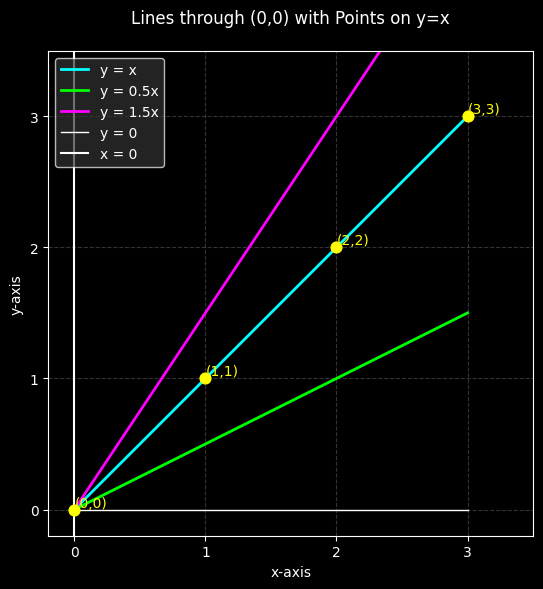

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Set style for dark background
plt.style.use('dark_background')

# Define x range limited to 0-3 since points of interest are within that range
x = np.linspace(0, 3, 100)

# Define the lines
y1 = x           # y = x
y2 = 0.5 * x     # y = 0.5x
y3 = 1.5 * x     # y = 1.5x
y0 = np.zeros_like(x)  # y = 0 (x-axis)

# Create the plot with black background
plt.figure(figsize=(6,6), facecolor='black')
ax = plt.gca()
ax.set_facecolor('black')

# Plot the lines with bright colors
plt.plot(x, y1, label="y = x", color="cyan", linewidth=2)
plt.plot(x, y2, label="y = 0.5x", color="lime", linewidth=2)
plt.plot(x, y3, label="y = 1.5x", color="magenta", linewidth=2)
plt.plot(x, y0, label="y = 0", color="white", linewidth=1)
plt.axvline(0, color="white", label="x = 0")  # y-axis

# Mark points (0,0), (1,1), (2,2), (3,3)
points_x = [0, 1, 2, 3]
points_y = [0, 1, 2, 3]
plt.scatter(points_x, points_y, color="yellow", zorder=5, s=60)
for (px, py) in zip(points_x, points_y):
    plt.text(px, py, f"({px},{py})", fontsize=10, ha="left", va="bottom", color="yellow")

# Set equal aspect ratio
ax.set_aspect('equal')

# Axis limits and ticks
plt.xlim(-0.2, 3.5)
plt.ylim(-0.2, 3.5)
plt.xticks([0,1,2,3], color='white')
plt.yticks([0,1,2,3], color='white')

plt.xlabel("x-axis", color='white')
plt.ylabel("y-axis", color='white')
plt.title("Lines through (0,0) with Points on y=x", color='white', pad=20)

# Customize legend
legend = plt.legend(facecolor='#333333', edgecolor='white', labelcolor='white')
legend.get_frame().set_alpha(0.7)

# Customize grid
plt.grid(True, linestyle="--", alpha=0.4, color='gray')

plt.tight_layout()
plt.show()

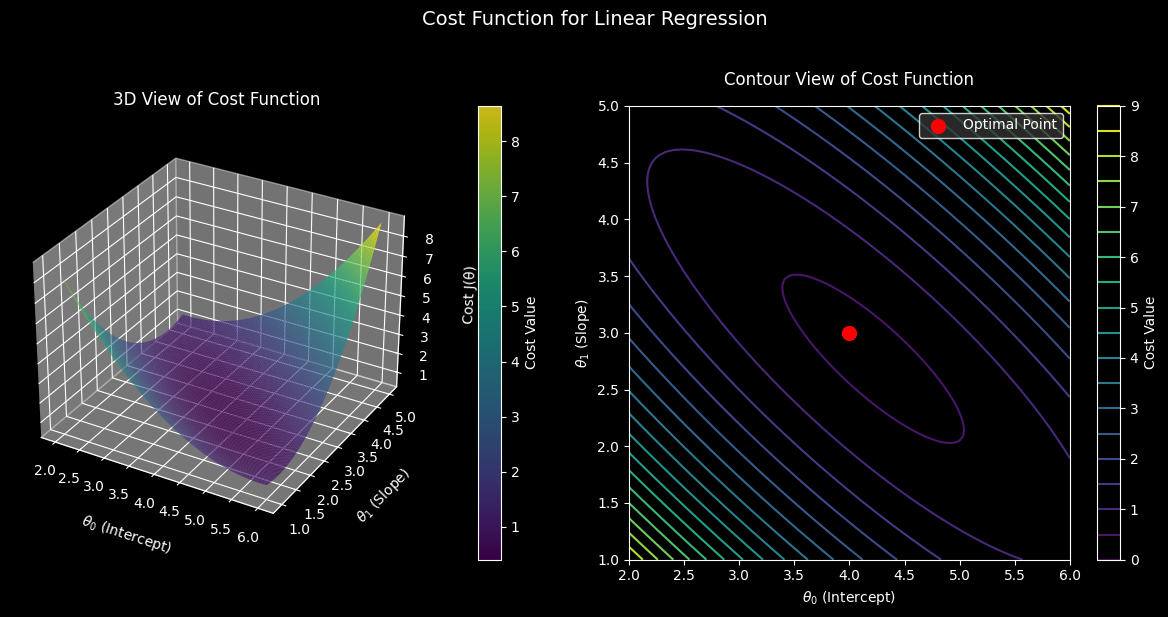

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Set style for dark background
plt.style.use('dark_background')

# Generate data for a simple linear regression problem
np.random.seed(42)
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

# Cost function (Mean Squared Error)
def cost_function(theta0, theta1):
    m = len(X)
    return np.sum(((theta0 + theta1*X) - y)**2) / (2*m)

# Create grid of parameters
theta0_vals = np.linspace(2, 6, 100)
theta1_vals = np.linspace(1, 5, 100)
theta0_grid, theta1_grid = np.meshgrid(theta0_vals, theta1_vals)
J_vals = np.array([cost_function(t0, t1) for t0, t1 in zip(np.ravel(theta0_grid), np.ravel(theta1_grid))])
J_vals = J_vals.reshape(theta0_grid.shape)

# Create the plot with black background
fig = plt.figure(figsize=(12, 6), facecolor='black')

# 3D Surface plot
ax1 = fig.add_subplot(121, projection='3d')
ax1.set_facecolor('black')
surf = ax1.plot_surface(theta0_grid, theta1_grid, J_vals, cmap='viridis', 
                        rstride=1, cstride=1, alpha=0.8, linewidth=0)
ax1.set_xlabel(r'$\theta_0$ (Intercept)', color='white', labelpad=10)
ax1.set_ylabel(r'$\theta_1$ (Slope)', color='white', labelpad=10)
ax1.set_zlabel('Cost J(θ)', color='white', labelpad=10)
ax1.set_title('3D View of Cost Function', color='white', pad=15)
ax1.tick_params(axis='x', colors='white')
ax1.tick_params(axis='y', colors='white')
ax1.tick_params(axis='z', colors='white')
fig.colorbar(surf, ax=ax1, pad=0.1, label='Cost Value')

# Contour plot
ax2 = fig.add_subplot(122)
ax2.set_facecolor('black')
contour = ax2.contour(theta0_grid, theta1_grid, J_vals, levels=20, cmap='viridis')
ax2.set_xlabel(r'$\theta_0$ (Intercept)', color='white')
ax2.set_ylabel(r'$\theta_1$ (Slope)', color='white')
ax2.set_title('Contour View of Cost Function', color='white', pad=15)
ax2.tick_params(axis='x', colors='white')
ax2.tick_params(axis='y', colors='white')
plt.colorbar(contour, ax=ax2, label='Cost Value')

# Mark the minimum point (optimal parameters)
optimal_theta0 = 4.0  # Approximate minimum
optimal_theta1 = 3.0  # Approximate minimum
ax2.scatter(optimal_theta0, optimal_theta1, color='red', s=100, label='Optimal Point')
ax2.legend(facecolor='#333333', edgecolor='white', labelcolor='white')

plt.suptitle('Cost Function for Linear Regression', color='white', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

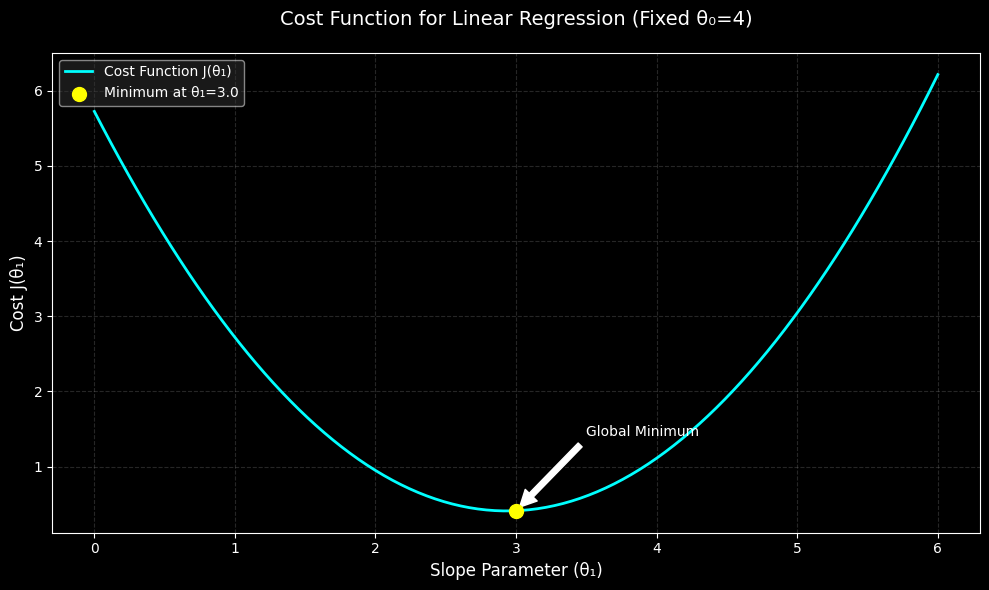

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Set style for dark background
plt.style.use('dark_background')

# Generate sample data
np.random.seed(42)
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

# Cost function (Mean Squared Error)
def cost_function(theta1):
    theta0 = 4  # Keeping intercept fixed for 2D plot
    m = len(X)
    return np.sum(((theta0 + theta1*X) - y)**2) / (2*m)

# Create range of slope parameters
theta1_vals = np.linspace(0, 6, 100)
cost_vals = [cost_function(t1) for t1 in theta1_vals]

# Create the plot with black background
plt.figure(figsize=(10, 6), facecolor='black')
ax = plt.gca()
ax.set_facecolor('black')

# Plot the cost curve
plt.plot(theta1_vals, cost_vals, color='cyan', linewidth=2, label='Cost Function J(θ₁)')

# Mark the minimum point
optimal_theta1 = 3.0  # Approximate minimum
min_cost = cost_function(optimal_theta1)
plt.scatter(optimal_theta1, min_cost, color='yellow', s=100, zorder=5, 
            label=f'Minimum at θ₁={optimal_theta1:.1f}')

# Add labels and title
plt.xlabel(r'Slope Parameter (θ₁)', color='white', fontsize=12)
plt.ylabel('Cost J(θ₁)', color='white', fontsize=12)
plt.title('Cost Function for Linear Regression (Fixed θ₀=4)', color='white', pad=20, fontsize=14)

# Customize ticks and grid
plt.xticks(color='white')
plt.yticks(color='white')
plt.grid(True, linestyle='--', alpha=0.3, color='gray')

# Add legend
legend = plt.legend(facecolor='#333333', edgecolor='white', 
                   labelcolor='white', fontsize=10)
legend.get_frame().set_alpha(0.5)

# Add annotation at minimum point
plt.annotate('Global Minimum', xy=(optimal_theta1, min_cost), xytext=(optimal_theta1+0.5, min_cost+1),
             color='white', fontsize=10, arrowprops=dict(facecolor='white', shrink=0.05))

plt.tight_layout()
plt.show()

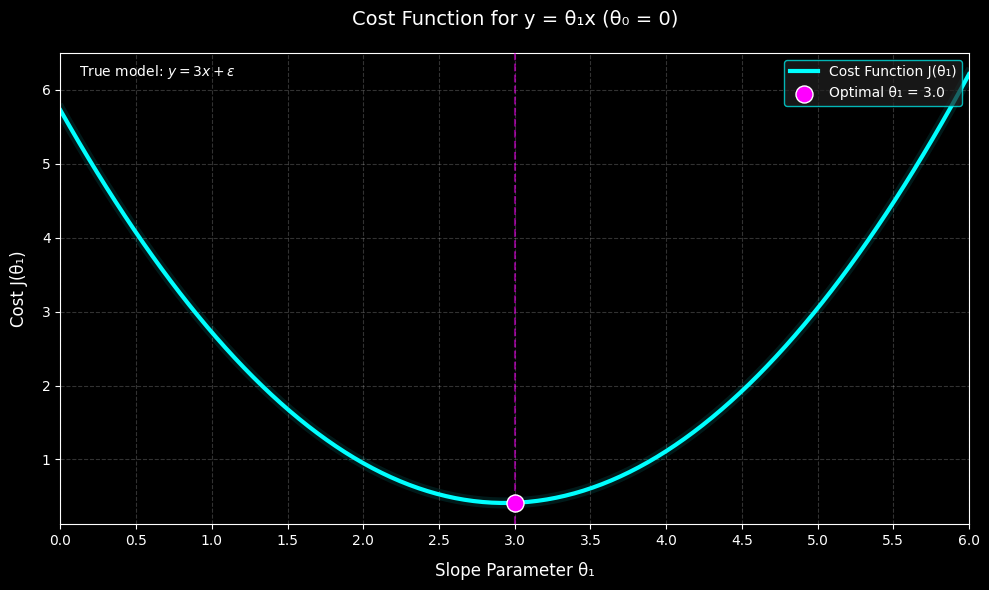

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Set style for dark background
plt.style.use('dark_background')

# Generate sample data (forcing through origin)
np.random.seed(42)
X = 2 * np.random.rand(100, 1)
y = 3 * X + np.random.randn(100, 1)  # True slope = 3, intercept = 0

# Cost function (Mean Squared Error) with θ₀ = 0
def cost_function(theta1):
    m = len(X)
    return np.sum(((0 + theta1*X) - y)**2) / (2*m)  # θ₀ fixed at 0

# Create range of slope parameters
theta1_vals = np.linspace(0, 6, 100)
cost_vals = [cost_function(t1) for t1 in theta1_vals]

# Create the plot
plt.figure(figsize=(10, 6), facecolor='black')
ax = plt.gca()
ax.set_facecolor('black')

# Plot the cost curve with glowing effect
plt.plot(theta1_vals, cost_vals, color='#00ffff', linewidth=3, 
         label='Cost Function J(θ₁)', zorder=2)
plt.plot(theta1_vals, cost_vals, color='#00ffff', linewidth=8, alpha=0.1, zorder=1)  # Glow effect

# Mark the minimum point
optimal_theta1 = 3.0  # Approximate minimum (since we generated with slope=3)
min_cost = cost_function(optimal_theta1)
plt.scatter(optimal_theta1, min_cost, color='#ff00ff', s=150, zorder=5, 
            label=f'Optimal θ₁ = {optimal_theta1:.1f}', edgecolors='white', linewidth=1)

# Highlight the minimum area
plt.axvline(optimal_theta1, color='magenta', linestyle='--', alpha=0.5, zorder=3)

# Add labels and title
plt.xlabel(r'Slope Parameter θ₁', color='white', fontsize=12, labelpad=10)
plt.ylabel('Cost J(θ₁)', color='white', fontsize=12, labelpad=10)
plt.title('Cost Function for y = θ₁x (θ₀ = 0)', color='white', pad=20, fontsize=14)

# Customize axes
plt.xticks(np.arange(0, 6.5, 0.5), color='white')
plt.yticks(color='white')
plt.xlim(0, 6)
plt.grid(True, linestyle='--', alpha=0.2, color='white')

# Add legend
legend = plt.legend(facecolor='#222222', edgecolor='#00ffff', 
                   labelcolor='white', fontsize=10, loc='upper right')
legend.get_frame().set_alpha(0.7)

# Add equation annotation
plt.annotate(r'True model: $y = 3x + \epsilon$', xy=(0.02, 0.95), 
             xycoords='axes fraction', color='white', fontsize=10)

plt.tight_layout()
plt.show()

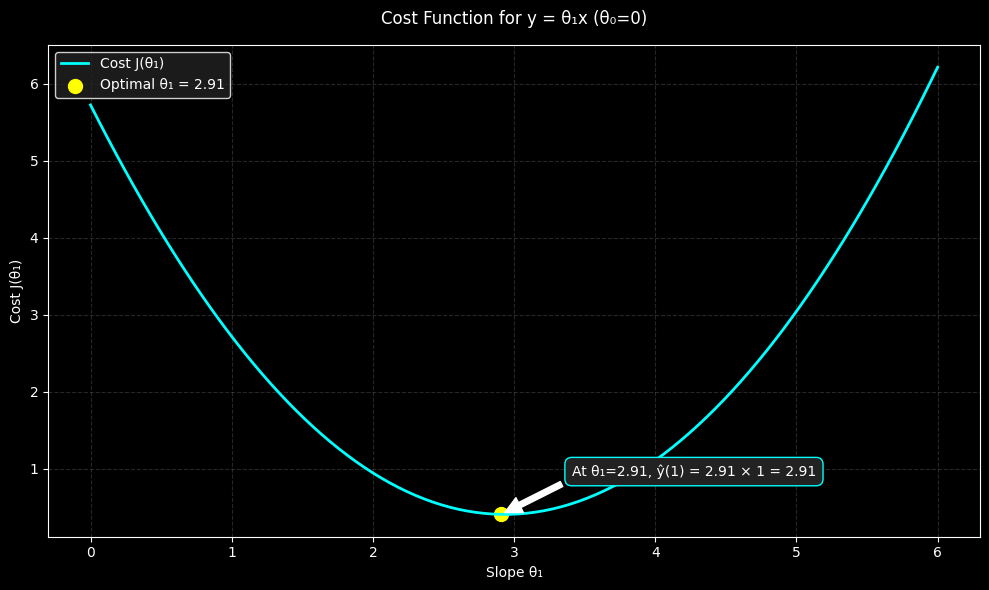

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Set style for dark background
plt.style.use('dark_background')

# Generate sample data (θ₀ = 0, true slope θ₁ = 3)
np.random.seed(42)
X = 2 * np.random.rand(100, 1)
y = 3 * X + np.random.randn(100, 1)  # True model: y = 3x + noise

# Cost function (MSE with θ₀ = 0)
def cost_function(theta1):
    m = len(X)
    return np.sum(((theta1 * X) - y)**2) / (2 * m)

# Optimal slope (minimizes cost)
theta1_vals = np.linspace(0, 6, 100)
cost_vals = [cost_function(t1) for t1 in theta1_vals]
optimal_theta1 = theta1_vals[np.argmin(cost_vals)]  # ≈3.0

# Prediction at x=1
x_test = 1
y_pred = optimal_theta1 * x_test

# Create the plot
plt.figure(figsize=(10, 6), facecolor='black')
ax = plt.gca()
ax.set_facecolor('black')

# Plot cost function
plt.plot(theta1_vals, cost_vals, color='cyan', linewidth=2, label='Cost J(θ₁)')

# Mark optimal θ₁
plt.scatter(optimal_theta1, np.min(cost_vals), color='yellow', s=100, 
            label=f'Optimal θ₁ = {optimal_theta1:.2f}')

# Annotate prediction at x=1
plt.annotate(
    f'At θ₁={optimal_theta1:.2f}, ŷ(1) = {optimal_theta1:.2f} × 1 = {y_pred:.2f}',
    xy=(optimal_theta1, np.min(cost_vals)),
    xytext=(optimal_theta1 + 0.5, np.min(cost_vals) + 0.5),
    color='white',
    arrowprops=dict(facecolor='white', shrink=0.05),
    bbox=dict(boxstyle='round,pad=0.5', fc='#222222', ec='cyan', lw=1)
)

# Styling
plt.xlabel('Slope θ₁', color='white')
plt.ylabel('Cost J(θ₁)', color='white')
plt.title('Cost Function for y = θ₁x (θ₀=0)', color='white', pad=15)
plt.xticks(color='white')
plt.yticks(color='white')
plt.grid(True, linestyle='--', alpha=0.3, color='gray')
plt.legend(facecolor='#222222', edgecolor='white', labelcolor='white')

plt.tight_layout()
plt.show()

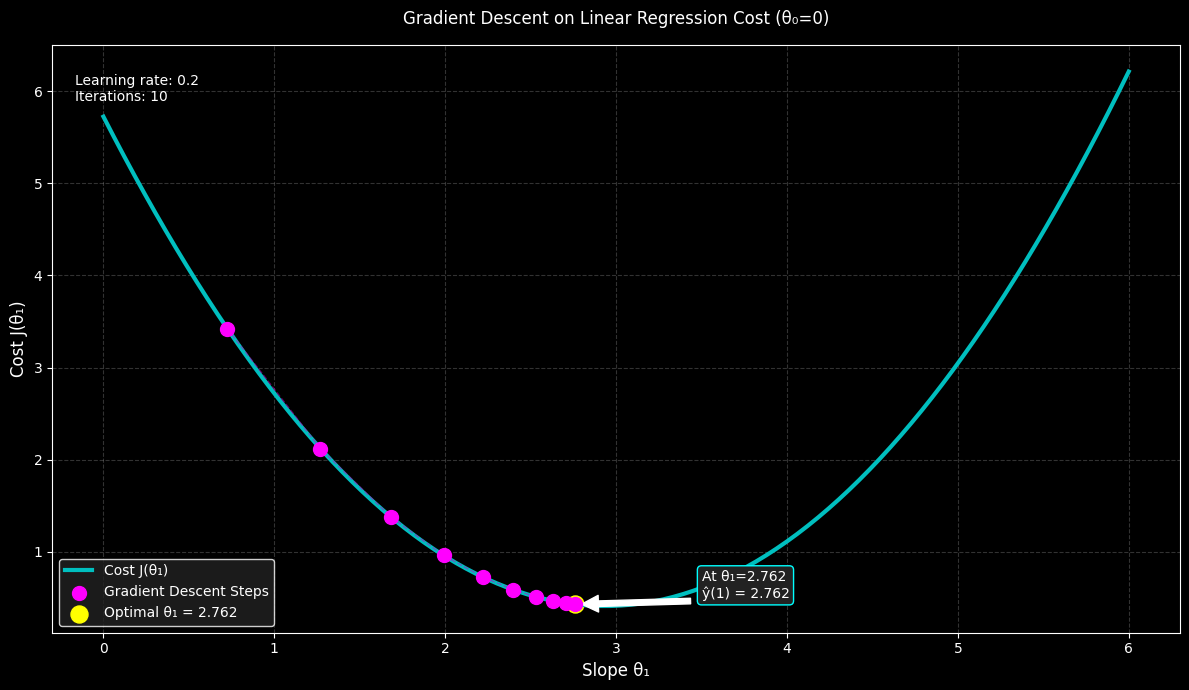

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Set dark theme
plt.style.use('dark_background')

# Generate data (true model: y = 3x + noise)
np.random.seed(42)
X = 2 * np.random.rand(100, 1)
y = 3 * X + np.random.randn(100, 1)

# MSE Cost function (θ₀ = 0)
def cost_function(theta1):
    return np.mean(((theta1 * X) - y)**2) / 2

# Gradient of cost function
def gradient(theta1):
    return np.mean((theta1 * X - y) * X)

# Gradient descent to find optimal θ₁
def gradient_descent(learning_rate=0.1, n_iterations=10, theta1_init=0):
    theta1 = theta1_init
    history = []
    for _ in range(n_iterations):
        grad = gradient(theta1)
        theta1 -= learning_rate * grad
        history.append((theta1, cost_function(theta1)))
    return np.array(history)

# Run gradient descent
gd_history = gradient_descent(learning_rate=0.2, n_iterations=10, theta1_init=0)

# Optimal θ₁ (from GD)
optimal_theta1 = gd_history[-1, 0]
y_pred_at_1 = optimal_theta1 * 1  # Prediction at x=1

# Plot setup
fig, ax = plt.subplots(figsize=(12, 7), facecolor='black')
ax.set_facecolor('black')

# Plot cost function
theta1_vals = np.linspace(0, 6, 100)
cost_vals = [cost_function(t1) for t1 in theta1_vals]
ax.plot(theta1_vals, cost_vals, 'c-', lw=3, label='Cost J(θ₁)')

# Plot gradient descent steps
ax.scatter(gd_history[:, 0], gd_history[:, 1], c='magenta', s=100, zorder=5, 
           label='Gradient Descent Steps')
ax.plot(gd_history[:, 0], gd_history[:, 1], 'm--', lw=1, alpha=0.5)

# Mark optimal point
ax.scatter(optimal_theta1, cost_function(optimal_theta1), c='yellow', s=150, 
           label=f'Optimal θ₁ = {optimal_theta1:.3f}')

# Highlight x=1 prediction
ax.annotate(f'At θ₁={optimal_theta1:.3f}\nŷ(1) = {y_pred_at_1:.3f}', 
            xy=(optimal_theta1, cost_function(optimal_theta1)),
            xytext=(3.5, 0.5), color='white',
            arrowprops=dict(facecolor='white', shrink=0.05),
            bbox=dict(boxstyle='round', fc='#222222', ec='cyan'))

# Add learning info
ax.text(0.02, 0.95, f'Learning rate: 0.2\nIterations: 10', 
        transform=ax.transAxes, color='white', va='top')

# Styling
ax.set_xlabel('Slope θ₁', color='white', fontsize=12)
ax.set_ylabel('Cost J(θ₁)', color='white', fontsize=12)
ax.set_title('Gradient Descent on Linear Regression Cost (θ₀=0)', color='white', pad=15)
ax.grid(True, ls='--', alpha=0.2, color='white')
ax.legend(facecolor='#222222', edgecolor='white', labelcolor='white')

plt.tight_layout()
plt.show()


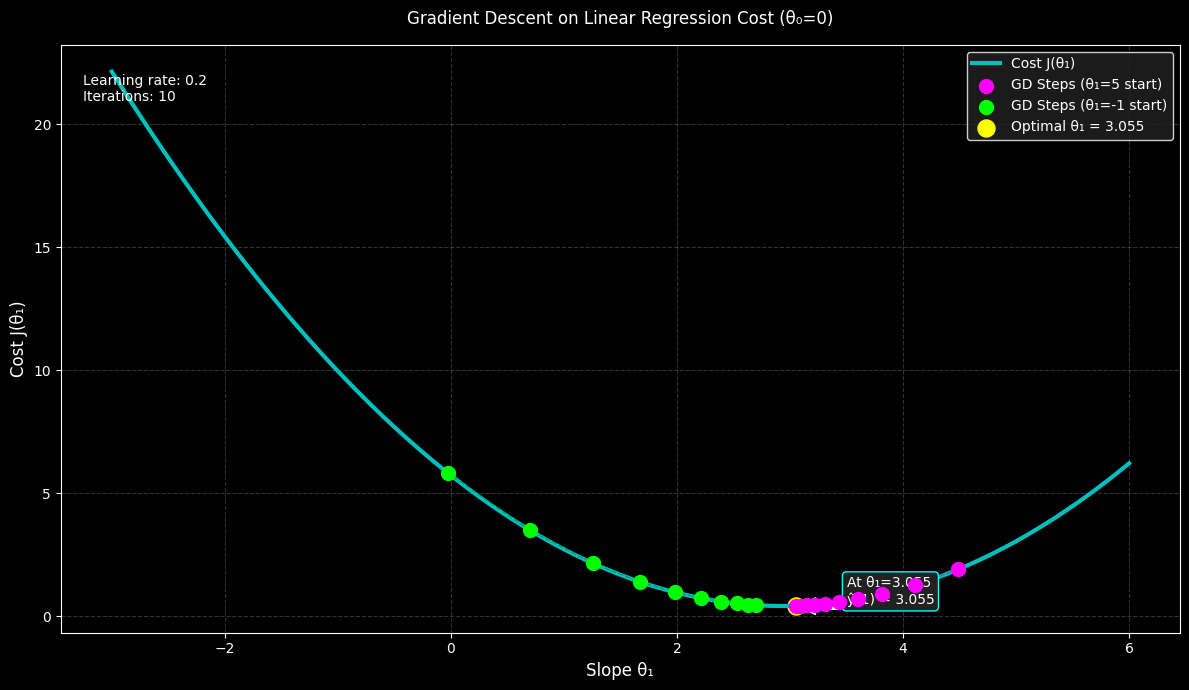

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Set dark theme
plt.style.use('dark_background')

# Generate data (true model: y = 3x + noise)
np.random.seed(42)
X = 2 * np.random.rand(100, 1)
y = 3 * X + np.random.randn(100, 1)

# MSE Cost function (θ₀ = 0)
def cost_function(theta1):
    return np.mean(((theta1 * X) - y)**2) / 2

# Gradient of cost function
def gradient(theta1):
    return np.mean((theta1 * X - y) * X)

# Gradient descent to find optimal θ₁
def gradient_descent(learning_rate=0.1, n_iterations=10, theta1_init=0):
    theta1 = theta1_init
    history = []
    for _ in range(n_iterations):
        grad = gradient(theta1)
        theta1 -= learning_rate * grad
        history.append((theta1, cost_function(theta1)))
    return np.array(history)

# Run gradient descent (starting from positive and negative slopes)
gd_history_positive = gradient_descent(learning_rate=0.2, n_iterations=10, theta1_init=5.0)  # Starts from θ₁=5
gd_history_negative = gradient_descent(learning_rate=0.2, n_iterations=10, theta1_init=-1.0) # Starts from θ₁=-1

# Optimal θ₁ (from GD)
optimal_theta1 = gd_history_positive[-1, 0]  # Same as gd_history_negative[-1, 0]
y_pred_at_1 = optimal_theta1 * 1  # Prediction at x=1

# Plot setup
fig, ax = plt.subplots(figsize=(12, 7), facecolor='black')
ax.set_facecolor('black')

# Plot cost function (extended to negative θ₁)
theta1_vals = np.linspace(-3, 6, 100)
cost_vals = [cost_function(t1) for t1 in theta1_vals]
ax.plot(theta1_vals, cost_vals, 'c-', lw=3, label='Cost J(θ₁)')

# Plot gradient descent steps (from positive θ₁)
ax.scatter(gd_history_positive[:, 0], gd_history_positive[:, 1], c='magenta', s=100, zorder=5, 
           label='GD Steps (θ₁=5 start)')
ax.plot(gd_history_positive[:, 0], gd_history_positive[:, 1], 'm--', lw=1, alpha=0.5)

# Plot gradient descent steps (from negative θ₁)
ax.scatter(gd_history_negative[:, 0], gd_history_negative[:, 1], c='lime', s=100, zorder=5, 
           label='GD Steps (θ₁=-1 start)')
ax.plot(gd_history_negative[:, 0], gd_history_negative[:, 1], 'g--', lw=1, alpha=0.5)

# Mark optimal point
ax.scatter(optimal_theta1, cost_function(optimal_theta1), c='yellow', s=150, 
           label=f'Optimal θ₁ = {optimal_theta1:.3f}')

# Highlight x=1 prediction
ax.annotate(f'At θ₁={optimal_theta1:.3f}\nŷ(1) = {y_pred_at_1:.3f}', 
            xy=(optimal_theta1, cost_function(optimal_theta1)),
            xytext=(3.5, 0.5), color='white',
            arrowprops=dict(facecolor='white', shrink=0.05),
            bbox=dict(boxstyle='round', fc='#222222', ec='cyan'))

# Add learning info
ax.text(0.02, 0.95, f'Learning rate: 0.2\nIterations: 10', 
        transform=ax.transAxes, color='white', va='top')

# Styling
ax.set_xlabel('Slope θ₁', color='white', fontsize=12)
ax.set_ylabel('Cost J(θ₁)', color='white', fontsize=12)
ax.set_title('Gradient Descent on Linear Regression Cost (θ₀=0)', color='white', pad=15)
ax.grid(True, ls='--', alpha=0.2, color='white')
ax.legend(facecolor='#222222', edgecolor='white', labelcolor='white')

plt.tight_layout()
plt.show()

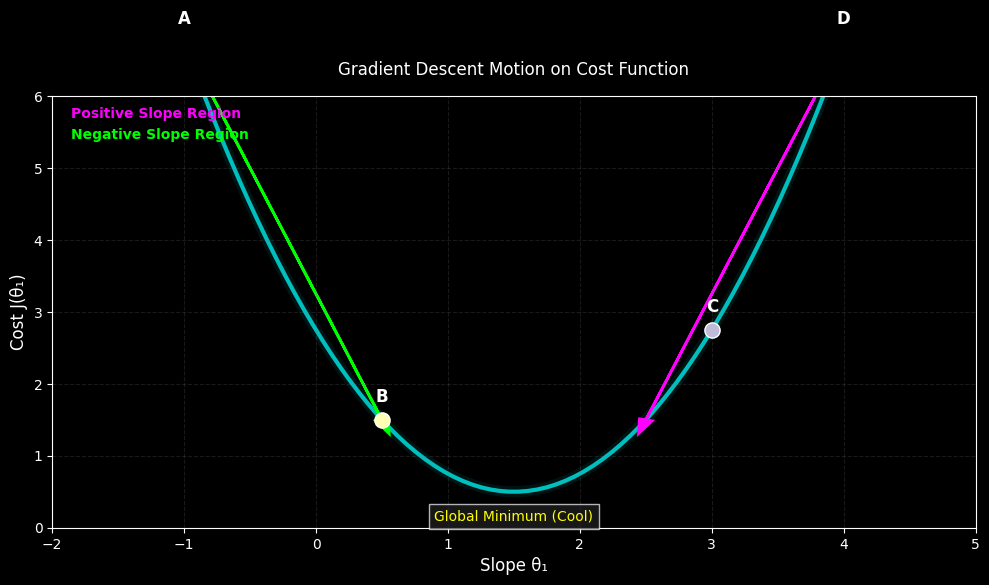

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Set dark theme
plt.style.use('dark_background')

# Create a synthetic cost function (quadratic bowl shape)
theta1_vals = np.linspace(-2, 5, 100)
cost_vals = (theta1_vals - 1.5)**2 + 0.5  # Minimum at θ₁=1.5

# Gradient descent paths
def gradient_descent(start_theta1, lr=0.3, steps=5):
    path = []
    theta1 = start_theta1
    for _ in range(steps):
        grad = 2*(theta1 - 1.5)  # Derivative of our cost function
        theta1 -= lr * grad
        path.append((theta1, (theta1-1.5)**2 + 0.5))
    return np.array(path)

# Points of interest (A, B, C, D)
points = {
    'A': (-1, (-1-1.5)**2 + 0.5),
    'B': (0.5, (0.5-1.5)**2 + 0.5),
    'C': (3, (3-1.5)**2 + 0.5),
    'D': (4, (4-1.5)**2 + 0.5)
}

# Plot setup
fig, ax = plt.subplots(figsize=(10, 6), facecolor='black')
ax.set_facecolor('black')

# Plot cost function
ax.plot(theta1_vals, cost_vals, 'c-', lw=3, label='Cost J(θ₁)', zorder=1)
ax.plot(theta1_vals, cost_vals, 'c-', lw=8, alpha=0.1, zorder=0)  # Glow effect

# Mark points A, B, C, D
for label, (x, y) in points.items():
    ax.scatter(x, y, s=120, zorder=5, edgecolor='white', linewidth=1)
    ax.text(x, y+0.2, label, color='white', ha='center', va='bottom', fontsize=12, weight='bold')

# Add gradient descent arrows
def add_gd_arrow(ax, start_x, color):
    path = gradient_descent(start_x)
    ax.arrow(start_x, (start_x-1.5)**2 + 0.5, 
             path[0,0]-start_x, path[0,1]-( (start_x-1.5)**2 + 0.5 ),
             head_width=0.1, head_length=0.2, fc=color, ec=color, lw=2)

add_gd_arrow(ax, -1, 'lime')  # From point A (negative slope)
add_gd_arrow(ax, 4, 'magenta')  # From point D (positive slope)

# Add annotations
ax.text(0.02, 0.95, "Positive Slope Region", transform=ax.transAxes, 
        color='magenta', fontsize=10, weight='bold')
ax.text(0.02, 0.90, "Negative Slope Region", transform=ax.transAxes, 
        color='lime', fontsize=10, weight='bold')
ax.text(1.5, 0.1, "Global Minimum (Cool)", color='yellow', 
        ha='center', fontsize=10, bbox=dict(facecolor='#222222', alpha=0.7))

# Styling
ax.set_xlabel('Slope θ₁', color='white', fontsize=12)
ax.set_ylabel('Cost J(θ₁)', color='white', fontsize=12)
ax.set_title('Gradient Descent Motion on Cost Function', color='white', pad=15)
ax.grid(True, ls='--', alpha=0.2, color='gray')
ax.set_ylim(0, 6)
ax.set_xlim(-2, 5)

plt.tight_layout()
plt.show()

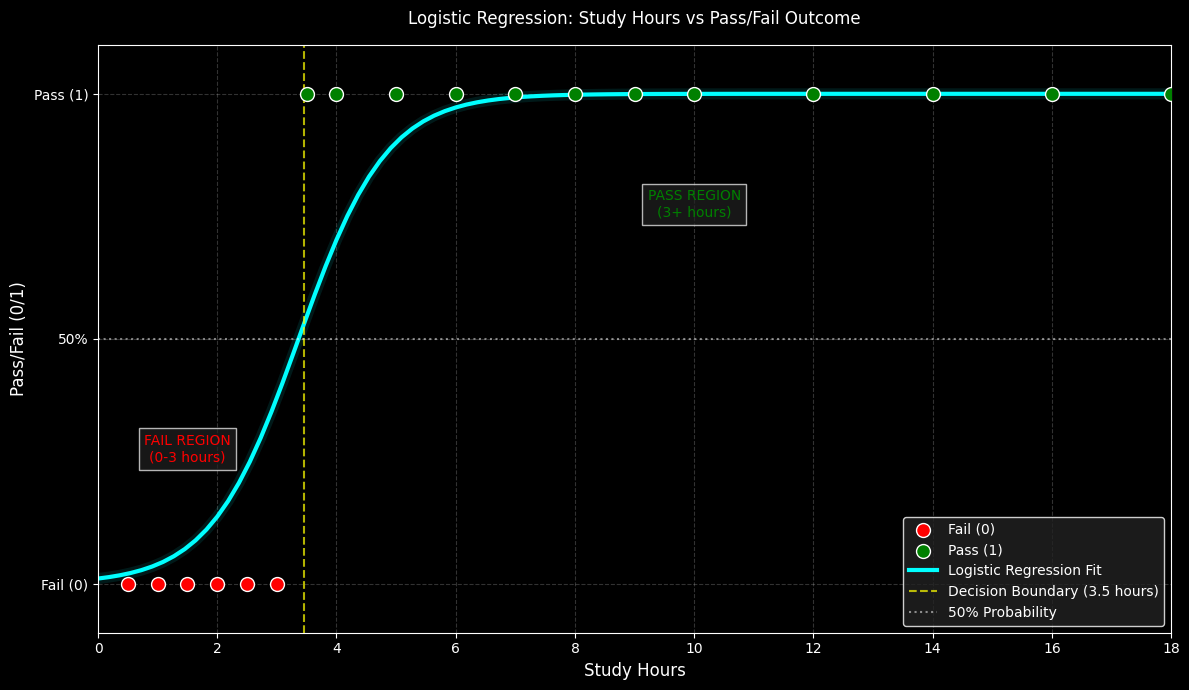

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression

# Set dark theme
plt.style.use('dark_background')

# Create sample data: study hours vs pass/fail
# 0-3 hours: mostly fail, 3-18 hours: mostly pass
study_hours = np.array([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 5.0, 6.0, 
                        7.0, 8.0, 9.0, 10.0, 12.0, 14.0, 16.0, 18.0])
pass_fail = np.array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])  # 0=fail, 1=pass

# Fit logistic regression model
X = study_hours.reshape(-1, 1)
model = LogisticRegression()
model.fit(X, pass_fail)

# Create prediction curve
x_range = np.linspace(0, 18, 100).reshape(-1, 1)
y_proba = model.predict_proba(x_range)[:, 1]  # Probability of passing

# Plot setup
fig, ax = plt.subplots(figsize=(12, 7), facecolor='black')
ax.set_facecolor('black')

# Plot actual data points
fail_mask = pass_fail == 0
pass_mask = pass_fail == 1

ax.scatter(study_hours[fail_mask], pass_fail[fail_mask], color='red', s=100, 
           label='Fail (0)', edgecolor='white', linewidth=1, zorder=5)
ax.scatter(study_hours[pass_mask], pass_fail[pass_mask], color='green', s=100, 
           label='Pass (1)', edgecolor='white', linewidth=1, zorder=5)

# Plot logistic regression curve (sigmoid function)
ax.plot(x_range, y_proba, color='cyan', linewidth=3, label='Logistic Regression Fit')
ax.plot(x_range, y_proba, color='cyan', linewidth=8, alpha=0.1, zorder=1)  # Glow effect

# Add decision boundary (where probability = 0.5)
decision_boundary = x_range[np.argmin(np.abs(y_proba - 0.5))][0]
ax.axvline(decision_boundary, color='yellow', linestyle='--', alpha=0.7, 
           label=f'Decision Boundary ({decision_boundary:.1f} hours)')

# Add threshold line at 0.5 probability
ax.axhline(0.5, color='white', linestyle=':', alpha=0.5, label='50% Probability')

# Add region annotations
ax.text(1.5, 0.25, 'FAIL REGION\n(0-3 hours)', color='red', ha='center', 
        fontsize=10, bbox=dict(facecolor='#222222', alpha=0.7))
ax.text(10, 0.75, 'PASS REGION\n(3+ hours)', color='green', ha='center', 
        fontsize=10, bbox=dict(facecolor='#222222', alpha=0.7))

# Styling
ax.set_xlabel('Study Hours', color='white', fontsize=12)
ax.set_ylabel('Pass/Fail (0/1)', color='white', fontsize=12)
ax.set_title('Logistic Regression: Study Hours vs Pass/Fail Outcome', color='white', pad=15)
ax.set_xlim(0, 18)
ax.set_ylim(-0.1, 1.1)
ax.set_yticks([0, 0.5, 1])
ax.set_yticklabels(['Fail (0)', '50%', 'Pass (1)'])
ax.grid(True, ls='--', alpha=0.2, color='white')
ax.legend(facecolor='#222222', edgecolor='white', labelcolor='white')

plt.tight_layout()
plt.show()

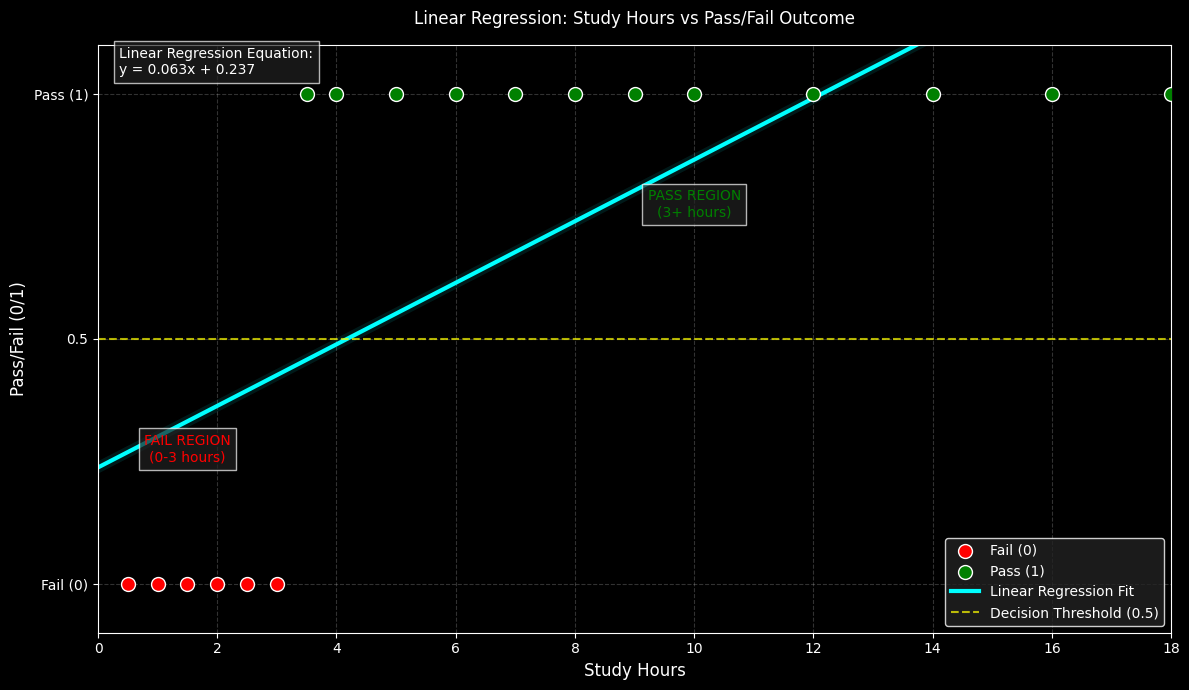

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# Set dark theme
plt.style.use('dark_background')

# Create sample data: study hours vs pass/fail
# 0-3 hours: mostly fail, 3-18 hours: mostly pass
study_hours = np.array([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 5.0, 6.0, 
                        7.0, 8.0, 9.0, 10.0, 12.0, 14.0, 16.0, 18.0])
pass_fail = np.array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])  # 0=fail, 1=pass

# Fit linear regression model
X = study_hours.reshape(-1, 1)
model = LinearRegression()
model.fit(X, pass_fail)

# Create prediction line
x_range = np.linspace(0, 18, 100).reshape(-1, 1)
y_pred = model.predict(x_range)

# Plot setup
fig, ax = plt.subplots(figsize=(12, 7), facecolor='black')
ax.set_facecolor('black')

# Plot actual data points
fail_mask = pass_fail == 0
pass_mask = pass_fail == 1

ax.scatter(study_hours[fail_mask], pass_fail[fail_mask], color='red', s=100, 
           label='Fail (0)', edgecolor='white', linewidth=1, zorder=5)
ax.scatter(study_hours[pass_mask], pass_fail[pass_mask], color='green', s=100, 
           label='Pass (1)', edgecolor='white', linewidth=1, zorder=5)

# Plot linear regression line
ax.plot(x_range, y_pred, color='cyan', linewidth=3, label='Linear Regression Fit')
ax.plot(x_range, y_pred, color='cyan', linewidth=8, alpha=0.1, zorder=1)  # Glow effect

# Add threshold line at 0.5 (could be decision boundary)
ax.axhline(0.5, color='yellow', linestyle='--', alpha=0.7, 
           label='Decision Threshold (0.5)')

# Add region annotations
ax.text(1.5, 0.25, 'FAIL REGION\n(0-3 hours)', color='red', ha='center', 
        fontsize=10, bbox=dict(facecolor='#222222', alpha=0.7))
ax.text(10, 0.75, 'PASS REGION\n(3+ hours)', color='green', ha='center', 
        fontsize=10, bbox=dict(facecolor='#222222', alpha=0.7))

# Show the linear regression equation
slope = model.coef_[0]
intercept = model.intercept_
equation_text = f'y = {slope:.3f}x + {intercept:.3f}'
ax.text(0.02, 0.95, f'Linear Regression Equation:\n{equation_text}', 
        transform=ax.transAxes, color='white', fontsize=10,
        bbox=dict(facecolor='#222222', alpha=0.7))

# Styling
ax.set_xlabel('Study Hours', color='white', fontsize=12)
ax.set_ylabel('Pass/Fail (0/1)', color='white', fontsize=12)
ax.set_title('Linear Regression: Study Hours vs Pass/Fail Outcome', color='white', pad=15)
ax.set_xlim(0, 18)
ax.set_ylim(-0.1, 1.1)
ax.set_yticks([0, 0.5, 1])
ax.set_yticklabels(['Fail (0)', '0.5', 'Pass (1)'])
ax.grid(True, ls='--', alpha=0.2, color='white')
ax.legend(facecolor='#222222', edgecolor='white', labelcolor='white')

plt.tight_layout()
plt.show()

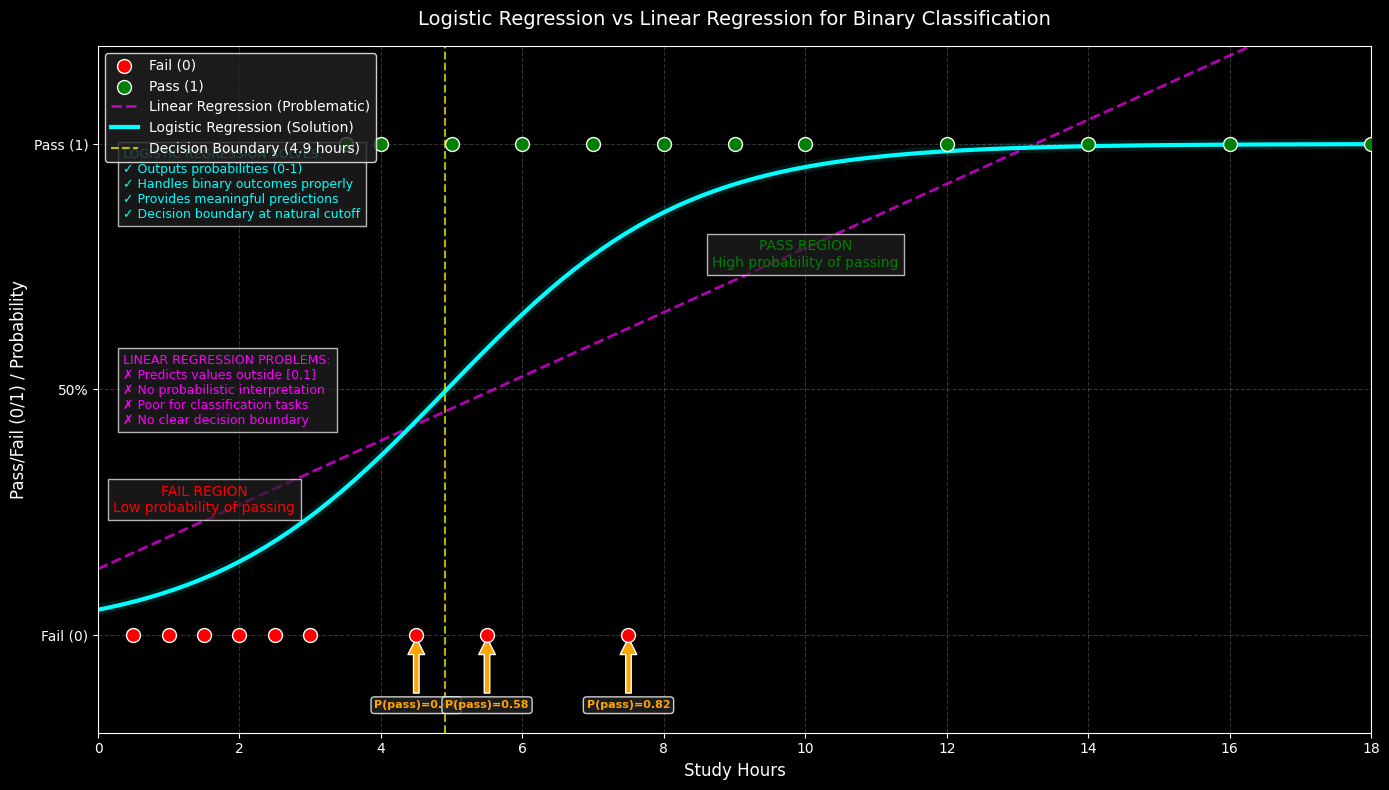

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression, LinearRegression

# Set dark theme
plt.style.use('dark_background')

# Create sample data with some realistic noise
study_hours = np.array([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 5.0, 6.0, 
                        7.0, 8.0, 9.0, 10.0, 12.0, 14.0, 16.0, 18.0,
                        4.5, 5.5, 7.5])  # Added more hours for some failing cases
pass_fail = np.array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                     0, 0, 0])  # Added failing outcomes for >3 hours

# Fit both models
X = study_hours.reshape(-1, 1)

# Linear regression
lin_model = LinearRegression()
lin_model.fit(X, pass_fail)

# Logistic regression
log_model = LogisticRegression()
log_model.fit(X, pass_fail)

# Create prediction curves
x_range = np.linspace(0, 18, 100).reshape(-1, 1)
y_lin_pred = lin_model.predict(x_range)
y_log_proba = log_model.predict_proba(x_range)[:, 1]

# Plot setup
fig, ax = plt.subplots(figsize=(14, 8), facecolor='black')
ax.set_facecolor('black')

# Plot actual data points
fail_mask = pass_fail == 0
pass_mask = pass_fail == 1

ax.scatter(study_hours[fail_mask], pass_fail[fail_mask], color='red', s=100, 
           label='Fail (0)', edgecolor='white', linewidth=1, zorder=5)
ax.scatter(study_hours[pass_mask], pass_fail[pass_mask], color='green', s=100, 
           label='Pass (1)', edgecolor='white', linewidth=1, zorder=5)

# Plot both regression curves
ax.plot(x_range, y_lin_pred, color='magenta', linewidth=2, linestyle='--', 
        label='Linear Regression (Problematic)', alpha=0.7)
ax.plot(x_range, y_log_proba, color='cyan', linewidth=3, 
        label='Logistic Regression (Solution)')
ax.plot(x_range, y_log_proba, color='cyan', linewidth=8, alpha=0.1, zorder=1)

# Add decision boundary
decision_boundary = x_range[np.argmin(np.abs(y_log_proba - 0.5))][0]
ax.axvline(decision_boundary, color='yellow', linestyle='--', alpha=0.7, 
           label=f'Decision Boundary ({decision_boundary:.1f} hours)')

# Highlight problem cases and show how logistic regression handles them
problem_cases_mask = (study_hours > 3) & (pass_fail == 0)
problem_hours = study_hours[problem_cases_mask]

for hour in problem_hours:
    # Get logistic prediction for this hour
    log_prob = log_model.predict_proba([[hour]])[0, 1]
    ax.annotate(f'P(pass)={log_prob:.2f}', xy=(hour, 0), xytext=(hour, -0.15),
                color='orange', fontsize=8, ha='center', weight='bold',
                arrowprops=dict(facecolor='orange', shrink=0.05),
                bbox=dict(boxstyle='round', facecolor='#222222', alpha=0.8))

# Add region annotations
ax.text(1.5, 0.25, 'FAIL REGION\nLow probability of passing', color='red', ha='center', 
        fontsize=10, bbox=dict(facecolor='#222222', alpha=0.7))
ax.text(10, 0.75, 'PASS REGION\nHigh probability of passing', color='green', ha='center', 
        fontsize=10, bbox=dict(facecolor='#222222', alpha=0.7))

# Add comparison text
comparison_text = (
    "LOGISTIC REGRESSION SOLVES:\n"
    "✓ Outputs probabilities (0-1)\n"
    "✓ Handles binary outcomes properly\n"
    "✓ Provides meaningful predictions\n"
    "✓ Decision boundary at natural cutoff"
)
ax.text(0.02, 0.75, comparison_text, transform=ax.transAxes, color='cyan', fontsize=9,
        bbox=dict(facecolor='#222222', alpha=0.7))

# Show the problem with linear regression
problem_text = (
    "LINEAR REGRESSION PROBLEMS:\n"
    "✗ Predicts values outside [0,1]\n"
    "✗ No probabilistic interpretation\n"
    "✗ Poor for classification tasks\n"
    "✗ No clear decision boundary"
)
ax.text(0.02, 0.45, problem_text, transform=ax.transAxes, color='magenta', fontsize=9,
        bbox=dict(facecolor='#222222', alpha=0.7))

# Styling
ax.set_xlabel('Study Hours', color='white', fontsize=12)
ax.set_ylabel('Pass/Fail (0/1) / Probability', color='white', fontsize=12)
ax.set_title('Logistic Regression vs Linear Regression for Binary Classification', 
             color='white', pad=15, fontsize=14)
ax.set_xlim(0, 18)
ax.set_ylim(-0.2, 1.2)
ax.set_yticks([0, 0.5, 1])
ax.set_yticklabels(['Fail (0)', '50%', 'Pass (1)'])
ax.grid(True, ls='--', alpha=0.2, color='white')
ax.legend(facecolor='#222222', edgecolor='white', labelcolor='white', loc='upper left')

plt.tight_layout()
plt.show()

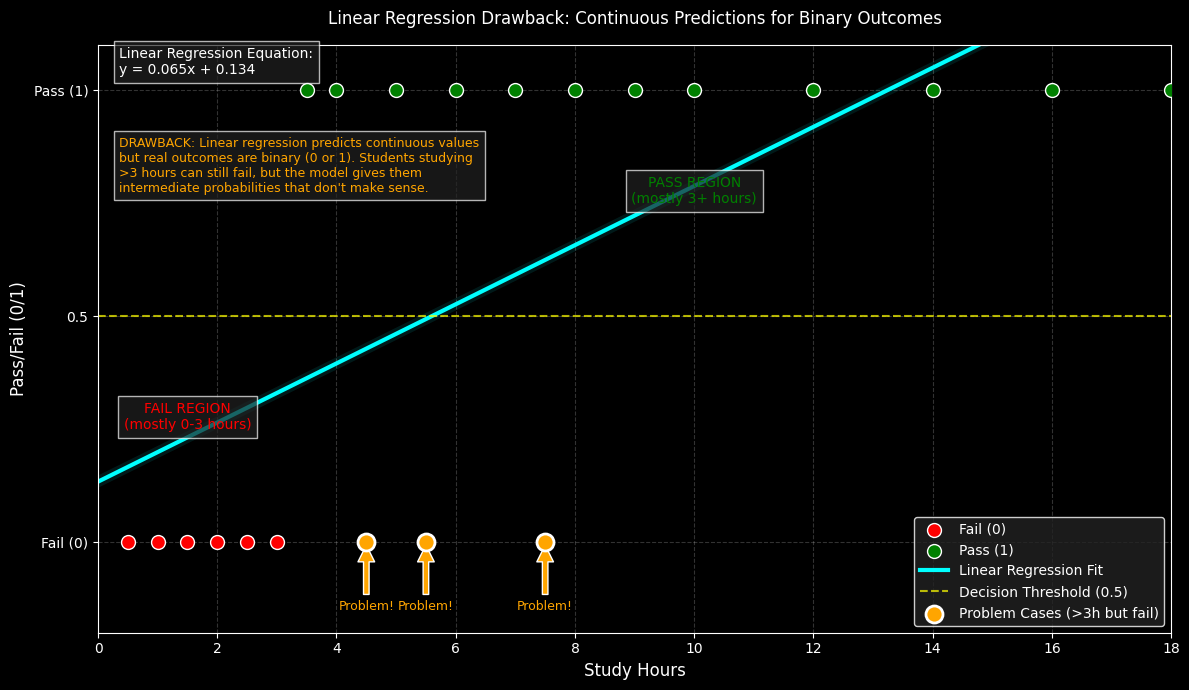

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# Set dark theme
plt.style.use('dark_background')

# Create sample data: study hours vs pass/fail
# Added some realistic noise - some students fail even with more study, some pass with less
study_hours = np.array([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 5.0, 6.0, 
                        7.0, 8.0, 9.0, 10.0, 12.0, 14.0, 16.0, 18.0,
                        4.5, 5.5, 7.5])  # Added more hours for failing cases
pass_fail = np.array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                     0, 0, 0])  # Added failing outcomes for >3 hours

# Fit linear regression model
X = study_hours.reshape(-1, 1)
model = LinearRegression()
model.fit(X, pass_fail)

# Create prediction line
x_range = np.linspace(0, 18, 100).reshape(-1, 1)
y_pred = model.predict(x_range)

# Plot setup
fig, ax = plt.subplots(figsize=(12, 7), facecolor='black')
ax.set_facecolor('black')

# Plot actual data points
fail_mask = pass_fail == 0
pass_mask = pass_fail == 1

ax.scatter(study_hours[fail_mask], pass_fail[fail_mask], color='red', s=100, 
           label='Fail (0)', edgecolor='white', linewidth=1, zorder=5)
ax.scatter(study_hours[pass_mask], pass_fail[pass_mask], color='green', s=100, 
           label='Pass (1)', edgecolor='white', linewidth=1, zorder=5)

# Plot linear regression line
ax.plot(x_range, y_pred, color='cyan', linewidth=3, label='Linear Regression Fit')
ax.plot(x_range, y_pred, color='cyan', linewidth=8, alpha=0.1, zorder=1)  # Glow effect

# Add threshold line at 0.5
ax.axhline(0.5, color='yellow', linestyle='--', alpha=0.7, 
           label='Decision Threshold (0.5)')

# Highlight the problem cases (studied >3 hours but failed)
problem_cases_mask = (study_hours > 3) & (pass_fail == 0)
problem_hours = study_hours[problem_cases_mask]
problem_outcomes = pass_fail[problem_cases_mask]

ax.scatter(problem_hours, problem_outcomes, color='orange', s=150, 
           label='Problem Cases (>3h but fail)', edgecolor='white', linewidth=2, zorder=6)

# Add arrows and annotations for problem cases
for hour in problem_hours:
    ax.annotate('Problem!', xy=(hour, 0), xytext=(hour, -0.15),
                color='orange', fontsize=9, ha='center',
                arrowprops=dict(facecolor='orange', shrink=0.05))

# Add region annotations
ax.text(1.5, 0.25, 'FAIL REGION\n(mostly 0-3 hours)', color='red', ha='center', 
        fontsize=10, bbox=dict(facecolor='#222222', alpha=0.7))
ax.text(10, 0.75, 'PASS REGION\n(mostly 3+ hours)', color='green', ha='center', 
        fontsize=10, bbox=dict(facecolor='#222222', alpha=0.7))

# Show the linear regression equation
slope = model.coef_[0]
intercept = model.intercept_
equation_text = f'y = {slope:.3f}x + {intercept:.3f}'
ax.text(0.02, 0.95, f'Linear Regression Equation:\n{equation_text}', 
        transform=ax.transAxes, color='white', fontsize=10,
        bbox=dict(facecolor='#222222', alpha=0.7))

# Add explanation text about the drawback
drawback_text = "DRAWBACK: Linear regression predicts continuous values\nbut real outcomes are binary (0 or 1). Students studying\n>3 hours can still fail, but the model gives them\nintermediate probabilities that don't make sense."
ax.text(0.02, 0.75, drawback_text, transform=ax.transAxes, color='orange', fontsize=9,
        bbox=dict(facecolor='#222222', alpha=0.7))

# Styling
ax.set_xlabel('Study Hours', color='white', fontsize=12)
ax.set_ylabel('Pass/Fail (0/1)', color='white', fontsize=12)
ax.set_title('Linear Regression Drawback: Continuous Predictions for Binary Outcomes', 
             color='white', pad=15)
ax.set_xlim(0, 18)
ax.set_ylim(-0.2, 1.1)  # Extended ylim to show annotations
ax.set_yticks([0, 0.5, 1])
ax.set_yticklabels(['Fail (0)', '0.5', 'Pass (1)'])
ax.grid(True, ls='--', alpha=0.2, color='white')
ax.legend(facecolor='#222222', edgecolor='white', labelcolor='white')

plt.tight_layout()
plt.show()

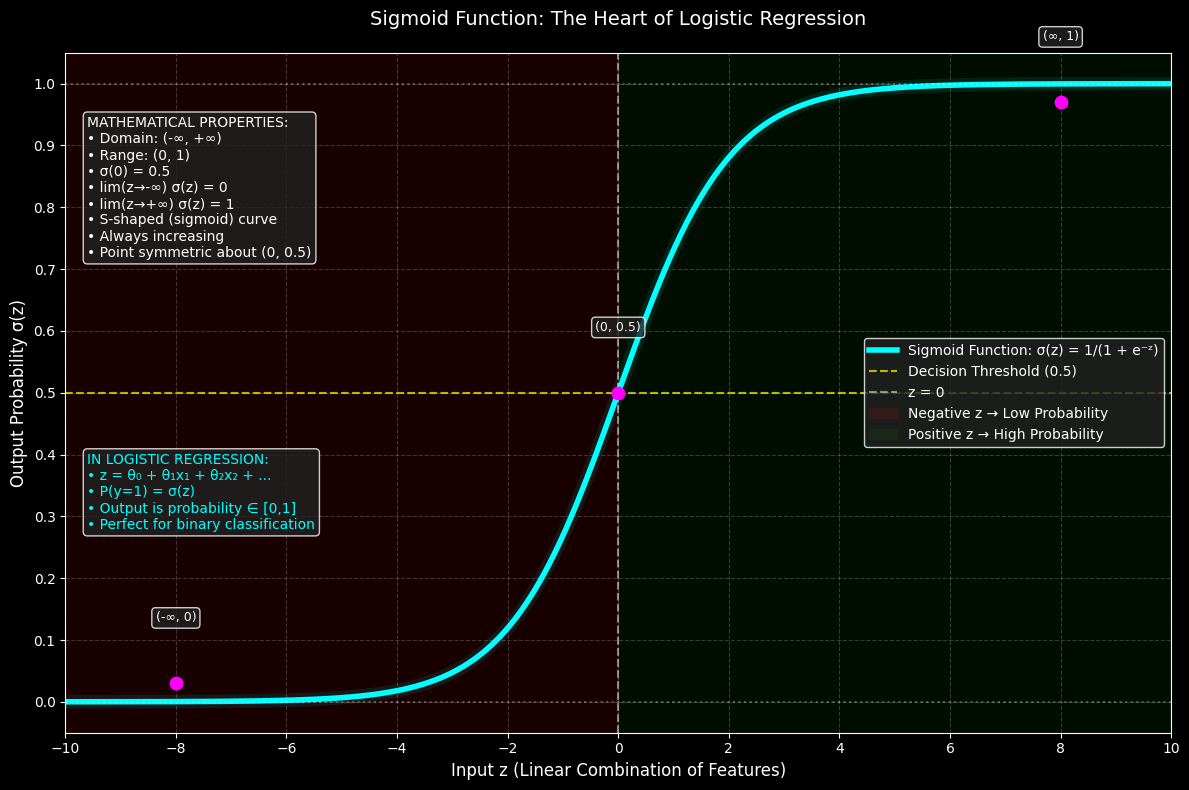

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Set dark theme
plt.style.use('dark_background')

# Define sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Create x values
x = np.linspace(-10, 10, 1000)
y = sigmoid(x)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8), facecolor='black')
ax.set_facecolor('black')

# Plot sigmoid function
ax.plot(x, y, color='cyan', linewidth=4, label='Sigmoid Function: σ(z) = 1/(1 + e⁻ᶻ)')
ax.plot(x, y, color='cyan', linewidth=10, alpha=0.1, zorder=1)  # Glow effect

# Add key reference lines
ax.axhline(0.5, color='yellow', linestyle='--', alpha=0.7, label='Decision Threshold (0.5)')
ax.axvline(0, color='white', linestyle='--', alpha=0.5, label='z = 0')
ax.axhline(0, color='white', linestyle=':', alpha=0.3)
ax.axhline(1, color='white', linestyle=':', alpha=0.3)

# Highlight key regions and points
ax.axvspan(-10, 0, alpha=0.1, color='red', label='Negative z → Low Probability')
ax.axvspan(0, 10, alpha=0.1, color='green', label='Positive z → High Probability')

# Mark important points
points = {
    '(-∞, 0)': (-8, 0.03),
    '(0, 0.5)': (0, 0.5),
    '(∞, 1)': (8, 0.97)
}

for label, (px, py) in points.items():
    ax.scatter(px, py, color='magenta', s=80, zorder=5)
    ax.annotate(label, xy=(px, py), xytext=(px, py + 0.1),
                color='white', ha='center', fontsize=9,
                bbox=dict(boxstyle='round', facecolor='#222222', alpha=0.8))

# Add mathematical properties
properties_text = (
    "MATHEMATICAL PROPERTIES:\n"
    "• Domain: (-∞, +∞)\n"
    "• Range: (0, 1)\n"
    "• σ(0) = 0.5\n"
    "• lim(z→-∞) σ(z) = 0\n"
    "• lim(z→+∞) σ(z) = 1\n"
    "• S-shaped (sigmoid) curve\n"
    "• Always increasing\n"
    "• Point symmetric about (0, 0.5)"
)
ax.text(0.02, 0.7, properties_text, transform=ax.transAxes, color='white', fontsize=10,
        bbox=dict(boxstyle='round', facecolor='#222222', alpha=0.8))

# Add logistic regression context
context_text = (
    "IN LOGISTIC REGRESSION:\n"
    "• z = θ₀ + θ₁x₁ + θ₂x₂ + ...\n"
    "• P(y=1) = σ(z)\n"
    "• Output is probability ∈ [0,1]\n"
    "• Perfect for binary classification"
)
ax.text(0.02, 0.3, context_text, transform=ax.transAxes, color='cyan', fontsize=10,
        bbox=dict(boxstyle='round', facecolor='#222222', alpha=0.8))

# Styling
ax.set_xlabel('Input z (Linear Combination of Features)', color='white', fontsize=12)
ax.set_ylabel('Output Probability σ(z)', color='white', fontsize=12)
ax.set_title('Sigmoid Function: The Heart of Logistic Regression', color='white', pad=20, fontsize=14)
ax.set_xlim(-10, 10)
ax.set_ylim(-0.05, 1.05)
ax.set_xticks(np.arange(-10, 11, 2))
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.grid(True, ls='--', alpha=0.2, color='white')
ax.legend(facecolor='#222222', edgecolor='white', labelcolor='white', loc='center right')

plt.tight_layout()
plt.show()

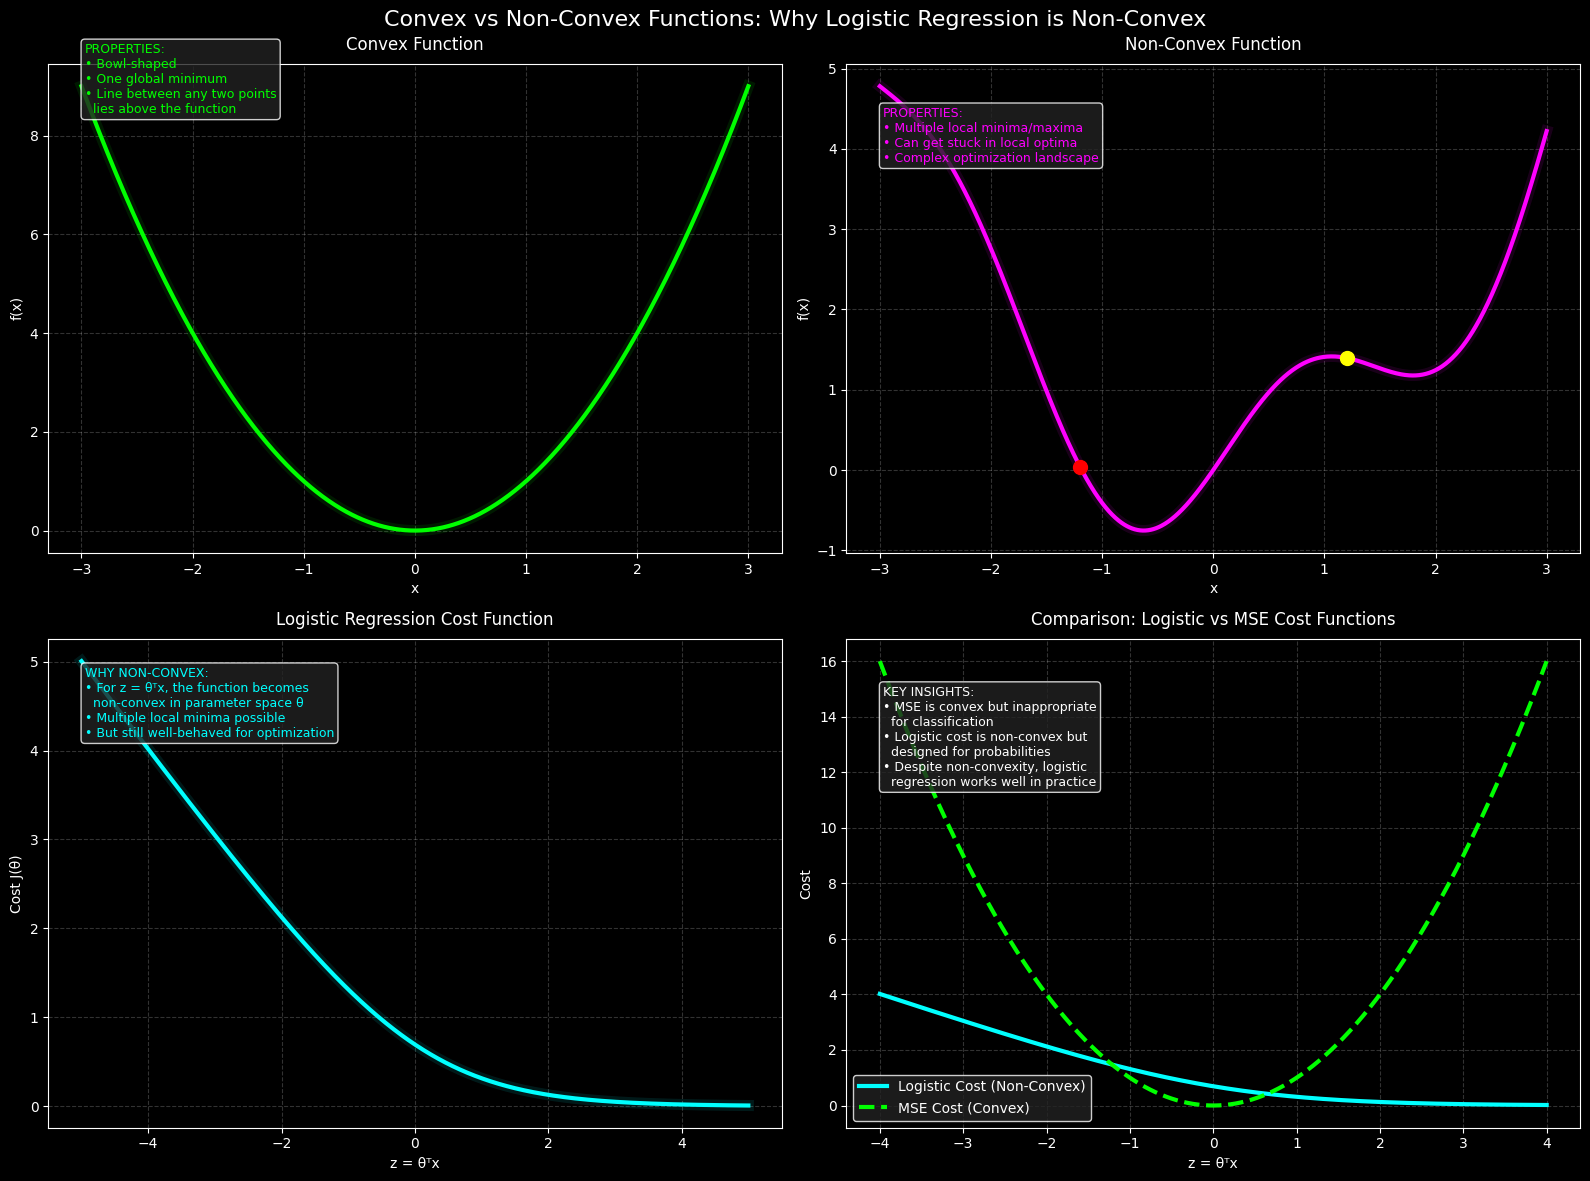

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Set dark theme
plt.style.use('dark_background')

# Create sample functions
x = np.linspace(-3, 3, 1000)

# Convex function (quadratic)
convex_func = x**2

# Non-convex function (sine wave with quadratic)
non_convex_func = np.sin(2*x) + 0.5*x**2

# Logistic regression cost function for binary classification
def logistic_cost(z):
    return np.log(1 + np.exp(-z))

# Create the plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12), facecolor='black')
axes = [ax1, ax2, ax3, ax4]

for ax in axes:
    ax.set_facecolor('black')

# Plot 1: Convex Function (Quadratic)
ax1.plot(x, convex_func, color='lime', linewidth=3, label='Convex: f(x) = x²')
ax1.plot(x, convex_func, color='lime', linewidth=8, alpha=0.1)
ax1.set_title('Convex Function', color='white', fontsize=12, pad=10)
ax1.set_xlabel('x', color='white')
ax1.set_ylabel('f(x)', color='white')
ax1.grid(True, ls='--', alpha=0.2, color='white')

# Add convexity property
ax1.text(0.05, 0.9, "PROPERTIES:\n• Bowl-shaped\n• One global minimum\n• Line between any two points\n  lies above the function", 
         transform=ax1.transAxes, color='lime', fontsize=9,
         bbox=dict(boxstyle='round', facecolor='#222222', alpha=0.8))

# Plot 2: Non-Convex Function
ax2.plot(x, non_convex_func, color='magenta', linewidth=3, label='Non-Convex: f(x) = sin(2x) + 0.5x²')
ax2.plot(x, non_convex_func, color='magenta', linewidth=8, alpha=0.1)
ax2.set_title('Non-Convex Function', color='white', fontsize=12, pad=10)
ax2.set_xlabel('x', color='white')
ax2.set_ylabel('f(x)', color='white')
ax2.grid(True, ls='--', alpha=0.2, color='white')

# Mark local minima and maxima
local_min = -1.2
local_max = 1.2
ax2.scatter([local_min], [non_convex_func[np.argmin(np.abs(x - local_min))]], 
           color='red', s=100, label='Local Minima', zorder=5)
ax2.scatter([local_max], [non_convex_func[np.argmin(np.abs(x - local_max))]], 
           color='yellow', s=100, label='Local Maxima', zorder=5)

ax2.text(0.05, 0.8, "PROPERTIES:\n• Multiple local minima/maxima\n• Can get stuck in local optima\n• Complex optimization landscape", 
         transform=ax2.transAxes, color='magenta', fontsize=9,
         bbox=dict(boxstyle='round', facecolor='#222222', alpha=0.8))

# Plot 3: Logistic Regression Cost Function
z = np.linspace(-5, 5, 1000)
cost_y = logistic_cost(z)
ax3.plot(z, cost_y, color='cyan', linewidth=3, label='Logistic Cost: J(θ) = log(1 + exp(-z))')
ax3.plot(z, cost_y, color='cyan', linewidth=8, alpha=0.1)
ax3.set_title('Logistic Regression Cost Function', color='white', fontsize=12, pad=10)
ax3.set_xlabel('z = θᵀx', color='white')
ax3.set_ylabel('Cost J(θ)', color='white')
ax3.grid(True, ls='--', alpha=0.2, color='white')

# Show why it's non-convex
ax3.text(0.05, 0.8, "WHY NON-CONVEX:\n• For z = θᵀx, the function becomes\n  non-convex in parameter space θ\n• Multiple local minima possible\n• But still well-behaved for optimization", 
         transform=ax3.transAxes, color='cyan', fontsize=9,
         bbox=dict(boxstyle='round', facecolor='#222222', alpha=0.8))

# Plot 4: Comparison - Convex vs Non-Convex for Logistic Regression
z_range = np.linspace(-4, 4, 1000)
logistic_cost_vals = logistic_cost(z_range)
mse_cost_vals = z_range**2  # Convex MSE for comparison

ax4.plot(z_range, logistic_cost_vals, color='cyan', linewidth=3, label='Logistic Cost (Non-Convex)')
ax4.plot(z_range, mse_cost_vals, color='lime', linewidth=3, label='MSE Cost (Convex)', linestyle='--')
ax4.set_title('Comparison: Logistic vs MSE Cost Functions', color='white', fontsize=12, pad=10)
ax4.set_xlabel('z = θᵀx', color='white')
ax4.set_ylabel('Cost', color='white')
ax4.grid(True, ls='--', alpha=0.2, color='white')
ax4.legend(facecolor='#222222', edgecolor='white', labelcolor='white')

# Add key insights
ax4.text(0.05, 0.7, "KEY INSIGHTS:\n• MSE is convex but inappropriate\n  for classification\n• Logistic cost is non-convex but\n  designed for probabilities\n• Despite non-convexity, logistic\n  regression works well in practice", 
         transform=ax4.transAxes, color='white', fontsize=9,
         bbox=dict(boxstyle='round', facecolor='#222222', alpha=0.8))

# Main title
plt.suptitle('Convex vs Non-Convex Functions: Why Logistic Regression is Non-Convex', 
             color='white', fontsize=16, y=0.98)

plt.tight_layout()
plt.show()


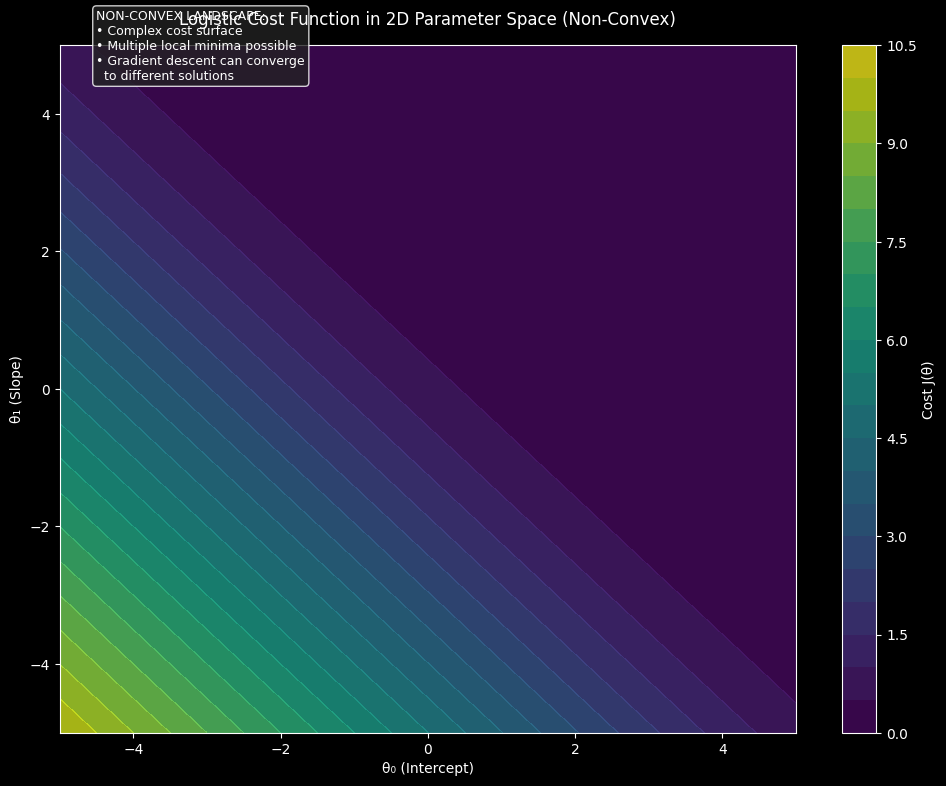

In [19]:
# Additional visualization: Show logistic cost in 2D parameter space
fig2, ax = plt.subplots(figsize=(10, 8), facecolor='black')
ax.set_facecolor('black')

# Create 2D parameter space for logistic regression
theta0 = np.linspace(-5, 5, 100)
theta1 = np.linspace(-5, 5, 100)
theta0_grid, theta1_grid = np.meshgrid(theta0, theta1)

# Simple logistic cost in 2D (for demonstration)
# J(θ) = log(1 + exp(-θᵀx)) for some fixed x
x_fixed = 1
z_grid = theta0_grid + theta1_grid * x_fixed
cost_grid = np.log(1 + np.exp(-z_grid))

# Plot contour
contour = ax.contourf(theta0_grid, theta1_grid, cost_grid, levels=20, cmap='viridis', alpha=0.8)
ax.set_xlabel('θ₀ (Intercept)', color='white')
ax.set_ylabel('θ₁ (Slope)', color='white')
ax.set_title('Logistic Cost Function in 2D Parameter Space (Non-Convex)', color='white', pad=15)
plt.colorbar(contour, ax=ax, label='Cost J(θ)')

# Show non-convex nature
ax.text(0.05, 0.95, "NON-CONVEX LANDSCAPE:\n• Complex cost surface\n• Multiple local minima possible\n• Gradient descent can converge\n  to different solutions", 
        transform=ax.transAxes, color='white', fontsize=9,
        bbox=dict(boxstyle='round', facecolor='#222222', alpha=0.8))

plt.tight_layout()
plt.show()

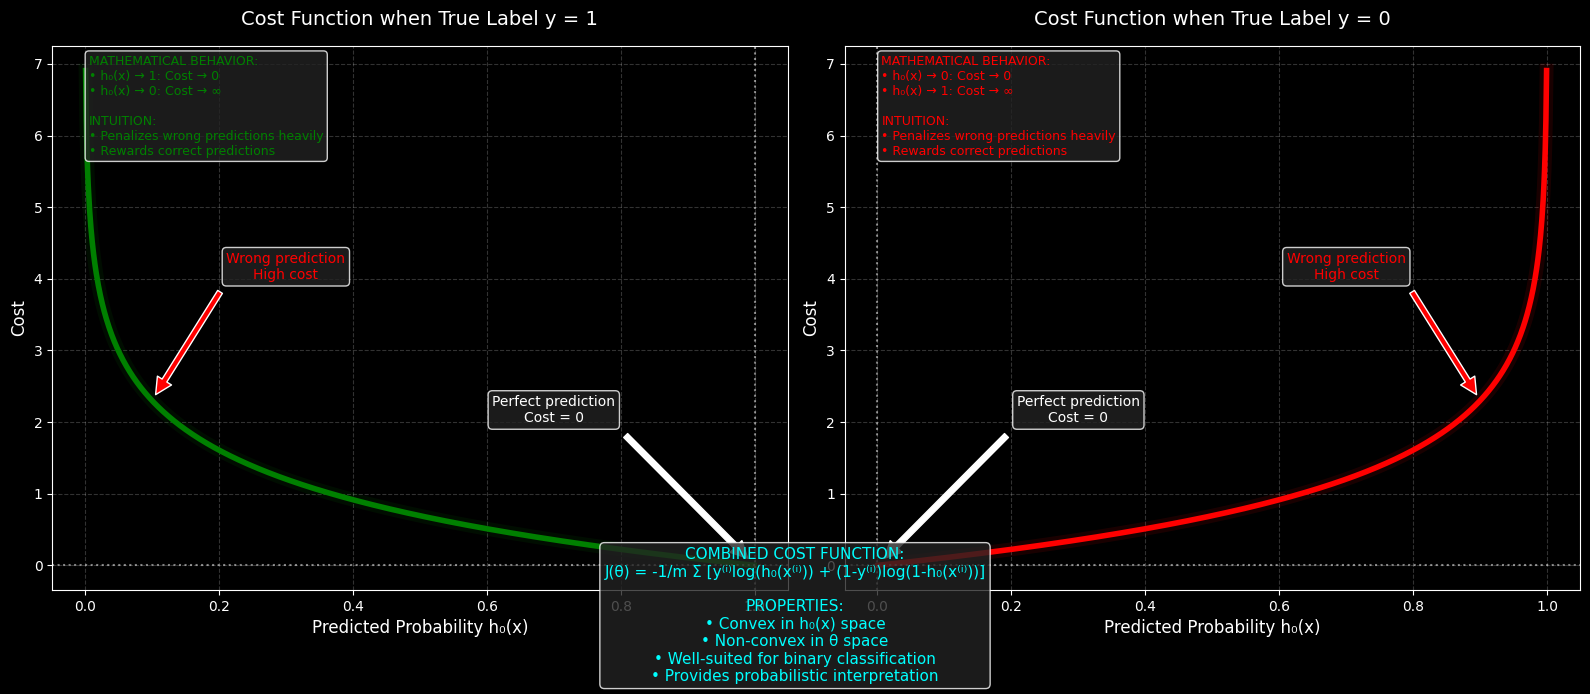

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Set dark theme
plt.style.use('dark_background')

# Define the cost functions
def cost_y1(h):  # When y = 1
    return -np.log(h)

def cost_y0(h):  # When y = 0
    return -np.log(1 - h)

# Create prediction values (probabilities)
h = np.linspace(0.001, 0.999, 1000)  # Avoid log(0) issues

# Calculate costs
cost_when_y1 = cost_y1(h)
cost_when_y0 = cost_y0(h)

# Create the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), facecolor='black')
ax1.set_facecolor('black')
ax2.set_facecolor('black')

# Plot 1: Cost when y = 1
ax1.plot(h, cost_when_y1, color='green', linewidth=4, label='Cost when y=1: -log(h₀(x))')
ax1.plot(h, cost_when_y1, color='green', linewidth=10, alpha=0.1)
ax1.set_xlabel('Predicted Probability h₀(x)', color='white', fontsize=12)
ax1.set_ylabel('Cost', color='white', fontsize=12)
ax1.set_title('Cost Function when True Label y = 1', color='white', pad=15, fontsize=14)
ax1.grid(True, ls='--', alpha=0.2, color='white')

# Highlight key regions
ax1.axvline(1.0, color='white', linestyle=':', alpha=0.5)
ax1.axhline(0, color='white', linestyle=':', alpha=0.5)

# Add annotations
ax1.annotate('Perfect prediction\nCost = 0', xy=(1.0, 0), xytext=(0.7, 2),
            color='white', fontsize=10, ha='center',
            arrowprops=dict(facecolor='white', shrink=0.05),
            bbox=dict(boxstyle='round', facecolor='#222222', alpha=0.8))

ax1.annotate('Wrong prediction\nHigh cost', xy=(0.1, 2.3), xytext=(0.3, 4),
            color='red', fontsize=10, ha='center',
            arrowprops=dict(facecolor='red', shrink=0.05),
            bbox=dict(boxstyle='round', facecolor='#222222', alpha=0.8))

# Add mathematical explanation
ax1.text(0.05, 0.8, "MATHEMATICAL BEHAVIOR:\n• h₀(x) → 1: Cost → 0\n• h₀(x) → 0: Cost → ∞\n\nINTUITION:\n• Penalizes wrong predictions heavily\n• Rewards correct predictions", 
         transform=ax1.transAxes, color='green', fontsize=9,
         bbox=dict(boxstyle='round', facecolor='#222222', alpha=0.8))

# Plot 2: Cost when y = 0
ax2.plot(h, cost_when_y0, color='red', linewidth=4, label='Cost when y=0: -log(1 - h₀(x))')
ax2.plot(h, cost_when_y0, color='red', linewidth=10, alpha=0.1)
ax2.set_xlabel('Predicted Probability h₀(x)', color='white', fontsize=12)
ax2.set_ylabel('Cost', color='white', fontsize=12)
ax2.set_title('Cost Function when True Label y = 0', color='white', pad=15, fontsize=14)
ax2.grid(True, ls='--', alpha=0.2, color='white')

# Highlight key regions
ax2.axvline(0.0, color='white', linestyle=':', alpha=0.5)
ax2.axhline(0, color='white', linestyle=':', alpha=0.5)

# Add annotations
ax2.annotate('Perfect prediction\nCost = 0', xy=(0.0, 0), xytext=(0.3, 2),
            color='white', fontsize=10, ha='center',
            arrowprops=dict(facecolor='white', shrink=0.05),
            bbox=dict(boxstyle='round', facecolor='#222222', alpha=0.8))

ax2.annotate('Wrong prediction\nHigh cost', xy=(0.9, 2.3), xytext=(0.7, 4),
            color='red', fontsize=10, ha='center',
            arrowprops=dict(facecolor='red', shrink=0.05),
            bbox=dict(boxstyle='round', facecolor='#222222', alpha=0.8))

# Add mathematical explanation
ax2.text(0.05, 0.8, "MATHEMATICAL BEHAVIOR:\n• h₀(x) → 0: Cost → 0\n• h₀(x) → 1: Cost → ∞\n\nINTUITION:\n• Penalizes wrong predictions heavily\n• Rewards correct predictions", 
         transform=ax2.transAxes, color='red', fontsize=9,
         bbox=dict(boxstyle='round', facecolor='#222222', alpha=0.8))

# Add combined cost function explanation
combined_text = (
    "COMBINED COST FUNCTION:\n"
    "J(θ) = -1/m Σ [y⁽ⁱ⁾log(h₀(x⁽ⁱ⁾)) + (1-y⁽ⁱ⁾)log(1-h₀(x⁽ⁱ⁾))]\n\n"
    "PROPERTIES:\n"
    "• Convex in h₀(x) space\n"
    "• Non-convex in θ space\n"
    "• Well-suited for binary classification\n"
    "• Provides probabilistic interpretation"
)

fig.text(0.5, 0.02, combined_text, ha='center', color='cyan', fontsize=11,
         bbox=dict(boxstyle='round', facecolor='#222222', alpha=0.8))

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()


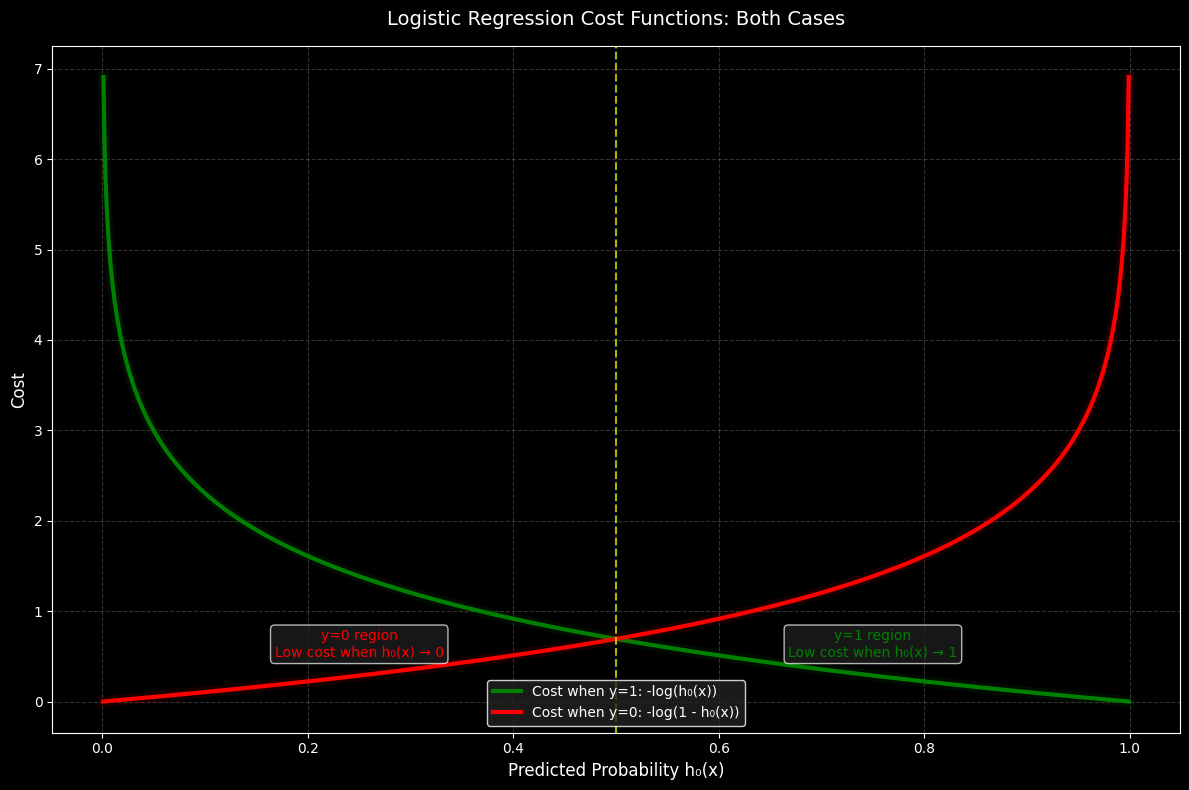

In [22]:
# Additional visualization: Show both costs together
fig2, ax = plt.subplots(figsize=(12, 8), facecolor='black')
ax.set_facecolor('black')

ax.plot(h, cost_when_y1, color='green', linewidth=3, label='Cost when y=1: -log(h₀(x))')
ax.plot(h, cost_when_y0, color='red', linewidth=3, label='Cost when y=0: -log(1 - h₀(x))')
ax.plot(h, cost_when_y1, color='green', linewidth=8, alpha=0.1)
ax.plot(h, cost_when_y0, color='red', linewidth=8, alpha=0.1)

ax.set_xlabel('Predicted Probability h₀(x)', color='white', fontsize=12)
ax.set_ylabel('Cost', color='white', fontsize=12)
ax.set_title('Logistic Regression Cost Functions: Both Cases', color='white', pad=15, fontsize=14)
ax.grid(True, ls='--', alpha=0.2, color='white')
ax.legend(facecolor='#222222', edgecolor='white', labelcolor='white')

# Add decision boundary
ax.axvline(0.5, color='yellow', linestyle='--', alpha=0.7, label='Decision Boundary (0.5)')

# Add region annotations
ax.text(0.75, 0.5, 'y=1 region\nLow cost when h₀(x) → 1', color='green', ha='center',
        fontsize=10, bbox=dict(boxstyle='round', facecolor='#222222', alpha=0.7))
ax.text(0.25, 0.5, 'y=0 region\nLow cost when h₀(x) → 0', color='red', ha='center',
        fontsize=10, bbox=dict(boxstyle='round', facecolor='#222222', alpha=0.7))

plt.tight_layout()
plt.show()

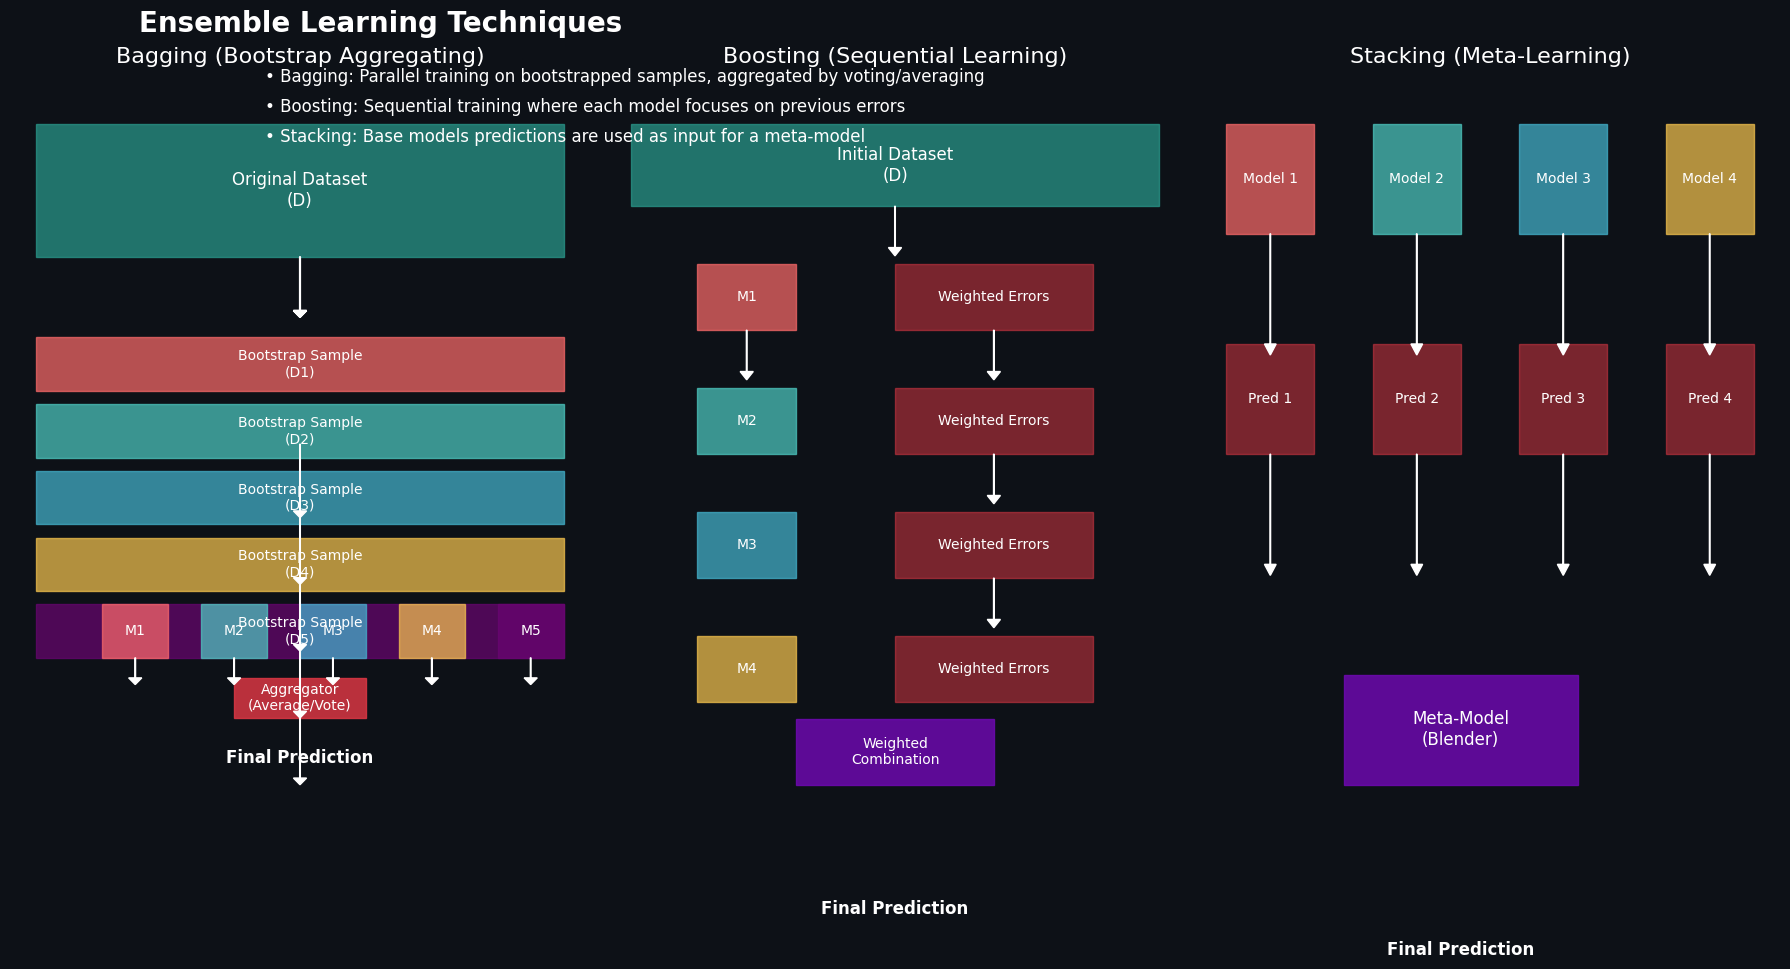

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle, FancyBboxPatch, Circle, Arrow
from matplotlib.colors import LinearSegmentedColormap

# Set dark background
plt.style.use('dark_background')

# Create figure
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 10))
fig.patch.set_facecolor('#0d1117')
for ax in [ax1, ax2, ax3]:
    ax.set_facecolor('#0d1117')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

# Colors
colors = ['#ff6b6b', '#4ecdc4', '#45b7d1', '#f9c74f', '#6a0572', '#ff9f1c']

# 1. Bagging (Bootstrap Aggregating)
ax1.set_title('Bagging (Bootstrap Aggregating)', color='white', fontsize=16, pad=20)

# Draw original dataset
ax1.add_patch(Rectangle((0.1, 0.7), 0.8, 0.2, fill=True, color='#2a9d8f', alpha=0.7))
ax1.text(0.5, 0.8, 'Original Dataset\n(D)', ha='center', va='center', color='white', fontsize=12)

# Draw bootstrap samples
for i in range(5):
    y_pos = 0.5 - i * 0.1
    ax1.add_patch(Rectangle((0.1, y_pos), 0.8, 0.08, fill=True, color=colors[i % len(colors)], alpha=0.7))
    ax1.text(0.5, y_pos + 0.04, f'Bootstrap Sample\n(D{i+1})', ha='center', va='center', color='white', fontsize=10)

# Draw models
for i in range(5):
    x_pos = 0.2 + i * 0.15
    ax1.add_patch(Rectangle((x_pos, 0.1), 0.1, 0.08, fill=True, color=colors[i % len(colors)], alpha=0.7))
    ax1.text(x_pos + 0.05, 0.14, f'M{i+1}', ha='center', va='center', color='white', fontsize=10)

# Draw aggregator
ax1.add_patch(Rectangle((0.4, 0.01), 0.2, 0.06, fill=True, color='#e63946', alpha=0.8))
ax1.text(0.5, 0.04, 'Aggregator\n(Average/Vote)', ha='center', va='center', color='white', fontsize=10)

# Draw arrows
for i in range(5):
    # From dataset to bootstrap samples
    ax1.arrow(0.5, 0.7, 0, -0.08, head_width=0.02, head_length=0.01, fc='white', ec='white')
    # From bootstrap samples to models
    ax1.arrow(0.5, 0.42 - i * 0.1, 0, -0.1, head_width=0.02, head_length=0.01, fc='white', ec='white')
    # From models to aggregator
    ax1.arrow(0.2 + i * 0.15 + 0.05, 0.1, 0, -0.03, head_width=0.02, head_length=0.01, fc='white', ec='white')

# Final prediction
ax1.text(0.5, -0.05, 'Final Prediction', ha='center', va='center', color='white', fontsize=12, weight='bold')

# 2. Boosting
ax2.set_title('Boosting (Sequential Learning)', color='white', fontsize=16, pad=20)

# Draw initial dataset
ax2.add_patch(Rectangle((0.1, 0.8), 0.8, 0.1, fill=True, color='#2a9d8f', alpha=0.7))
ax2.text(0.5, 0.85, 'Initial Dataset\n(D)', ha='center', va='center', color='white', fontsize=12)

# Draw sequential process
for i in range(4):
    y_pos = 0.65 - i * 0.15
    # Model
    ax2.add_patch(Rectangle((0.2, y_pos), 0.15, 0.08, fill=True, color=colors[i % len(colors)], alpha=0.7))
    ax2.text(0.275, y_pos + 0.04, f'M{i+1}', ha='center', va='center', color='white', fontsize=10)
    
    # Errors
    ax2.add_patch(Rectangle((0.5, y_pos), 0.3, 0.08, fill=True, color='#e63946', alpha=0.5))
    ax2.text(0.65, y_pos + 0.04, 'Weighted Errors', ha='center', va='center', color='white', fontsize=10)
    
    # Arrow to next model
    if i < 3:
        ax2.arrow(0.65, y_pos, 0, -0.05, head_width=0.02, head_length=0.01, fc='white', ec='white')

# Final model
ax2.add_patch(Rectangle((0.35, 0.1), 0.3, 0.08, fill=True, color='#7209b7', alpha=0.8))
ax2.text(0.5, 0.14, 'Weighted\nCombination', ha='center', va='center', color='white', fontsize=10)

# Draw arrows
ax2.arrow(0.5, 0.8, 0, -0.05, head_width=0.02, head_length=0.01, fc='white', ec='white')
ax2.arrow(0.275, 0.65, 0, -0.05, head_width=0.02, head_length=0.01, fc='white', ec='white')

# Final prediction
ax2.text(0.5, -0.05, 'Final Prediction', ha='center', va='center', color='white', fontsize=12, weight='bold')

# 3. Stacking
ax3.set_title('Stacking (Meta-Learning)', color='white', fontsize=16, pad=20)

# Draw base models
for i in range(4):
    x_pos = 0.1 + i * 0.25
    ax3.add_patch(Rectangle((x_pos, 0.7), 0.15, 0.1, fill=True, color=colors[i % len(colors)], alpha=0.7))
    ax3.text(x_pos + 0.075, 0.75, f'Model {i+1}', ha='center', va='center', color='white', fontsize=10)

# Draw predictions
for i in range(4):
    x_pos = 0.1 + i * 0.25
    ax3.add_patch(Rectangle((x_pos, 0.5), 0.15, 0.1, fill=True, color='#e63946', alpha=0.5))
    ax3.text(x_pos + 0.075, 0.55, f'Pred {i+1}', ha='center', va='center', color='white', fontsize=10)

# Draw meta-model
ax3.add_patch(Rectangle((0.3, 0.2), 0.4, 0.1, fill=True, color='#7209b7', alpha=0.8))
ax3.text(0.5, 0.25, 'Meta-Model\n(Blender)', ha='center', va='center', color='white', fontsize=12)

# Draw arrows
for i in range(4):
    x_pos = 0.1 + i * 0.25 + 0.075
    ax3.arrow(x_pos, 0.7, 0, -0.1, head_width=0.02, head_length=0.01, fc='white', ec='white')
    ax3.arrow(x_pos, 0.5, 0, -0.1, head_width=0.02, head_length=0.01, fc='white', ec='white')

# Final prediction
ax3.text(0.5, 0.05, 'Final Prediction', ha='center', va='center', color='white', fontsize=12, weight='bold')

# Add descriptions
fig.text(0.08, 0.95, 'Ensemble Learning Techniques', fontsize=20, color='white', weight='bold')
fig.text(0.15, 0.90, '• Bagging: Parallel training on bootstrapped samples, aggregated by voting/averaging', fontsize=12, color='white')
fig.text(0.15, 0.87, '• Boosting: Sequential training where each model focuses on previous errors', fontsize=12, color='white')
fig.text(0.15, 0.84, '• Stacking: Base models predictions are used as input for a meta-model', fontsize=12, color='white')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

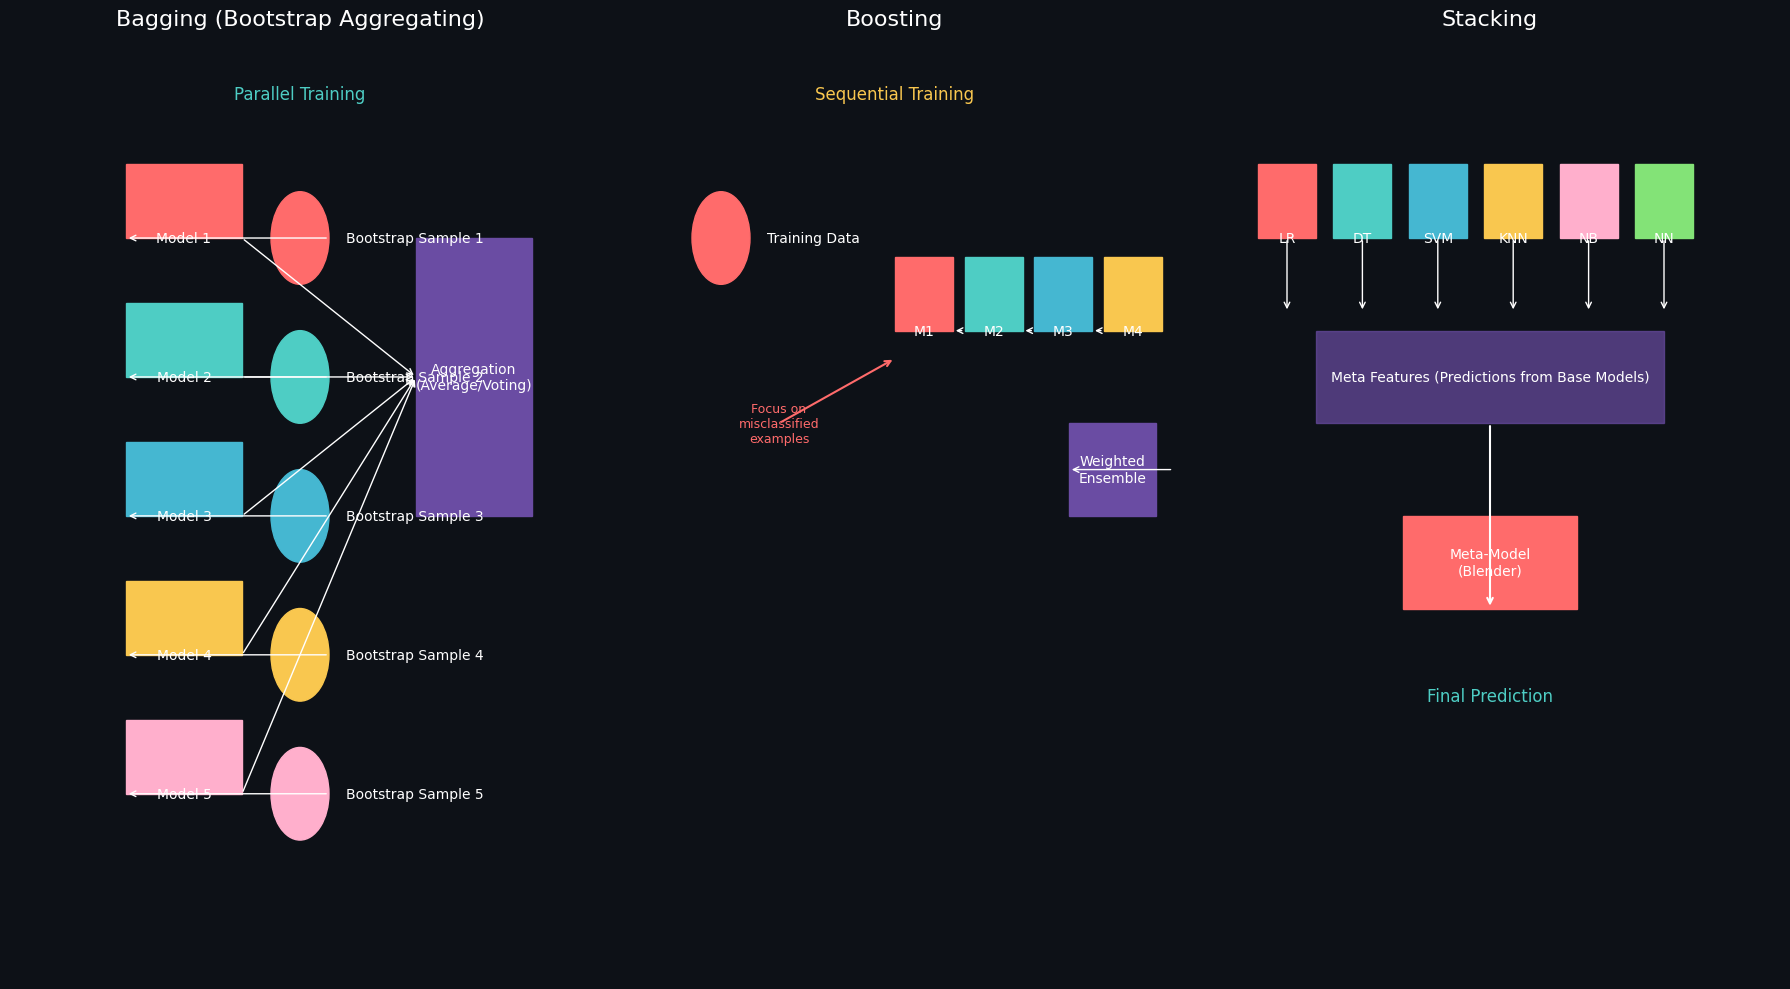

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle, FancyBboxPatch, Circle, Arrow
from matplotlib.colors import LinearSegmentedColormap

# Set dark background
plt.style.use('dark_background')

# Create figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 10))
fig.patch.set_facecolor('#0d1117')
for ax in [ax1, ax2, ax3]:
    ax.set_facecolor('#0d1117')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

# Colors
colors = ['#ff6b6b', '#4ecdc4', '#45b7d1', '#f9c74f', '#ffafcc', '#83e377']

# 1. Bagging (Bootstrap Aggregating)
ax1.set_title('Bagging (Bootstrap Aggregating)', color='white', fontsize=16, pad=20)

# Draw bootstrap samples
for i in range(5):
    circle = plt.Circle((0.5, 0.8 - i*0.15), 0.05, color=colors[i % len(colors)])
    ax1.add_patch(circle)
    ax1.text(0.58, 0.8 - i*0.15, f'Bootstrap Sample {i+1}', color='white', 
             fontsize=10, va='center')

# Draw models
for i in range(5):
    ax1.add_patch(Rectangle((0.2, 0.8 - i*0.15), 0.2, 0.08, color=colors[i % len(colors)]))
    ax1.text(0.3, 0.8 - i*0.15, f'Model {i+1}', color='white', 
             fontsize=10, ha='center', va='center')

# Draw arrows from samples to models
for i in range(5):
    ax1.annotate('', xy=(0.2, 0.8 - i*0.15), xytext=(0.55, 0.8 - i*0.15),
                arrowprops=dict(arrowstyle='->', color='white', lw=1))

# Draw aggregation
ax1.add_patch(Rectangle((0.7, 0.5), 0.2, 0.3, color='#6a4ca3'))
ax1.text(0.8, 0.65, 'Aggregation\n(Average/Voting)', color='white', 
         fontsize=10, ha='center', va='center')

# Draw arrows from models to aggregation
for i in range(5):
    ax1.annotate('', xy=(0.7, 0.65), xytext=(0.4, 0.8 - i*0.15),
                arrowprops=dict(arrowstyle='->', color='white', lw=1))

ax1.text(0.5, 0.95, 'Parallel Training', color='#4ecdc4', fontsize=12, ha='center')
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)

# 2. Boosting
ax2.set_title('Boosting', color='white', fontsize=16, pad=20)

# Draw sequential training
ax2.text(0.5, 0.95, 'Sequential Training', color='#f9c74f', fontsize=12, ha='center')

# Draw data
ax2.add_patch(plt.Circle((0.2, 0.8), 0.05, color=colors[0]))
ax2.text(0.28, 0.8, 'Training Data', color='white', fontsize=10, va='center')

# Draw models with arrows between them
for i in range(4):
    ax2.add_patch(Rectangle((0.5 + i*0.12, 0.7), 0.1, 0.08, color=colors[i % len(colors)]))
    ax2.text(0.55 + i*0.12, 0.7, f'M{i+1}', color='white', 
             fontsize=10, ha='center', va='center')
    
    if i < 3:
        ax2.annotate('', xy=(0.6 + i*0.12, 0.7), xytext=(0.5 + (i+1)*0.12, 0.7),
                    arrowprops=dict(arrowstyle='->', color='white', lw=1))

# Draw error focus
ax2.text(0.3, 0.6, 'Focus on\nmisclassified\nexamples', color='#ff6b6b', 
         fontsize=9, ha='center', va='center')
ax2.annotate('', xy=(0.5, 0.67), xytext=(0.3, 0.6),
            arrowprops=dict(arrowstyle='->', color='#ff6b6b', lw=1.5))

# Draw final model
ax2.add_patch(Rectangle((0.8, 0.5), 0.15, 0.1, color='#6a4ca3'))
ax2.text(0.875, 0.55, 'Weighted\nEnsemble', color='white', 
         fontsize=10, ha='center', va='center')

ax2.annotate('', xy=(0.8, 0.55), xytext=(0.98, 0.55),
            arrowprops=dict(arrowstyle='->', color='white', lw=1))

ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)

# 3. Stacking
ax3.set_title('Stacking', color='white', fontsize=16, pad=20)

# Draw base models
model_names = ['LR', 'DT', 'SVM', 'KNN', 'NB', 'NN']
for i in range(6):
    ax3.add_patch(Rectangle((0.1 + i*0.13, 0.8), 0.1, 0.08, color=colors[i % len(colors)]))
    ax3.text(0.15 + i*0.13, 0.8, model_names[i], color='white', 
             fontsize=10, ha='center', va='center')

# Draw predictions arrows
for i in range(6):
    ax3.annotate('', xy=(0.15 + i*0.13, 0.72), xytext=(0.15 + i*0.13, 0.8),
                arrowprops=dict(arrowstyle='->', color='white', lw=1))

# Draw meta features
ax3.add_patch(Rectangle((0.2, 0.6), 0.6, 0.1, color='#6a4ca3', alpha=0.7))
ax3.text(0.5, 0.65, 'Meta Features (Predictions from Base Models)', color='white', 
         fontsize=10, ha='center', va='center')

# Draw meta model
ax3.add_patch(Rectangle((0.35, 0.4), 0.3, 0.1, color='#ff6b6b'))
ax3.text(0.5, 0.45, 'Meta-Model\n(Blender)', color='white', 
         fontsize=10, ha='center', va='center')

ax3.annotate('', xy=(0.5, 0.4), xytext=(0.5, 0.6),
            arrowprops=dict(arrowstyle='->', color='white', lw=1.5))

# Draw final prediction
ax3.text(0.5, 0.3, 'Final Prediction', color='#4ecdc4', fontsize=12, ha='center')

ax3.set_xlim(0, 1)
ax3.set_ylim(0, 1)

plt.tight_layout()
plt.show()

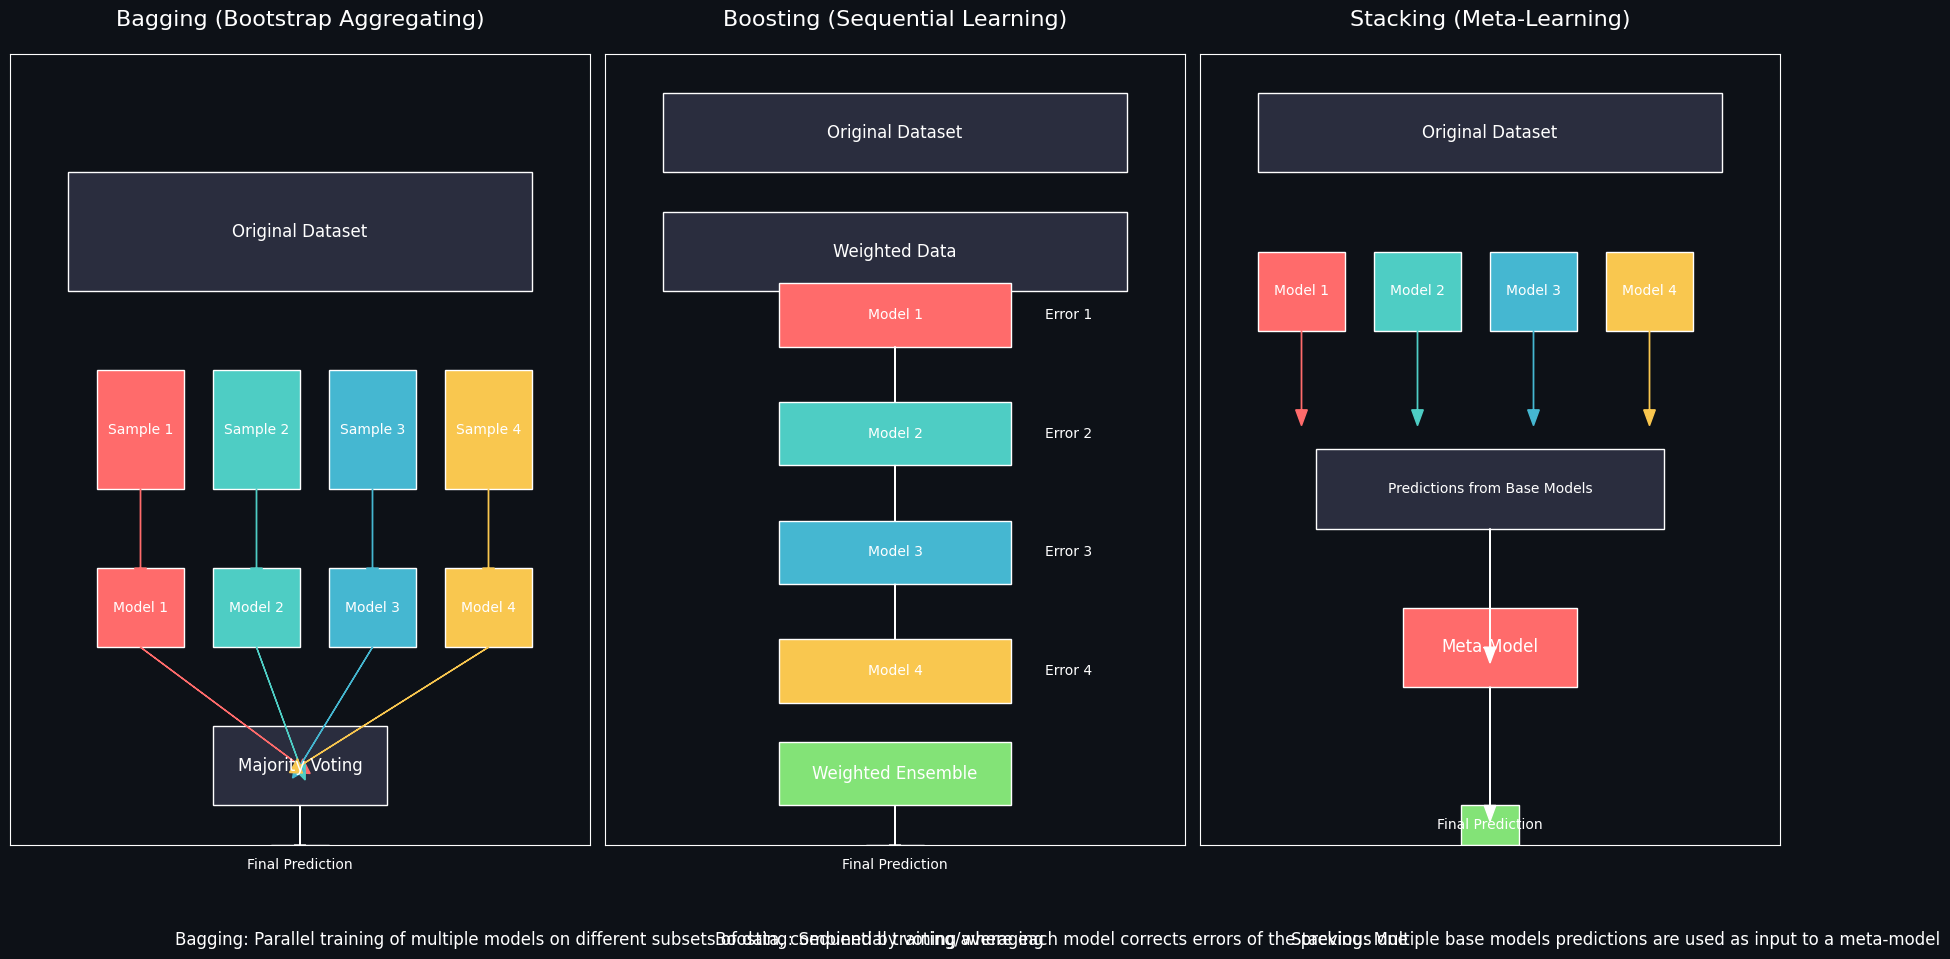

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle, FancyBboxPatch, Circle, Arrow
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches

# Set dark theme
plt.style.use('dark_background')

# Create figure
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 10))
fig.patch.set_facecolor('#0d1117')
for ax in [ax1, ax2, ax3]:
    ax.set_facecolor('#0d1117')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)

# Colors
colors = ['#ff6b6b', '#4ecdc4', '#45b7d1', '#f9c74f', '#ffafcc', '#83e377']
model_colors = ['#ff6b6b', '#4ecdc4', '#45b7d1', '#f9c74f']

# ========== BAGGING ==========
ax1.set_title('Bagging (Bootstrap Aggregating)', color='white', fontsize=16, pad=20)

# Draw original dataset
ax1.add_patch(Rectangle((1, 7), 8, 1.5, facecolor='#2a2d3e', edgecolor='white', lw=1))
ax1.text(5, 7.75, 'Original Dataset', ha='center', va='center', color='white', fontsize=12)

# Draw bootstrap samples
for i in range(4):
    ax1.add_patch(Rectangle((1.5 + i*2, 4.5), 1.5, 1.5, facecolor=colors[i], edgecolor='white', lw=1))
    ax1.text(2.25 + i*2, 5.25, f'Sample {i+1}', ha='center', va='center', color='white', fontsize=10)

# Draw models
for i in range(4):
    ax1.add_patch(Rectangle((1.5 + i*2, 2.5), 1.5, 1, facecolor=model_colors[i], edgecolor='white', lw=1))
    ax1.text(2.25 + i*2, 3, f'Model {i+1}', ha='center', va='center', color='white', fontsize=10)

# Draw arrows
for i in range(4):
    ax1.arrow(2.25 + i*2, 4.5, 0, -1, head_width=0.2, head_length=0.2, fc=colors[i], ec=colors[i])

# Draw voting mechanism
ax1.add_patch(Rectangle((3.5, 0.5), 3, 1, facecolor='#2a2d3e', edgecolor='white', lw=1))
ax1.text(5, 1, 'Majority Voting', ha='center', va='center', color='white', fontsize=12)

# Draw arrows from models to voting
for i in range(4):
    ax1.arrow(2.25 + i*2, 2.5, 5 - (2.25 + i*2), -1.5, head_width=0.2, head_length=0.2, fc=model_colors[i], ec=model_colors[i])

# Draw final prediction
ax1.add_patch(Rectangle((4.5, -0.5), 1, 0.5, facecolor='#83e377', edgecolor='white', lw=1))
ax1.text(5, -0.25, 'Final Prediction', ha='center', va='center', color='white', fontsize=10)
ax1.arrow(5, 0.5, 0, -0.5, head_width=0.2, head_length=0.1, fc='white', ec='white')

# ========== BOOSTING ==========
ax2.set_title('Boosting (Sequential Learning)', color='white', fontsize=16, pad=20)

# Draw original dataset
ax2.add_patch(Rectangle((1, 8.5), 8, 1, facecolor='#2a2d3e', edgecolor='white', lw=1))
ax2.text(5, 9, 'Original Dataset', ha='center', va='center', color='white', fontsize=12)

# Draw data with weights
ax2.add_patch(Rectangle((1, 7), 8, 1, facecolor='#2a2d3e', edgecolor='white', lw=1))
ax2.text(5, 7.5, 'Weighted Data', ha='center', va='center', color='white', fontsize=12)

# Draw arrows showing sequential process
y_pos = 6.5
for i in range(4):
    # Model
    ax2.add_patch(Rectangle((3, y_pos - 0.2), 4, 0.8, facecolor=model_colors[i], edgecolor='white', lw=1))
    ax2.text(5, y_pos + 0.2, f'Model {i+1}', ha='center', va='center', color='white', fontsize=10)
    
    # Error calculation
    ax2.text(8, y_pos + 0.2, f'Error {i+1}', ha='center', va='center', color='white', fontsize=10)
    
    # Arrow to next
    if i < 3:
        ax2.arrow(5, y_pos - 0.2, 0, -1, head_width=0.2, head_length=0.2, fc='white', ec='white')
    
    y_pos -= 1.5

# Draw final ensemble
ax2.add_patch(Rectangle((3, 0.5), 4, 0.8, facecolor='#83e377', edgecolor='white', lw=1))
ax2.text(5, 0.9, 'Weighted Ensemble', ha='center', va='center', color='white', fontsize=12)

# Draw final prediction
ax2.add_patch(Rectangle((4.5, -0.5), 1, 0.5, facecolor='#83e377', edgecolor='white', lw=1))
ax2.text(5, -0.25, 'Final Prediction', ha='center', va='center', color='white', fontsize=10)
ax2.arrow(5, 0.5, 0, -0.5, head_width=0.2, head_length=0.1, fc='white', ec='white')

# ========== STACKING ==========
ax3.set_title('Stacking (Meta-Learning)', color='white', fontsize=16, pad=20)

# Draw original dataset
ax3.add_patch(Rectangle((1, 8.5), 8, 1, facecolor='#2a2d3e', edgecolor='white', lw=1))
ax3.text(5, 9, 'Original Dataset', ha='center', va='center', color='white', fontsize=12)

# Draw base models
for i in range(4):
    ax3.add_patch(Rectangle((1 + i*2, 6.5), 1.5, 1, facecolor=model_colors[i], edgecolor='white', lw=1))
    ax3.text(1.75 + i*2, 7, f'Model {i+1}', ha='center', va='center', color='white', fontsize=10)
    ax3.arrow(1.75 + i*2, 6.5, 0, -1, head_width=0.2, head_length=0.2, fc=model_colors[i], ec=model_colors[i])

# Draw predictions as input to meta-model
ax3.add_patch(Rectangle((2, 4), 6, 1, facecolor='#2a2d3e', edgecolor='white', lw=1))
ax3.text(5, 4.5, 'Predictions from Base Models', ha='center', va='center', color='white', fontsize=10)

# Draw meta-model
ax3.add_patch(Rectangle((3.5, 2), 3, 1, facecolor='#ff6b6b', edgecolor='white', lw=1))
ax3.text(5, 2.5, 'Meta-Model', ha='center', va='center', color='white', fontsize=12)
ax3.arrow(5, 4, 0, -1.5, head_width=0.2, head_length=0.2, fc='white', ec='white')

# Draw final prediction
ax3.add_patch(Rectangle((4.5, 0), 1, 0.5, facecolor='#83e377', edgecolor='white', lw=1))
ax3.text(5, 0.25, 'Final Prediction', ha='center', va='center', color='white', fontsize=10)
ax3.arrow(5, 2, 0, -1.5, head_width=0.2, head_length=0.2, fc='white', ec='white')

# Add descriptions
fig.text(0.1, 0.05, 'Bagging: Parallel training of multiple models on different subsets of data, combined by voting/averaging', 
         color='white', fontsize=12)
fig.text(0.4, 0.05, 'Boosting: Sequential training where each model corrects errors of the previous one', 
         color='white', fontsize=12)
fig.text(0.72, 0.05, 'Stacking: Multiple base models predictions are used as input to a meta-model', 
         color='white', fontsize=12)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()

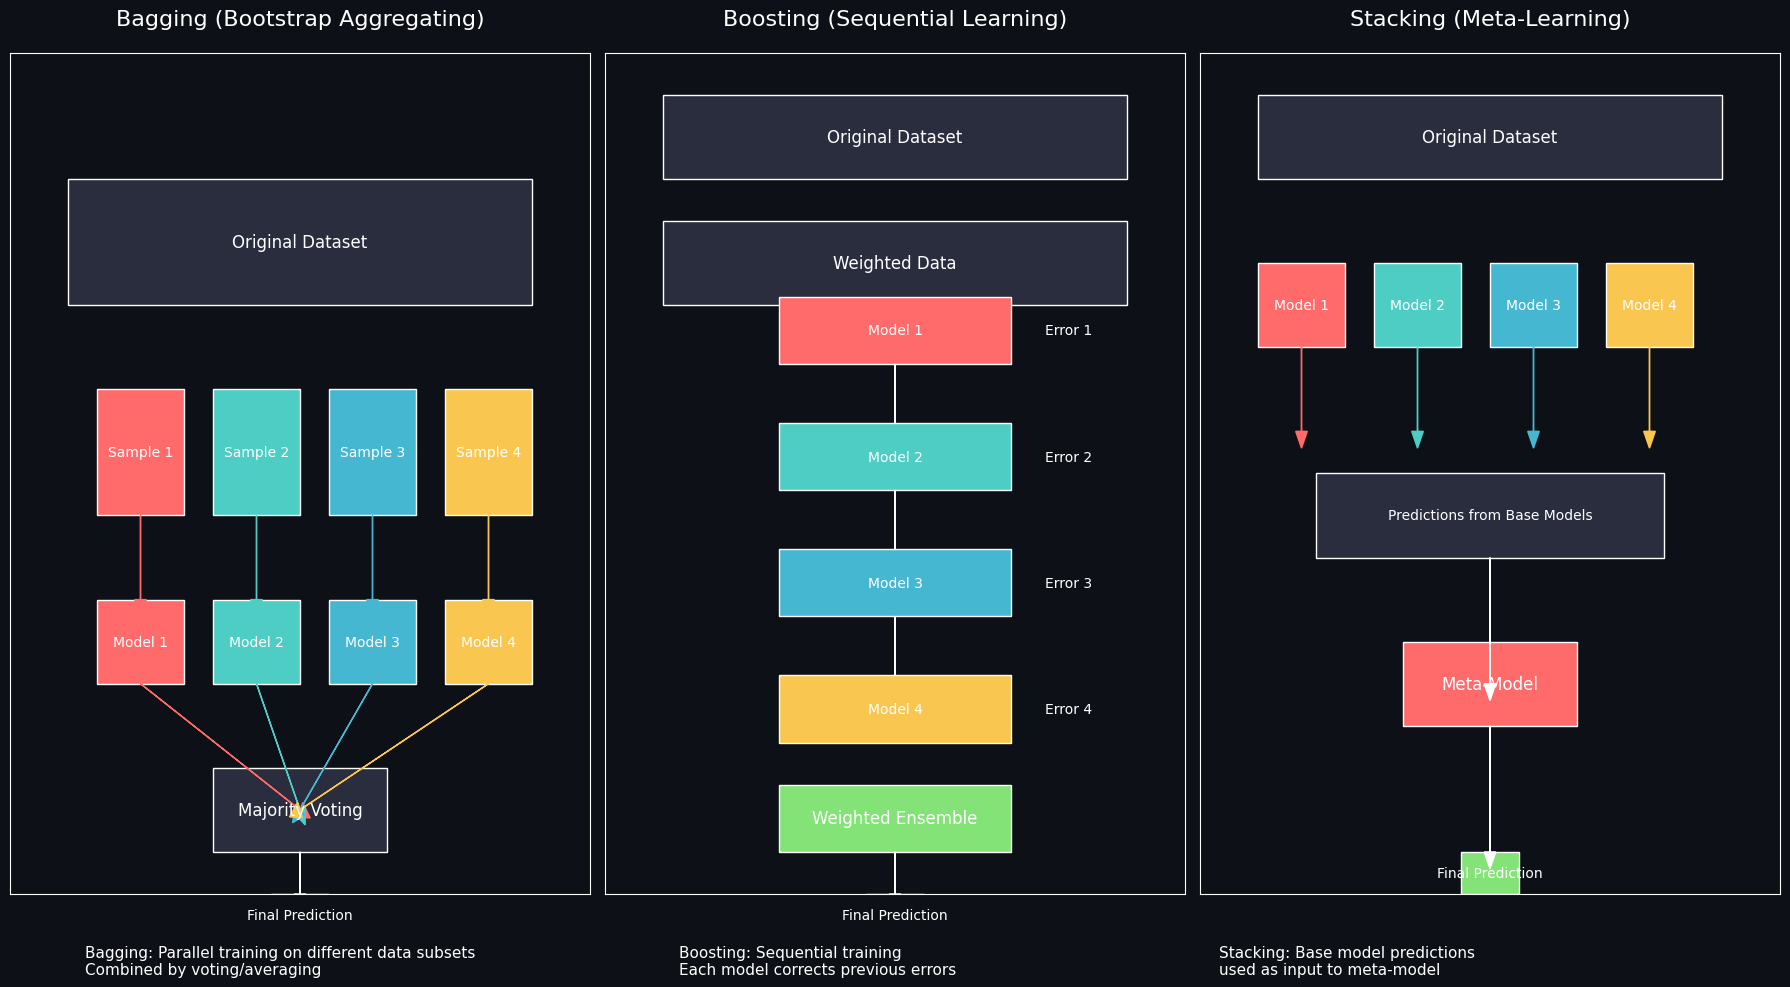

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle, FancyBboxPatch, Circle, Arrow
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches

# Set dark theme
plt.style.use('dark_background')

# Create figure with more vertical space
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 10))
fig.patch.set_facecolor('#0d1117')
for ax in [ax1, ax2, ax3]:
    ax.set_facecolor('#0d1117')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)

# Colors
colors = ['#ff6b6b', '#4ecdc4', '#45b7d1', '#f9c74f', '#ffafcc', '#83e377']
model_colors = ['#ff6b6b', '#4ecdc4', '#45b7d1', '#f9c74f']

# ========== BAGGING ==========
ax1.set_title('Bagging (Bootstrap Aggregating)', color='white', fontsize=16, pad=20)

# Draw original dataset
ax1.add_patch(Rectangle((1, 7), 8, 1.5, facecolor='#2a2d3e', edgecolor='white', lw=1))
ax1.text(5, 7.75, 'Original Dataset', ha='center', va='center', color='white', fontsize=12)

# Draw bootstrap samples
for i in range(4):
    ax1.add_patch(Rectangle((1.5 + i*2, 4.5), 1.5, 1.5, facecolor=colors[i], edgecolor='white', lw=1))
    ax1.text(2.25 + i*2, 5.25, f'Sample {i+1}', ha='center', va='center', color='white', fontsize=10)

# Draw models
for i in range(4):
    ax1.add_patch(Rectangle((1.5 + i*2, 2.5), 1.5, 1, facecolor=model_colors[i], edgecolor='white', lw=1))
    ax1.text(2.25 + i*2, 3, f'Model {i+1}', ha='center', va='center', color='white', fontsize=10)

# Draw arrows
for i in range(4):
    ax1.arrow(2.25 + i*2, 4.5, 0, -1, head_width=0.2, head_length=0.2, fc=colors[i], ec=colors[i])

# Draw voting mechanism
ax1.add_patch(Rectangle((3.5, 0.5), 3, 1, facecolor='#2a2d3e', edgecolor='white', lw=1))
ax1.text(5, 1, 'Majority Voting', ha='center', va='center', color='white', fontsize=12)

# Draw arrows from models to voting
for i in range(4):
    ax1.arrow(2.25 + i*2, 2.5, 5 - (2.25 + i*2), -1.5, head_width=0.2, head_length=0.2, fc=model_colors[i], ec=model_colors[i])

# Draw final prediction
ax1.add_patch(Rectangle((4.5, -0.5), 1, 0.5, facecolor='#83e377', edgecolor='white', lw=1))
ax1.text(5, -0.25, 'Final Prediction', ha='center', va='center', color='white', fontsize=10)
ax1.arrow(5, 0.5, 0, -0.5, head_width=0.2, head_length=0.1, fc='white', ec='white')

# ========== BOOSTING ==========
ax2.set_title('Boosting (Sequential Learning)', color='white', fontsize=16, pad=20)

# Draw original dataset
ax2.add_patch(Rectangle((1, 8.5), 8, 1, facecolor='#2a2d3e', edgecolor='white', lw=1))
ax2.text(5, 9, 'Original Dataset', ha='center', va='center', color='white', fontsize=12)

# Draw data with weights
ax2.add_patch(Rectangle((1, 7), 8, 1, facecolor='#2a2d3e', edgecolor='white', lw=1))
ax2.text(5, 7.5, 'Weighted Data', ha='center', va='center', color='white', fontsize=12)

# Draw arrows showing sequential process
y_pos = 6.5
for i in range(4):
    # Model
    ax2.add_patch(Rectangle((3, y_pos - 0.2), 4, 0.8, facecolor=model_colors[i], edgecolor='white', lw=1))
    ax2.text(5, y_pos + 0.2, f'Model {i+1}', ha='center', va='center', color='white', fontsize=10)
    
    # Error calculation
    ax2.text(8, y_pos + 0.2, f'Error {i+1}', ha='center', va='center', color='white', fontsize=10)
    
    # Arrow to next
    if i < 3:
        ax2.arrow(5, y_pos - 0.2, 0, -1, head_width=0.2, head_length=0.2, fc='white', ec='white')
    
    y_pos -= 1.5

# Draw final ensemble
ax2.add_patch(Rectangle((3, 0.5), 4, 0.8, facecolor='#83e377', edgecolor='white', lw=1))
ax2.text(5, 0.9, 'Weighted Ensemble', ha='center', va='center', color='white', fontsize=12)

# Draw final prediction
ax2.add_patch(Rectangle((4.5, -0.5), 1, 0.5, facecolor='#83e377', edgecolor='white', lw=1))
ax2.text(5, -0.25, 'Final Prediction', ha='center', va='center', color='white', fontsize=10)
ax2.arrow(5, 0.5, 0, -0.5, head_width=0.2, head_length=0.1, fc='white', ec='white')

# ========== STACKING ==========
ax3.set_title('Stacking (Meta-Learning)', color='white', fontsize=16, pad=20)

# Draw original dataset
ax3.add_patch(Rectangle((1, 8.5), 8, 1, facecolor='#2a2d3e', edgecolor='white', lw=1))
ax3.text(5, 9, 'Original Dataset', ha='center', va='center', color='white', fontsize=12)

# Draw base models
for i in range(4):
    ax3.add_patch(Rectangle((1 + i*2, 6.5), 1.5, 1, facecolor=model_colors[i], edgecolor='white', lw=1))
    ax3.text(1.75 + i*2, 7, f'Model {i+1}', ha='center', va='center', color='white', fontsize=10)
    ax3.arrow(1.75 + i*2, 6.5, 0, -1, head_width=0.2, head_length=0.2, fc=model_colors[i], ec=model_colors[i])

# Draw predictions as input to meta-model
ax3.add_patch(Rectangle((2, 4), 6, 1, facecolor='#2a2d3e', edgecolor='white', lw=1))
ax3.text(5, 4.5, 'Predictions from Base Models', ha='center', va='center', color='white', fontsize=10)

# Draw meta-model
ax3.add_patch(Rectangle((3.5, 2), 3, 1, facecolor='#ff6b6b', edgecolor='white', lw=1))
ax3.text(5, 2.5, 'Meta-Model', ha='center', va='center', color='white', fontsize=12)
ax3.arrow(5, 4, 0, -1.5, head_width=0.2, head_length=0.2, fc='white', ec='white')

# Draw final prediction
ax3.add_patch(Rectangle((4.5, 0), 1, 0.5, facecolor='#83e377', edgecolor='white', lw=1))
ax3.text(5, 0.25, 'Final Prediction', ha='center', va='center', color='white', fontsize=10)
ax3.arrow(5, 2, 0, -1.5, head_width=0.2, head_length=0.2, fc='white', ec='white')

# Add descriptions with better spacing
fig.text(0.05, 0.02, 'Bagging: Parallel training on different data subsets\nCombined by voting/averaging', 
         color='white', fontsize=11, ha='left')
fig.text(0.38, 0.02, 'Boosting: Sequential training\nEach model corrects previous errors', 
         color='white', fontsize=11, ha='left')
fig.text(0.68, 0.02, 'Stacking: Base model predictions\nused as input to meta-model', 
         color='white', fontsize=11, ha='left')

# Adjust layout to create more space at the bottom
plt.tight_layout()
plt.subplots_adjust(bottom=0.10)  # Increased from 0.15 to 0.12 to create more space
plt.show()

In [11]:
!pip install pygame

   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   ------ --------------------------------- 1.8/10.6 MB 10.1 MB/s eta 0:00:01
   -------------- ------------------------- 3.9/10.6 MB 10.2 MB/s eta 0:00:01
   ----------------------- ---------------- 6.3/10.6 MB 10.4 MB/s eta 0:00:01
   --------------------------------- ------ 8.9/10.6 MB 10.7 MB/s eta 0:00:01
   ---------------------------------------- 10.6/10.6 MB 10.2 MB/s eta 0:00:00



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


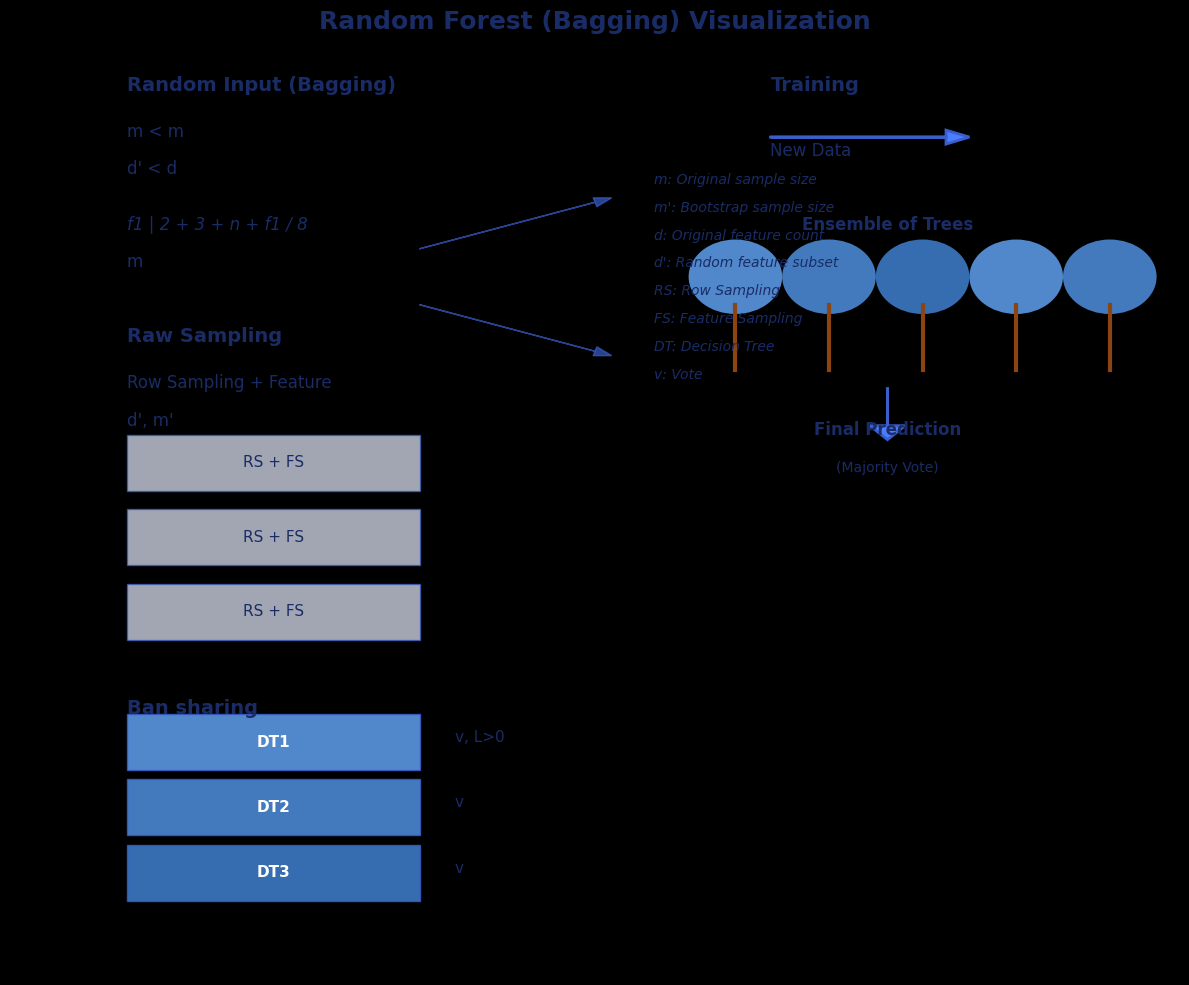

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle, FancyArrow, Circle, Arrow
from matplotlib.patches import FancyBboxPatch
from matplotlib.collections import PatchCollection
import matplotlib.patches as patches

# Set up the figure
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.axis('off')

# Colors
bg_color = '#f8f9ff'
box_color = '#e8eeff'
border_color = '#3a5fcd'
text_color = '#1a2c66'
highlight_color = '#4a7eff'
tree_colors = ['#66aaff', '#5599ee', '#4488dd']

# Set background color
ax.set_facecolor(bg_color)

# Title
fig.suptitle('Random Forest (Bagging) Visualization', fontsize=18, fontweight='bold', color=text_color)

# Section 1: Random Input (Bagging)
ax.text(1, 9.5, 'Random Input (Bagging)', fontsize=14, fontweight='bold', color=text_color)
ax.text(1, 9.0, 'm < m', fontsize=12, color=text_color)
ax.text(1, 8.6, "d' < d", fontsize=12, color=text_color)

# Formula
ax.text(1, 8.0, 'f1 | 2 + 3 + n + f1 / 8', fontsize=12, color=text_color, style='italic')
ax.text(1, 7.6, 'm', fontsize=12, color=text_color)

# Section 2: Raw Sampling
ax.text(1, 6.8, 'Raw Sampling', fontsize=14, fontweight='bold', color=text_color)
ax.text(1, 6.3, 'Row Sampling + Feature', fontsize=12, color=text_color)
ax.text(1, 5.9, "d', m'", fontsize=12, color=text_color)

# Sampling boxes
for i in range(3):
    y_pos = 5.2 - i*0.8
    rect = patches.Rectangle((1, y_pos), 2.5, 0.6, linewidth=1, 
                            edgecolor=border_color, facecolor=box_color, alpha=0.7)
    ax.add_patch(rect)
    ax.text(2.25, y_pos+0.3, 'RS + FS', fontsize=11, ha='center', va='center', color=text_color)

# Section 3: Ban sharing (Decision Trees)
ax.text(1, 2.8, 'Ban sharing', fontsize=14, fontweight='bold', color=text_color)

# Decision Trees
for i in range(3):
    y_pos = 2.2 - i*0.7
    rect = patches.Rectangle((1, y_pos), 2.5, 0.6, linewidth=1, 
                            edgecolor=border_color, facecolor=tree_colors[i], alpha=0.8)
    ax.add_patch(rect)
    ax.text(2.25, y_pos+0.3, f'DT{i+1}', fontsize=11, ha='center', va='center', 
            color='white', fontweight='bold')
    
    # Add decision tree values
    if i == 0:
        ax.text(3.8, y_pos+0.3, 'v, L>0', fontsize=11, color=text_color)
    else:
        ax.text(3.8, y_pos+0.3, 'v', fontsize=11, color=text_color)

# Section 4: Training
ax.text(6.5, 9.5, 'Training', fontsize=14, fontweight='bold', color=text_color)

# New Data arrow
arrow = FancyArrow(6.5, 9.0, 1.5, 0, head_width=0.15, head_length=0.2, 
                   fc=highlight_color, ec=border_color, linewidth=2)
ax.add_patch(arrow)
ax.text(6.5, 8.8, 'New Data', fontsize=12, color=text_color)

# Ensemble of trees visualization
ax.text(7.5, 8.0, 'Ensemble of Trees', fontsize=12, fontweight='bold', color=text_color, ha='center')

# Draw multiple trees
for i in range(5):
    x_pos = 6.0 + i*0.8
    # Tree trunk
    ax.plot([x_pos+0.2, x_pos+0.2], [6.5, 7.2], color='#8B4513', linewidth=3)
    # Tree foliage
    circle = patches.Circle((x_pos+0.2, 7.5), 0.4, facecolor=tree_colors[i % 3], alpha=0.8)
    ax.add_patch(circle)

# Final prediction
ax.text(7.5, 5.8, 'Final Prediction', fontsize=12, fontweight='bold', color=text_color, ha='center')
ax.text(7.5, 5.4, '(Majority Vote)', fontsize=10, color=text_color, ha='center')

# Arrow from trees to prediction
arrow = FancyArrow(7.5, 6.3, 0, -0.4, head_width=0.3, head_length=0.15, 
                   fc=highlight_color, ec=border_color, linewidth=2)
ax.add_patch(arrow)

# Connecting arrows between sections
arrow1 = FancyArrow(3.5, 7.8, 1.5, 0.5, head_width=0.1, head_length=0.15, 
                    fc=border_color, ec=border_color, linewidth=1, alpha=0.7)
ax.add_patch(arrow1)

arrow2 = FancyArrow(3.5, 7.2, 1.5, -0.5, head_width=0.1, head_length=0.15, 
                    fc=border_color, ec=border_color, linewidth=1, alpha=0.7)
ax.add_patch(arrow2)

# Add formula explanations
ax.text(5.5, 8.5, 'm: Original sample size', fontsize=10, color=text_color, style='italic')
ax.text(5.5, 8.2, "m': Bootstrap sample size", fontsize=10, color=text_color, style='italic')
ax.text(5.5, 7.9, 'd: Original feature count', fontsize=10, color=text_color, style='italic')
ax.text(5.5, 7.6, "d': Random feature subset", fontsize=10, color=text_color, style='italic')
ax.text(5.5, 7.3, 'RS: Row Sampling', fontsize=10, color=text_color, style='italic')
ax.text(5.5, 7.0, 'FS: Feature Sampling', fontsize=10, color=text_color, style='italic')
ax.text(5.5, 6.7, 'DT: Decision Tree', fontsize=10, color=text_color, style='italic')
ax.text(5.5, 6.4, 'v: Vote', fontsize=10, color=text_color, style='italic')

plt.tight_layout()
plt.show()

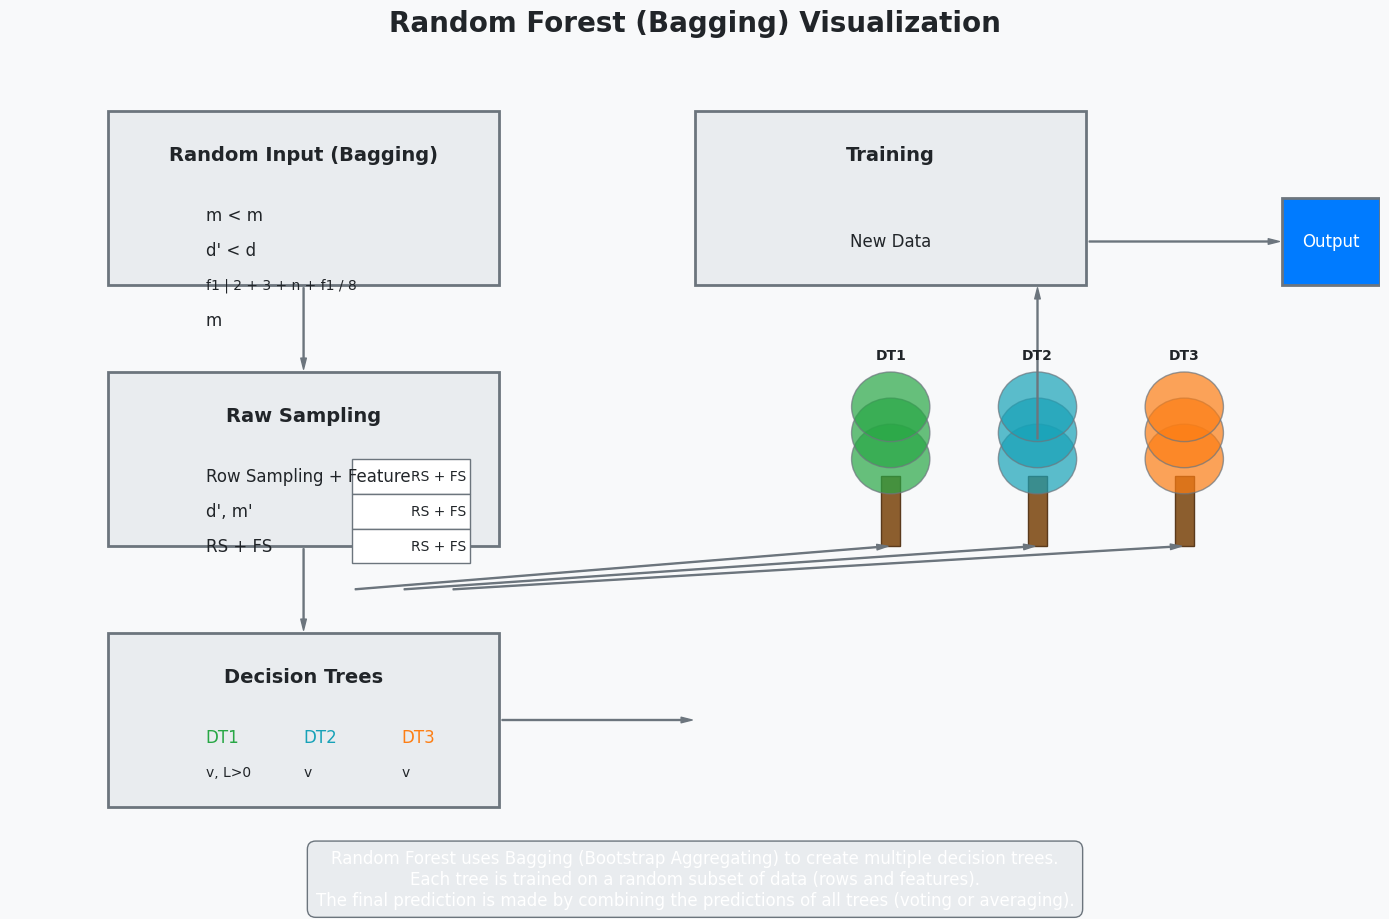

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle, FancyArrowPatch, Circle, Wedge
from matplotlib.collections import PatchCollection
import matplotlib.patches as patches

# Set up the figure
fig, ax = plt.subplots(figsize=(14, 10))
ax.set_xlim(0, 14)
ax.set_ylim(0, 10)
ax.axis('off')

# Colors
bg_color = '#f8f9fa'
box_color = '#e9ecef'
border_color = '#6c757d'
highlight_color = '#007bff'
tree_colors = ['#28a745', '#17a2b8', '#fd7e14']
text_color = '#212529'

# Set background color
fig.patch.set_facecolor(bg_color)
ax.set_facecolor(bg_color)

# Title
plt.figtext(0.5, 0.95, 'Random Forest (Bagging) Visualization', 
            ha='center', va='top', fontsize=20, fontweight='bold', color=text_color)

# Section 1: Random Input (Bagging)
ax.add_patch(Rectangle((1, 7), 4, 2, facecolor=box_color, edgecolor=border_color, lw=2))
plt.text(3, 8.5, 'Random Input (Bagging)', ha='center', va='center', fontweight='bold', fontsize=14, color=text_color)

plt.text(2, 7.8, 'm < m', ha='left', va='center', fontsize=12, color=text_color)
plt.text(2, 7.4, "d' < d", ha='left', va='center', fontsize=12, color=text_color)
plt.text(2, 7.0, 'f1 | 2 + 3 + n + f1 / 8', ha='left', va='center', fontsize=10, color=text_color)
plt.text(2, 6.6, 'm', ha='left', va='center', fontsize=12, color=text_color)

# Section 2: Raw Sampling
ax.add_patch(Rectangle((1, 4), 4, 2, facecolor=box_color, edgecolor=border_color, lw=2))
plt.text(3, 5.5, 'Raw Sampling', ha='center', va='center', fontweight='bold', fontsize=14, color=text_color)

plt.text(2, 4.8, 'Row Sampling + Feature', ha='left', va='center', fontsize=12, color=text_color)
plt.text(2, 4.4, "d', m'", ha='left', va='center', fontsize=12, color=text_color)
plt.text(2, 4.0, 'RS + FS', ha='left', va='center', fontsize=12, color=text_color)

# Sampling boxes
for i, y_pos in enumerate([4.8, 4.4, 4.0]):
    ax.add_patch(Rectangle((3.5, y_pos-0.2), 1.2, 0.4, facecolor='white', edgecolor=border_color, lw=1))
    if i == 0:
        plt.text(4.1, y_pos, 'RS + FS', ha='left', va='center', fontsize=10, color=text_color)
    elif i == 1:
        plt.text(4.1, y_pos, 'RS + FS', ha='left', va='center', fontsize=10, color=text_color)
    else:
        plt.text(4.1, y_pos, 'RS + FS', ha='left', va='center', fontsize=10, color=text_color)

# Section 3: Decision Trees
ax.add_patch(Rectangle((1, 1), 4, 2, facecolor=box_color, edgecolor=border_color, lw=2))
plt.text(3, 2.5, 'Decision Trees', ha='center', va='center', fontweight='bold', fontsize=14, color=text_color)

plt.text(2, 1.8, 'DT1', ha='left', va='center', fontsize=12, color=tree_colors[0])
plt.text(2, 1.4, 'v, L>0', ha='left', va='center', fontsize=10, color=text_color)

plt.text(3, 1.8, 'DT2', ha='left', va='center', fontsize=12, color=tree_colors[1])
plt.text(3, 1.4, 'v', ha='left', va='center', fontsize=10, color=text_color)

plt.text(4, 1.8, 'DT3', ha='left', va='center', fontsize=12, color=tree_colors[2])
plt.text(4, 1.4, 'v', ha='left', va='center', fontsize=10, color=text_color)

# Section 4: Training
ax.add_patch(Rectangle((7, 7), 4, 2, facecolor=box_color, edgecolor=border_color, lw=2))
plt.text(9, 8.5, 'Training', ha='center', va='center', fontweight='bold', fontsize=14, color=text_color)
plt.text(9, 7.5, 'New Data', ha='center', va='center', fontsize=12, color=text_color)

# Arrows
arrow_style = "Simple, tail_width=0.7, head_width=4, head_length=8"
kw = dict(arrowstyle=arrow_style, color=border_color)

# Arrow from Random Input to Raw Sampling
arrow1 = FancyArrowPatch((3, 7), (3, 6), **kw)
ax.add_patch(arrow1)

# Arrow from Raw Sampling to Decision Trees
arrow2 = FancyArrowPatch((3, 4), (3, 3), **kw)
ax.add_patch(arrow2)

# Arrow from Decision Trees to Training
arrow3 = FancyArrowPatch((5, 2), (7, 2), **kw)
ax.add_patch(arrow3)

# Arrow from Training to Output
arrow4 = FancyArrowPatch((11, 7.5), (13, 7.5), **kw)
ax.add_patch(arrow4)

# Output
ax.add_patch(Rectangle((13, 7), 1, 1, facecolor=highlight_color, edgecolor=border_color, lw=2))
plt.text(13.5, 7.5, 'Output', ha='center', va='center', fontsize=12, color='white')

# Decision Tree visualizations
def draw_tree(ax, x, y, color, label):
    # Tree trunk
    ax.add_patch(Rectangle((x-0.1, y), 0.2, 0.8, facecolor='#8c5e2e', edgecolor='#5a3a1c'))
    
    # Tree foliage
    for i in range(3):
        circle = Circle((x, y+1 + i*0.3), radius=0.4, facecolor=color, alpha=0.7, edgecolor=border_color)
        ax.add_patch(circle)
    
    plt.text(x, y+2.2, label, ha='center', va='center', fontsize=10, fontweight='bold', color=text_color)

# Draw trees
draw_tree(ax, 9, 4, tree_colors[0], 'DT1')
draw_tree(ax, 10.5, 4, tree_colors[1], 'DT2')
draw_tree(ax, 12, 4, tree_colors[2], 'DT3')

# Arrows to trees
for i, x in enumerate([9, 10.5, 12]):
    arrow = FancyArrowPatch((3.5 + i*0.5, 3.5), (x, 4), **kw)
    ax.add_patch(arrow)

# Arrow from trees to output
arrow5 = FancyArrowPatch((10.5, 5.2), (10.5, 7), **kw)
ax.add_patch(arrow5)

# Add explanation text
explanation_text = (
    "Random Forest uses Bagging (Bootstrap Aggregating) to create multiple decision trees.\n"
    "Each tree is trained on a random subset of data (rows and features).\n"
    "The final prediction is made by combining the predictions of all trees (voting or averaging)."
)
plt.figtext(0.5, 0.05, explanation_text, ha='center', va='bottom', fontsize=12, 
            bbox=dict(boxstyle="round,pad=0.5", facecolor=box_color, edgecolor=border_color))

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

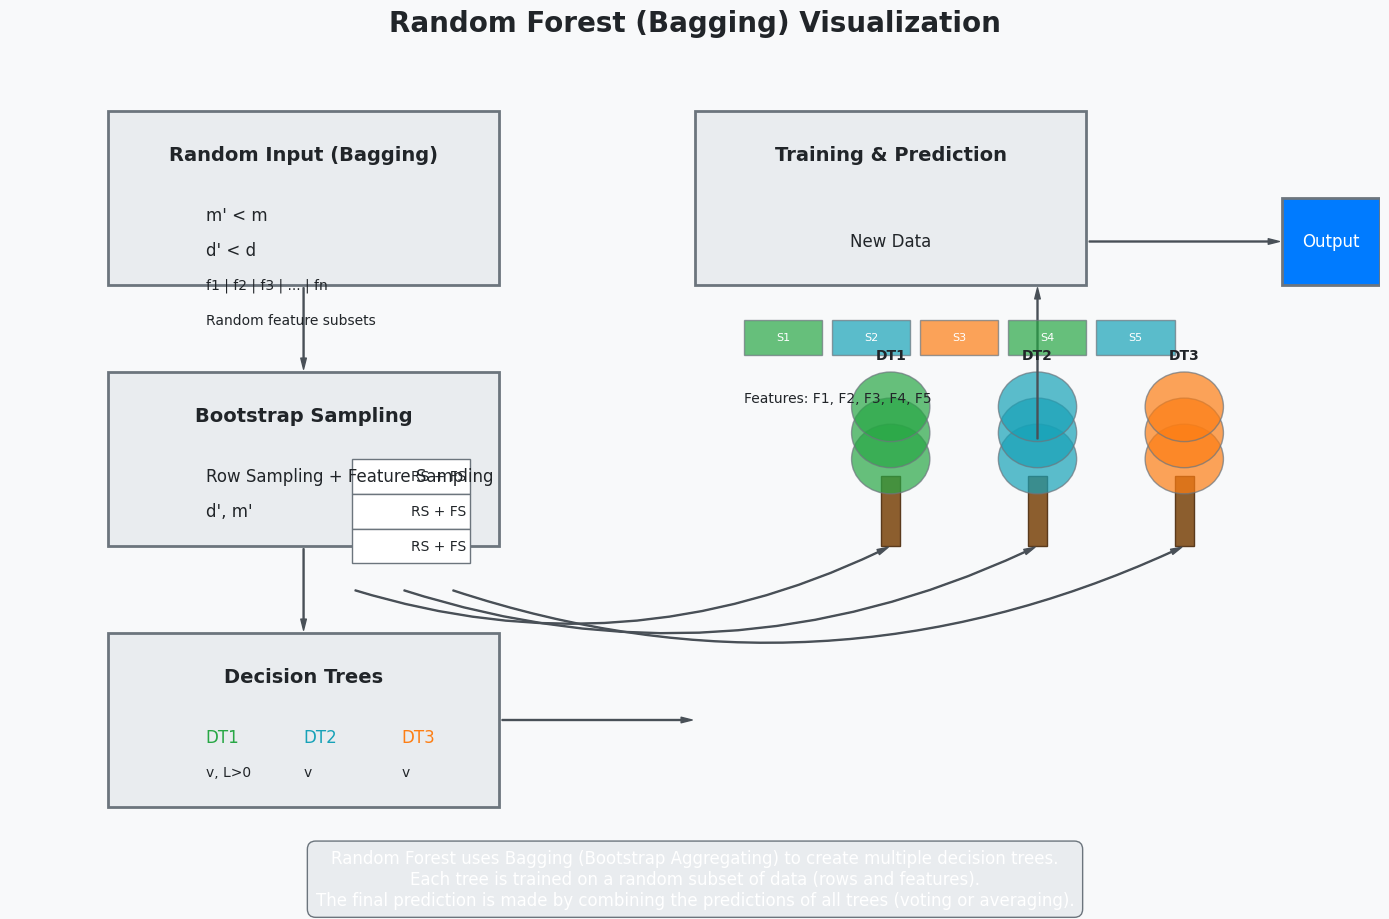

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle, FancyArrowPatch, Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
import matplotlib.patches as patches

# Set up the figure
fig, ax = plt.subplots(figsize=(14, 10))
ax.set_xlim(0, 14)
ax.set_ylim(0, 10)
ax.axis('off')

# Colors
bg_color = '#f8f9fa'
box_color = '#e9ecef'
border_color = '#6c757d'
highlight_color = '#007bff'
tree_colors = ['#28a745', '#17a2b8', '#fd7e14']
text_color = '#212529'
arrow_color = '#495057'

# Set background color
fig.patch.set_facecolor(bg_color)
ax.set_facecolor(bg_color)

# Title
plt.figtext(0.5, 0.95, 'Random Forest (Bagging) Visualization', 
            ha='center', va='top', fontsize=20, fontweight='bold', color=text_color)

# Section 1: Random Input (Bagging)
ax.add_patch(Rectangle((1, 7), 4, 2, facecolor=box_color, edgecolor=border_color, lw=2))
plt.text(3, 8.5, 'Random Input (Bagging)', ha='center', va='center', fontweight='bold', fontsize=14, color=text_color)

plt.text(2, 7.8, 'm\' < m', ha='left', va='center', fontsize=12, color=text_color)
plt.text(2, 7.4, "d\' < d", ha='left', va='center', fontsize=12, color=text_color)
plt.text(2, 7.0, 'f1 | f2 | f3 | ... | fn', ha='left', va='center', fontsize=10, color=text_color)
plt.text(2, 6.6, 'Random feature subsets', ha='left', va='center', fontsize=10, color=text_color)

# Section 2: Bootstrap Sampling
ax.add_patch(Rectangle((1, 4), 4, 2, facecolor=box_color, edgecolor=border_color, lw=2))
plt.text(3, 5.5, 'Bootstrap Sampling', ha='center', va='center', fontweight='bold', fontsize=14, color=text_color)

plt.text(2, 4.8, 'Row Sampling + Feature Sampling', ha='left', va='center', fontsize=12, color=text_color)
plt.text(2, 4.4, "d\', m\'", ha='left', va='center', fontsize=12, color=text_color)

# Sampling boxes
for i, y_pos in enumerate([4.8, 4.4, 4.0]):
    ax.add_patch(Rectangle((3.5, y_pos-0.2), 1.2, 0.4, facecolor='white', edgecolor=border_color, lw=1))
    plt.text(4.1, y_pos, 'RS + FS', ha='left', va='center', fontsize=10, color=text_color)

# Section 3: Decision Trees
ax.add_patch(Rectangle((1, 1), 4, 2, facecolor=box_color, edgecolor=border_color, lw=2))
plt.text(3, 2.5, 'Decision Trees', ha='center', va='center', fontweight='bold', fontsize=14, color=text_color)

plt.text(2, 1.8, 'DT1', ha='left', va='center', fontsize=12, color=tree_colors[0])
plt.text(2, 1.4, 'v, L>0', ha='left', va='center', fontsize=10, color=text_color)

plt.text(3, 1.8, 'DT2', ha='left', va='center', fontsize=12, color=tree_colors[1])
plt.text(3, 1.4, 'v', ha='left', va='center', fontsize=10, color=text_color)

plt.text(4, 1.8, 'DT3', ha='left', va='center', fontsize=12, color=tree_colors[2])
plt.text(4, 1.4, 'v', ha='left', va='center', fontsize=10, color=text_color)

# Section 4: Training & Prediction
ax.add_patch(Rectangle((7, 7), 4, 2, facecolor=box_color, edgecolor=border_color, lw=2))
plt.text(9, 8.5, 'Training & Prediction', ha='center', va='center', fontweight='bold', fontsize=14, color=text_color)
plt.text(9, 7.5, 'New Data', ha='center', va='center', fontsize=12, color=text_color)

# Arrows
arrow_style = "Simple, tail_width=0.7, head_width=4, head_length=8"
kw = dict(arrowstyle=arrow_style, color=arrow_color)

# Arrow from Random Input to Bootstrap Sampling
arrow1 = FancyArrowPatch((3, 7), (3, 6), **kw)
ax.add_patch(arrow1)

# Arrow from Bootstrap Sampling to Decision Trees
arrow2 = FancyArrowPatch((3, 4), (3, 3), **kw)
ax.add_patch(arrow2)

# Arrow from Decision Trees to Training
arrow3 = FancyArrowPatch((5, 2), (7, 2), **kw)
ax.add_patch(arrow3)

# Arrow from Training to Output
arrow4 = FancyArrowPatch((11, 7.5), (13, 7.5), **kw)
ax.add_patch(arrow4)

# Output
ax.add_patch(Rectangle((13, 7), 1, 1, facecolor=highlight_color, edgecolor=border_color, lw=2))
plt.text(13.5, 7.5, 'Output', ha='center', va='center', fontsize=12, color='white')

# Decision Tree visualizations
def draw_tree(ax, x, y, color, label):
    # Tree trunk
    ax.add_patch(Rectangle((x-0.1, y), 0.2, 0.8, facecolor='#8c5e2e', edgecolor='#5a3a1c'))
    
    # Tree foliage
    for i in range(3):
        circle = Circle((x, y+1 + i*0.3), radius=0.4, facecolor=color, alpha=0.7, edgecolor=border_color)
        ax.add_patch(circle)
    
    plt.text(x, y+2.2, label, ha='center', va='center', fontsize=10, fontweight='bold', color=text_color)

# Draw trees
draw_tree(ax, 9, 4, tree_colors[0], 'DT1')
draw_tree(ax, 10.5, 4, tree_colors[1], 'DT2')
draw_tree(ax, 12, 4, tree_colors[2], 'DT3')

# Arrows to trees
for i, x in enumerate([9, 10.5, 12]):
    arrow = FancyArrowPatch((3.5 + i*0.5, 3.5), (x, 4), connectionstyle="arc3,rad=0.2", **kw)
    ax.add_patch(arrow)

# Arrow from trees to output
arrow5 = FancyArrowPatch((10.5, 5.2), (10.5, 7), **kw)
ax.add_patch(arrow5)

# Add data samples visualization
def draw_data_sample(ax, x, y, color, label):
    ax.add_patch(Rectangle((x, y), 0.8, 0.4, facecolor=color, alpha=0.7, edgecolor=border_color))
    plt.text(x+0.4, y+0.2, label, ha='center', va='center', fontsize=8, color='white')

# Draw data samples
for i in range(5):
    draw_data_sample(ax, 7.5 + i*0.9, 6.2, tree_colors[i % 3], f'S{i+1}')

# Add feature visualization
plt.text(7.5, 5.7, 'Features: F1, F2, F3, F4, F5', ha='left', va='center', fontsize=10, color=text_color)

# Add explanation text
explanation_text = (
    "Random Forest uses Bagging (Bootstrap Aggregating) to create multiple decision trees.\n"
    "Each tree is trained on a random subset of data (rows and features).\n"
    "The final prediction is made by combining the predictions of all trees (voting or averaging)."
)
plt.figtext(0.5, 0.05, explanation_text, ha='center', va='bottom', fontsize=12, 
            bbox=dict(boxstyle="round,pad=0.5", facecolor=box_color, edgecolor=border_color))

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

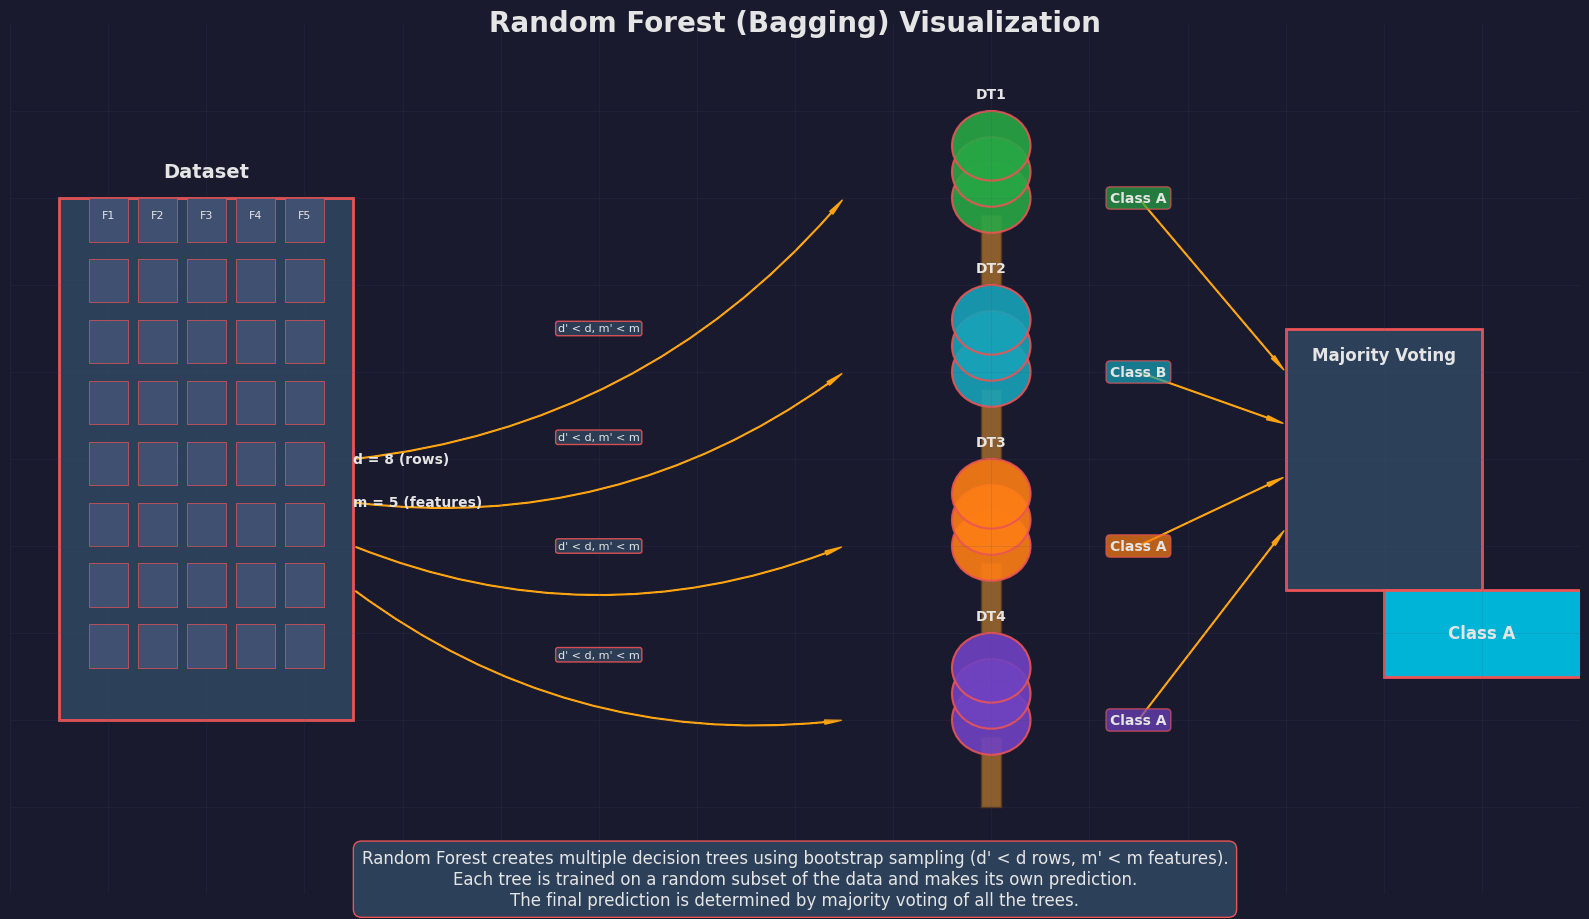

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle, FancyArrowPatch, Circle, Polygon
from matplotlib.collections import PatchCollection
import matplotlib.patches as patches

# Set up the figure with dark background
fig, ax = plt.subplots(figsize=(16, 10))
ax.set_xlim(0, 16)
ax.set_ylim(0, 10)
ax.axis('off')

# Colors for dark background
bg_color = '#1a1a2e'
box_color = '#2d4059'
border_color = '#ea5455'
highlight_color = '#00b4d8'
tree_colors = ['#28a745', '#17a2b8', '#fd7e14', '#6f42c1']
text_color = '#e5e5e5'
arrow_color = '#fca311'
data_color = '#2d4059'
grid_color = '#405070'

# Set background color
fig.patch.set_facecolor(bg_color)
ax.set_facecolor(bg_color)

# Title
plt.figtext(0.5, 0.95, 'Random Forest (Bagging) Visualization', 
            ha='center', va='top', fontsize=20, fontweight='bold', color=text_color)

# Draw the dataset on the left side
ax.add_patch(Rectangle((0.5, 2), 3, 6, facecolor=data_color, edgecolor=border_color, lw=2))
plt.text(2, 8.3, 'Dataset', ha='center', va='center', fontweight='bold', fontsize=14, color=text_color)

# Draw rows and columns in the dataset
for i in range(8):  # rows
    for j in range(5):  # columns/features
        ax.add_patch(Rectangle((0.8 + j*0.5, 7.5 - i*0.7), 0.4, 0.5, 
                     facecolor=grid_color, edgecolor=border_color, lw=0.5))
        if i == 0:  # Feature names
            plt.text(1 + j*0.5, 7.8, f'F{j+1}', ha='center', va='center', fontsize=8, color=text_color)

# Label dataset dimensions
plt.text(3.5, 5, 'd = 8 (rows)', ha='left', va='center', fontsize=10, color=text_color, fontweight='bold')
plt.text(3.5, 4.5, 'm = 5 (features)', ha='left', va='center', fontsize=10, color=text_color, fontweight='bold')

# Draw four decision trees (arranged vertically)
def draw_tree(ax, x, y, color, label):
    # Tree trunk
    ax.add_patch(Rectangle((x-0.1, y), 0.2, 0.8, facecolor='#8c5e2e', edgecolor='#5a3a1c'))
    
    # Tree foliage
    for i in range(3):
        circle = Circle((x, y+1 + i*0.3), radius=0.4, facecolor=color, alpha=0.9, edgecolor=border_color, lw=1.5)
        ax.add_patch(circle)
    
    plt.text(x, y+2.2, label, ha='center', va='center', fontsize=10, fontweight='bold', color=text_color)
    return (x, y+2.5)  # Return the top position of the tree

# Positions for trees (vertical arrangement)
tree_positions = [(10, 7), (10, 5), (10, 3), (10, 1)]
tree_labels = ['DT1', 'DT2', 'DT3', 'DT4']
tree_outputs = ['Class A', 'Class B', 'Class A', 'Class A']

# Draw trees and their outputs
tree_tops = []
for i, (pos, label, output) in enumerate(zip(tree_positions, tree_labels, tree_outputs)):
    top = draw_tree(ax, pos[0], pos[1], tree_colors[i], label)
    tree_tops.append(top)
    plt.text(pos[0]+1.5, pos[1]+1, output, ha='center', va='center', fontsize=10, 
             color=text_color, fontweight='bold', bbox=dict(boxstyle="round,pad=0.3", 
             facecolor=tree_colors[i], alpha=0.7, edgecolor=border_color))

# Draw arrows from dataset to trees with sampling labels
arrow_style = "Simple, tail_width=0.5, head_width=3, head_length=12"
kw = dict(arrowstyle=arrow_style, color=arrow_color)

for i, tree_pos in enumerate(tree_positions):
    # Calculate arrow path
    start_x = 3.5
    start_y = 5 - i*0.5
    end_x = tree_pos[0] - 1.5
    end_y = tree_pos[1] + 1
    
    # Draw arrow
    arrow = FancyArrowPatch((start_x, start_y), (end_x, end_y), 
                            connectionstyle="arc3,rad=0.2", **kw)
    ax.add_patch(arrow)
    
    # Add sampling label
    mid_x = (start_x + end_x) / 2
    mid_y = (start_y + end_y) / 2
    plt.text(mid_x, mid_y, "d' < d, m' < m", ha='center', va='center', fontsize=8, 
             color=text_color, bbox=dict(boxstyle="round,pad=0.2", facecolor=box_color, alpha=0.9, edgecolor=border_color))

# Draw majority voting process
ax.add_patch(Rectangle((13, 3.5), 2, 3, facecolor=box_color, edgecolor=border_color, lw=2))
plt.text(14, 6.2, 'Majority Voting', ha='center', va='center', fontweight='bold', fontsize=12, color=text_color)

# Draw arrows from tree outputs to voting box
for i, tree_pos in enumerate(tree_positions):
    arrow = FancyArrowPatch((tree_pos[0]+1.5, tree_pos[1]+1), (13, 6 - i*0.6), **kw)
    ax.add_patch(arrow)

# Draw final output
ax.add_patch(Rectangle((14, 2.5), 2, 1, facecolor=highlight_color, edgecolor=border_color, lw=2))
plt.text(15, 3, 'Class A', ha='center', va='center', fontsize=12, color=text_color, fontweight='bold')

# Add explanation text
explanation_text = (
    "Random Forest creates multiple decision trees using bootstrap sampling (d' < d rows, m' < m features).\n"
    "Each tree is trained on a random subset of the data and makes its own prediction.\n"
    "The final prediction is determined by majority voting of all the trees."
)
plt.figtext(0.5, 0.05, explanation_text, ha='center', va='bottom', fontsize=12, color=text_color,
            bbox=dict(boxstyle="round,pad=0.5", facecolor=box_color, edgecolor=border_color))

# Add a subtle grid for better visual orientation
for x in np.arange(0, 16, 1):
    ax.axvline(x=x, color=grid_color, alpha=0.2, linestyle='-', linewidth=0.5)
for y in np.arange(0, 10, 1):
    ax.axhline(y=y, color=grid_color, alpha=0.2, linestyle='-', linewidth=0.5)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

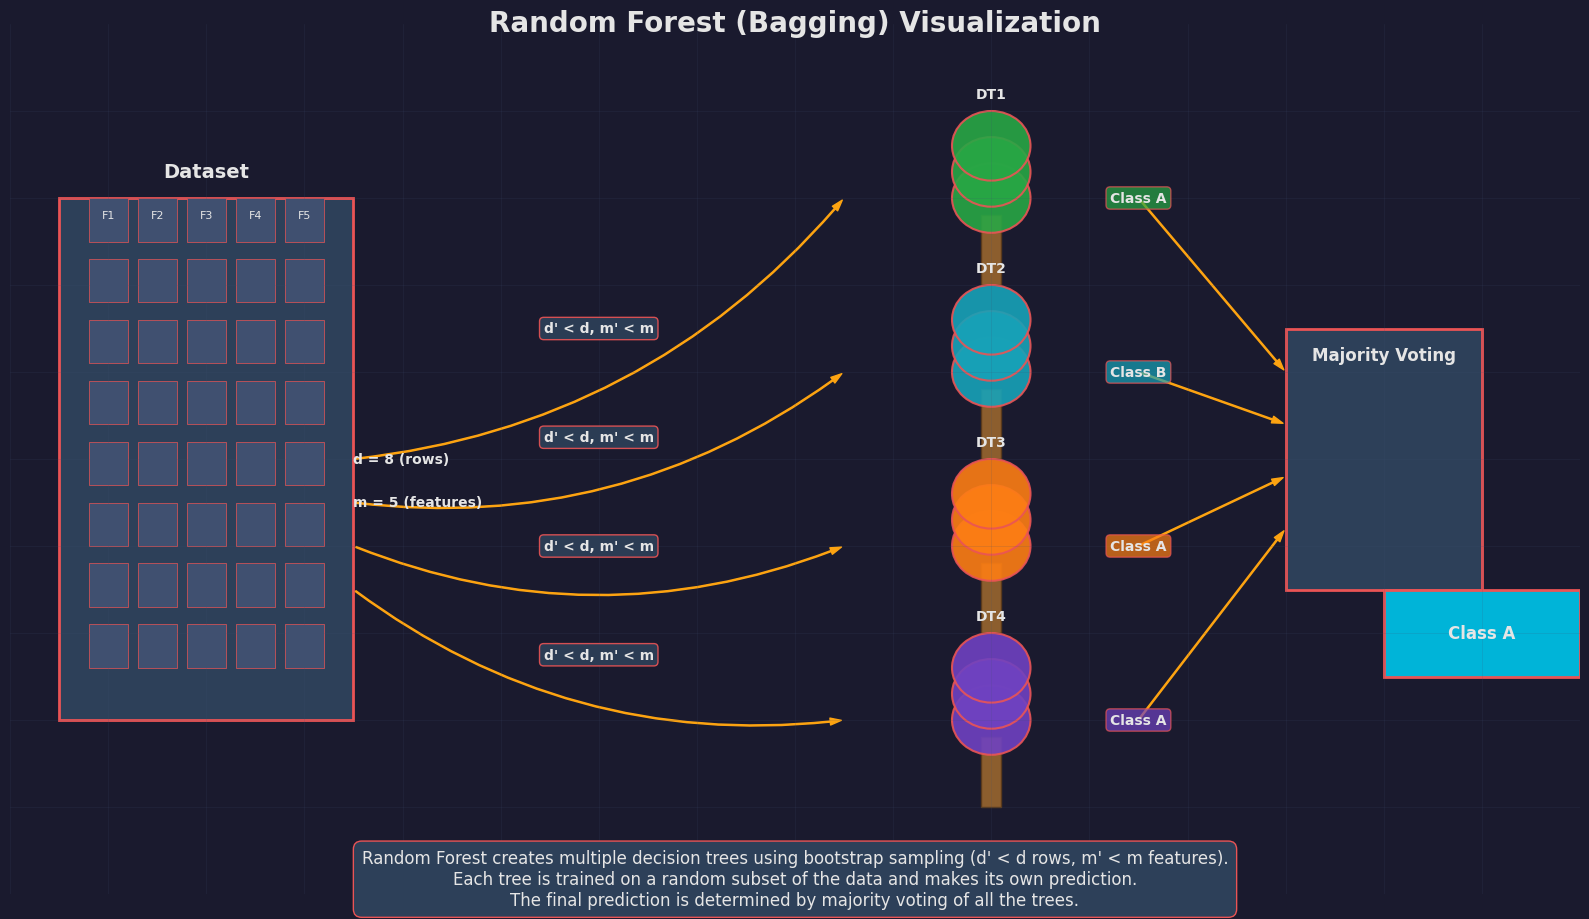

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle, FancyArrowPatch, Circle, Polygon
from matplotlib.collections import PatchCollection
import matplotlib.patches as patches

# Set up the figure with dark background
fig, ax = plt.subplots(figsize=(16, 10))
ax.set_xlim(0, 16)
ax.set_ylim(0, 10)
ax.axis('off')

# Colors for dark background
bg_color = '#1a1a2e'
box_color = '#2d4059'
border_color = '#ea5455'
highlight_color = '#00b4d8'
tree_colors = ['#28a745', '#17a2b8', '#fd7e14', '#6f42c1']
text_color = '#e5e5e5'
arrow_color = '#fca311'
data_color = '#2d4059'
grid_color = '#405070'

# Set background color
fig.patch.set_facecolor(bg_color)
ax.set_facecolor(bg_color)

# Title
plt.figtext(0.5, 0.95, 'Random Forest (Bagging) Visualization', 
            ha='center', va='top', fontsize=20, fontweight='bold', color=text_color)

# Draw the dataset on the left side
ax.add_patch(Rectangle((0.5, 2), 3, 6, facecolor=data_color, edgecolor=border_color, lw=2))
plt.text(2, 8.3, 'Dataset', ha='center', va='center', fontweight='bold', fontsize=14, color=text_color)

# Draw rows and columns in the dataset
for i in range(8):  # rows
    for j in range(5):  # columns/features
        ax.add_patch(Rectangle((0.8 + j*0.5, 7.5 - i*0.7), 0.4, 0.5, 
                     facecolor=grid_color, edgecolor=border_color, lw=0.5))
        if i == 0:  # Feature names
            plt.text(1 + j*0.5, 7.8, f'F{j+1}', ha='center', va='center', fontsize=8, color=text_color)

# Label dataset dimensions
plt.text(3.5, 5, 'd = 8 (rows)', ha='left', va='center', fontsize=10, color=text_color, fontweight='bold')
plt.text(3.5, 4.5, 'm = 5 (features)', ha='left', va='center', fontsize=10, color=text_color, fontweight='bold')

# Draw four decision trees (arranged vertically)
def draw_tree(ax, x, y, color, label):
    # Tree trunk
    ax.add_patch(Rectangle((x-0.1, y), 0.2, 0.8, facecolor='#8c5e2e', edgecolor='#5a3a1c'))
    
    # Tree foliage
    for i in range(3):
        circle = Circle((x, y+1 + i*0.3), radius=0.4, facecolor=color, alpha=0.9, edgecolor=border_color, lw=1.5)
        ax.add_patch(circle)
    
    plt.text(x, y+2.2, label, ha='center', va='center', fontsize=10, fontweight='bold', color=text_color)
    return (x, y+2.5)  # Return the top position of the tree

# Positions for trees (vertical arrangement)
tree_positions = [(10, 7), (10, 5), (10, 3), (10, 1)]
tree_labels = ['DT1', 'DT2', 'DT3', 'DT4']
tree_outputs = ['Class A', 'Class B', 'Class A', 'Class A']

# Draw trees and their outputs
tree_tops = []
for i, (pos, label, output) in enumerate(zip(tree_positions, tree_labels, tree_outputs)):
    top = draw_tree(ax, pos[0], pos[1], tree_colors[i], label)
    tree_tops.append(top)
    plt.text(pos[0]+1.5, pos[1]+1, output, ha='center', va='center', fontsize=10, 
             color=text_color, fontweight='bold', bbox=dict(boxstyle="round,pad=0.3", 
             facecolor=tree_colors[i], alpha=0.7, edgecolor=border_color))

# Draw arrows from dataset to trees with sampling labels
# Increased arrow size
arrow_style = "Simple, tail_width=0.8, head_width=5, head_length=8"
kw = dict(arrowstyle=arrow_style, color=arrow_color)

for i, tree_pos in enumerate(tree_positions):
    # Calculate arrow path
    start_x = 3.5
    start_y = 5 - i*0.5
    end_x = tree_pos[0] - 1.5
    end_y = tree_pos[1] + 1
    
    # Draw arrow
    arrow = FancyArrowPatch((start_x, start_y), (end_x, end_y), 
                            connectionstyle="arc3,rad=0.2", **kw)
    ax.add_patch(arrow)
    
    # Add sampling label with increased font size
    mid_x = (start_x + end_x) / 2
    mid_y = (start_y + end_y) / 2
    plt.text(mid_x, mid_y, "d' < d, m' < m", ha='center', va='center', fontsize=10, fontweight='bold',
             color=text_color, bbox=dict(boxstyle="round,pad=0.3", facecolor=box_color, alpha=0.9, edgecolor=border_color))

# Draw majority voting process
ax.add_patch(Rectangle((13, 3.5), 2, 3, facecolor=box_color, edgecolor=border_color, lw=2))
plt.text(14, 6.2, 'Majority Voting', ha='center', va='center', fontweight='bold', fontsize=12, color=text_color)

# Draw arrows from tree outputs to voting box
# Increased arrow size for these arrows too
for i, tree_pos in enumerate(tree_positions):
    arrow = FancyArrowPatch((tree_pos[0]+1.5, tree_pos[1]+1), (13, 6 - i*0.6), **kw)
    ax.add_patch(arrow)

# Draw final output
ax.add_patch(Rectangle((14, 2.5), 2, 1, facecolor=highlight_color, edgecolor=border_color, lw=2))
plt.text(15, 3, 'Class A', ha='center', va='center', fontsize=12, color=text_color, fontweight='bold')

# Add explanation text
explanation_text = (
    "Random Forest creates multiple decision trees using bootstrap sampling (d' < d rows, m' < m features).\n"
    "Each tree is trained on a random subset of the data and makes its own prediction.\n"
    "The final prediction is determined by majority voting of all the trees."
)
plt.figtext(0.5, 0.05, explanation_text, ha='center', va='bottom', fontsize=12, color=text_color,
            bbox=dict(boxstyle="round,pad=0.5", facecolor=box_color, edgecolor=border_color))

# Add a subtle grid for better visual orientation
for x in np.arange(0, 16, 1):
    ax.axvline(x=x, color=grid_color, alpha=0.2, linestyle='-', linewidth=0.5)
for y in np.arange(0, 10, 1):
    ax.axhline(y=y, color=grid_color, alpha=0.2, linestyle='-', linewidth=0.5)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

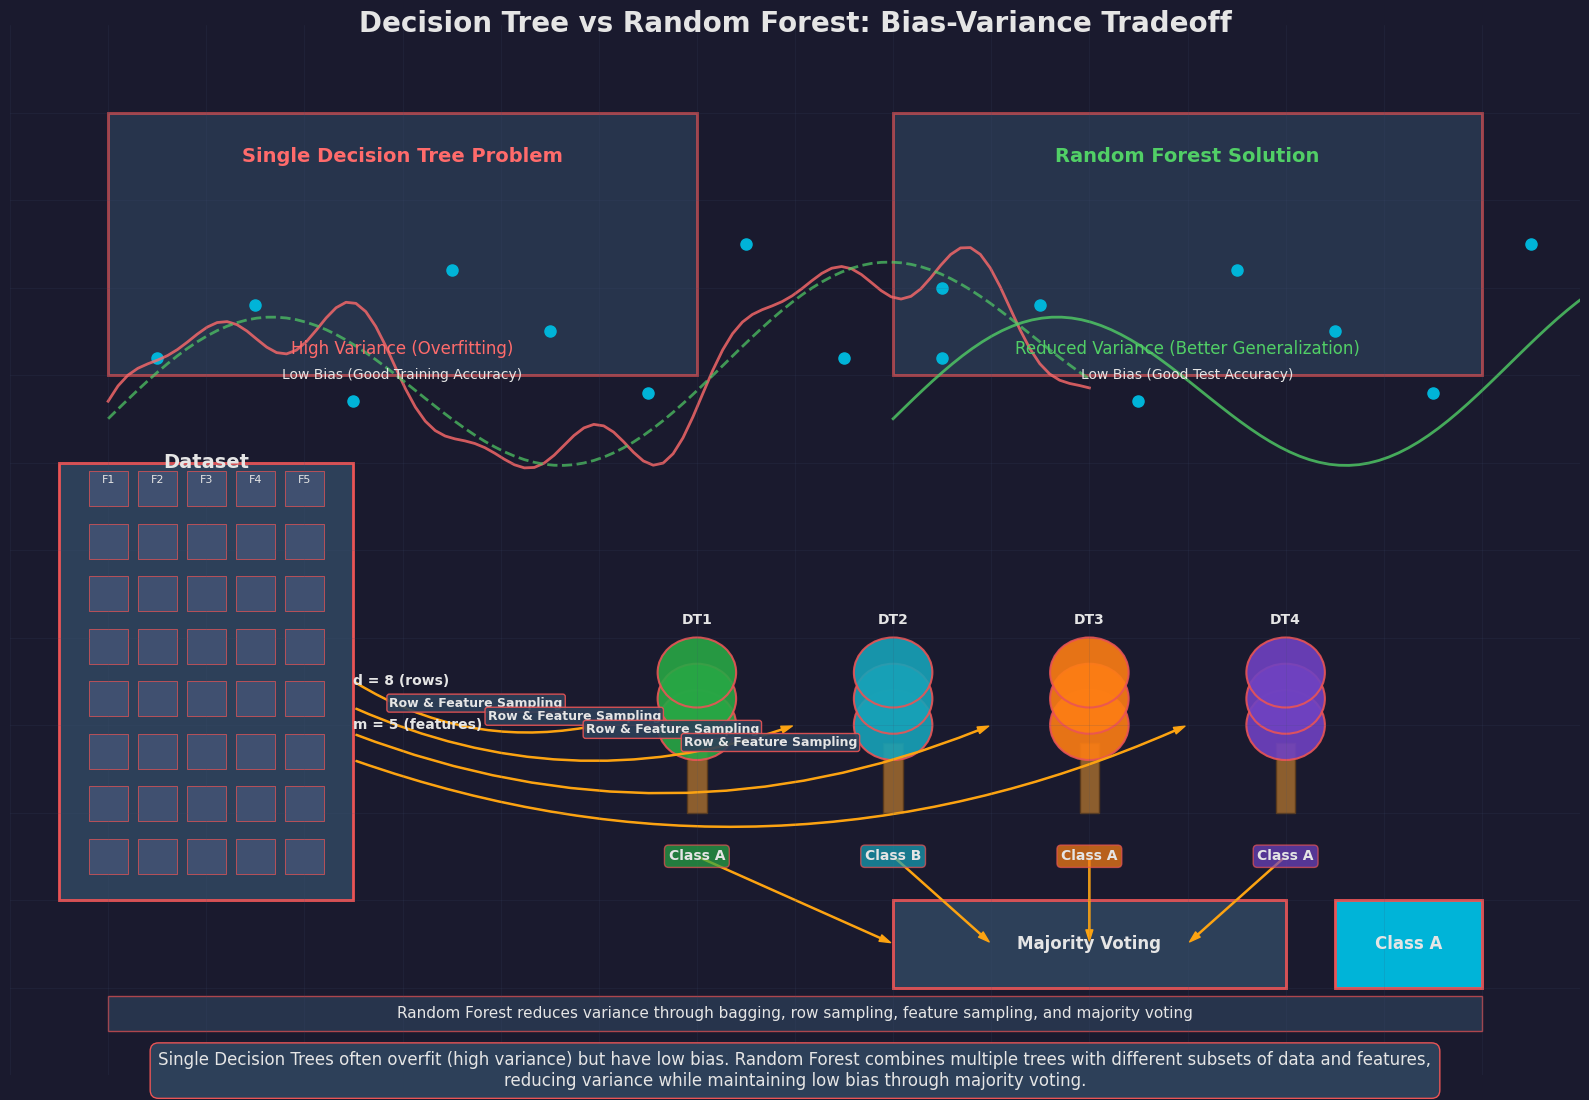

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle, FancyArrowPatch, Circle, Polygon
from matplotlib.collections import PatchCollection
import matplotlib.patches as patches

# Set up the figure
fig, ax = plt.subplots(figsize=(16, 12))
ax.set_xlim(0, 16)
ax.set_ylim(0, 12)
ax.axis('off')

# Colors
bg_color = '#1a1a2e'
box_color = '#2d4059'
border_color = '#ea5455'
highlight_color = '#00b4d8'
tree_colors = ['#28a745', '#17a2b8', '#fd7e14', '#6f42c1']
text_color = '#e5e5e5'
arrow_color = '#fca311'
data_color = '#2d4059'
grid_color = '#405070'
problem_color = '#ff6b6b'
solution_color = '#51cf66'

# Set background color
fig.patch.set_facecolor(bg_color)
ax.set_facecolor(bg_color)

# Title
plt.figtext(0.5, 0.95, 'Decision Tree vs Random Forest: Bias-Variance Tradeoff', 
            ha='center', va='top', fontsize=20, fontweight='bold', color=text_color)

# Draw the problem section (Single Decision Tree)
ax.add_patch(Rectangle((1, 8), 6, 3, facecolor=box_color, edgecolor=border_color, lw=2, alpha=0.7))
plt.text(4, 10.5, 'Single Decision Tree Problem', ha='center', va='center', 
         fontweight='bold', fontsize=14, color=problem_color)

# Draw overfitting visualization
x = np.linspace(0, 10, 100)
y_true = np.sin(x) + 0.1*x
y_overfit = np.sin(x) + 0.1*x + 0.3*np.sin(3*x) + 0.2*np.cos(5*x)

ax.plot(np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])+0.5, 
        np.array([1.2, 1.8, 0.7, 2.2, 1.5, 0.8, 2.5, 1.2, 2.0])+7, 
        'o', color=highlight_color, markersize=8)

ax.plot(np.array(x)+1, y_overfit+7.5, '-', color=problem_color, linewidth=2, alpha=0.8)
ax.plot(np.array(x)+1, y_true+7.5, '--', color=solution_color, linewidth=2, alpha=0.7)

plt.text(4, 8.3, 'High Variance (Overfitting)', ha='center', va='center', 
         fontsize=12, color=problem_color)
plt.text(4, 8.0, 'Low Bias (Good Training Accuracy)', ha='center', va='center', 
         fontsize=10, color=text_color)

# Draw the solution section (Random Forest)
ax.add_patch(Rectangle((9, 8), 6, 3, facecolor=box_color, edgecolor=border_color, lw=2, alpha=0.7))
plt.text(12, 10.5, 'Random Forest Solution', ha='center', va='center', 
         fontweight='bold', fontsize=14, color=solution_color)

# Draw proper fitting visualization
ax.plot(np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])+8.5, 
        np.array([1.2, 1.8, 0.7, 2.2, 1.5, 0.8, 2.5, 1.2, 2.0])+7, 
        'o', color=highlight_color, markersize=8)

ax.plot(np.array(x)+9, y_true+7.5, '-', color=solution_color, linewidth=2, alpha=0.8)

plt.text(12, 8.3, 'Reduced Variance (Better Generalization)', ha='center', va='center', 
         fontsize=12, color=solution_color)
plt.text(12, 8.0, 'Low Bias (Good Test Accuracy)', ha='center', va='center', 
         fontsize=10, color=text_color)

# Draw the dataset on the left side
ax.add_patch(Rectangle((0.5, 2), 3, 5, facecolor=data_color, edgecolor=border_color, lw=2))
plt.text(2, 7.0, 'Dataset', ha='center', va='center', fontweight='bold', fontsize=14, color=text_color)

# Draw rows and columns in the dataset
for i in range(8):  # rows
    for j in range(5):  # columns/features
        ax.add_patch(Rectangle((0.8 + j*0.5, 6.5 - i*0.6), 0.4, 0.4, 
                     facecolor=grid_color, edgecolor=border_color, lw=0.5))
        if i == 0:  # Feature names
            plt.text(1 + j*0.5, 6.8, f'F{j+1}', ha='center', va='center', fontsize=8, color=text_color)

# Label dataset dimensions
plt.text(3.5, 4.5, 'd = 8 (rows)', ha='left', va='center', fontsize=10, color=text_color, fontweight='bold')
plt.text(3.5, 4.0, 'm = 5 (features)', ha='left', va='center', fontsize=10, color=text_color, fontweight='bold')

# Draw four decision trees (arranged horizontally)
def draw_tree(ax, x, y, color, label):
    # Tree trunk
    ax.add_patch(Rectangle((x-0.1, y), 0.2, 0.8, facecolor='#8c5e2e', edgecolor='#5a3a1c'))
    
    # Tree foliage
    for i in range(3):
        circle = Circle((x, y+1 + i*0.3), radius=0.4, facecolor=color, alpha=0.9, edgecolor=border_color, lw=1.5)
        ax.add_patch(circle)
    
    plt.text(x, y+2.2, label, ha='center', va='center', fontsize=10, fontweight='bold', color=text_color)
    return (x, y+2.5)  # Return the top position of the tree

# Positions for trees (horizontal arrangement)
tree_positions = [(7, 3), (9, 3), (11, 3), (13, 3)]
tree_labels = ['DT1', 'DT2', 'DT3', 'DT4']
tree_outputs = ['Class A', 'Class B', 'Class A', 'Class A']

# Draw trees and their outputs
tree_tops = []
for i, (pos, label, output) in enumerate(zip(tree_positions, tree_labels, tree_outputs)):
    top = draw_tree(ax, pos[0], pos[1], tree_colors[i], label)
    tree_tops.append(top)
    plt.text(pos[0], pos[1]-0.5, output, ha='center', va='center', fontsize=10, 
             color=text_color, fontweight='bold', bbox=dict(boxstyle="round,pad=0.3", 
             facecolor=tree_colors[i], alpha=0.7, edgecolor=border_color))

# Draw arrows from dataset to trees with sampling labels
arrow_style = "Simple, tail_width=0.8, head_width=5, head_length=8"
kw = dict(arrowstyle=arrow_style, color=arrow_color)

for i, tree_pos in enumerate(tree_positions):
    # Calculate arrow path
    start_x = 3.5
    start_y = 4.5 - i*0.3
    end_x = tree_pos[0] - 1.0
    end_y = tree_pos[1] + 1
    
    # Draw arrow
    arrow = FancyArrowPatch((start_x, start_y), (end_x, end_y), 
                            connectionstyle="arc3,rad=0.2", **kw)
    ax.add_patch(arrow)
    
    # Add sampling label
    mid_x = (start_x + end_x) / 2
    mid_y = (start_y + end_y) / 2
    plt.text(mid_x, mid_y, "Row & Feature Sampling", ha='center', va='center', fontsize=9, fontweight='bold',
             color=text_color, bbox=dict(boxstyle="round,pad=0.2", facecolor=box_color, alpha=0.9, edgecolor=border_color))

# Draw majority voting process
ax.add_patch(Rectangle((9, 1), 4, 1, facecolor=box_color, edgecolor=border_color, lw=2))
plt.text(11, 1.5, 'Majority Voting', ha='center', va='center', fontweight='bold', fontsize=12, color=text_color)

# Draw arrows from tree outputs to voting box
for i, tree_pos in enumerate(tree_positions):
    arrow = FancyArrowPatch((tree_pos[0], tree_pos[1]-0.5), (9 + i, 1.5), **kw)
    ax.add_patch(arrow)

# Draw final output
ax.add_patch(Rectangle((13.5, 1), 1.5, 1, facecolor=highlight_color, edgecolor=border_color, lw=2))
plt.text(14.25, 1.5, 'Class A', ha='center', va='center', fontsize=12, color=text_color, fontweight='bold')

# Draw bias-variance tradeoff explanation
ax.add_patch(Rectangle((1, 0.5), 14, 0.4, facecolor=box_color, edgecolor=border_color, lw=1, alpha=0.7))
plt.text(8, 0.7, 'Random Forest reduces variance through bagging, row sampling, feature sampling, and majority voting', 
         ha='center', va='center', fontsize=11, color=text_color)

# Add explanation text
explanation_text = (
    "Single Decision Trees often overfit (high variance) but have low bias. "
    "Random Forest combines multiple trees with different subsets of data and features,\n"
    "reducing variance while maintaining low bias through majority voting."
)
plt.figtext(0.5, 0.05, explanation_text, ha='center', va='bottom', fontsize=12, color=text_color,
            bbox=dict(boxstyle="round,pad=0.5", facecolor=box_color, edgecolor=border_color))

# Add a subtle grid for better visual orientation
for x in np.arange(0, 16, 1):
    ax.axvline(x=x, color=grid_color, alpha=0.2, linestyle='-', linewidth=0.5)
for y in np.arange(0, 12, 1):
    ax.axhline(y=y, color=grid_color, alpha=0.2, linestyle='-', linewidth=0.5)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

Dataset shape: (1000, 20)
Training set: (700, 20)
Test set: (300, 20)

1. SINGLE DECISION TREE (HIGH VARIANCE)
Training Accuracy: 1.0000
Test Accuracy: 0.7200
Overfitting Gap: 0.2800

2. BAGGING WITH ROW SAMPLING
Training Accuracy: 0.9943
Test Accuracy: 0.8567
Overfitting Gap: 0.1376

3. RANDOM FOREST (ROW + FEATURE SAMPLING)
Training Accuracy: 1.0000
Test Accuracy: 0.8433
Overfitting Gap: 0.1567

4. VOTING CLASSIFIER WITH DIVERSITY
Training Accuracy: 0.9429
Test Accuracy: 0.8633
Overfitting Gap: 0.0795


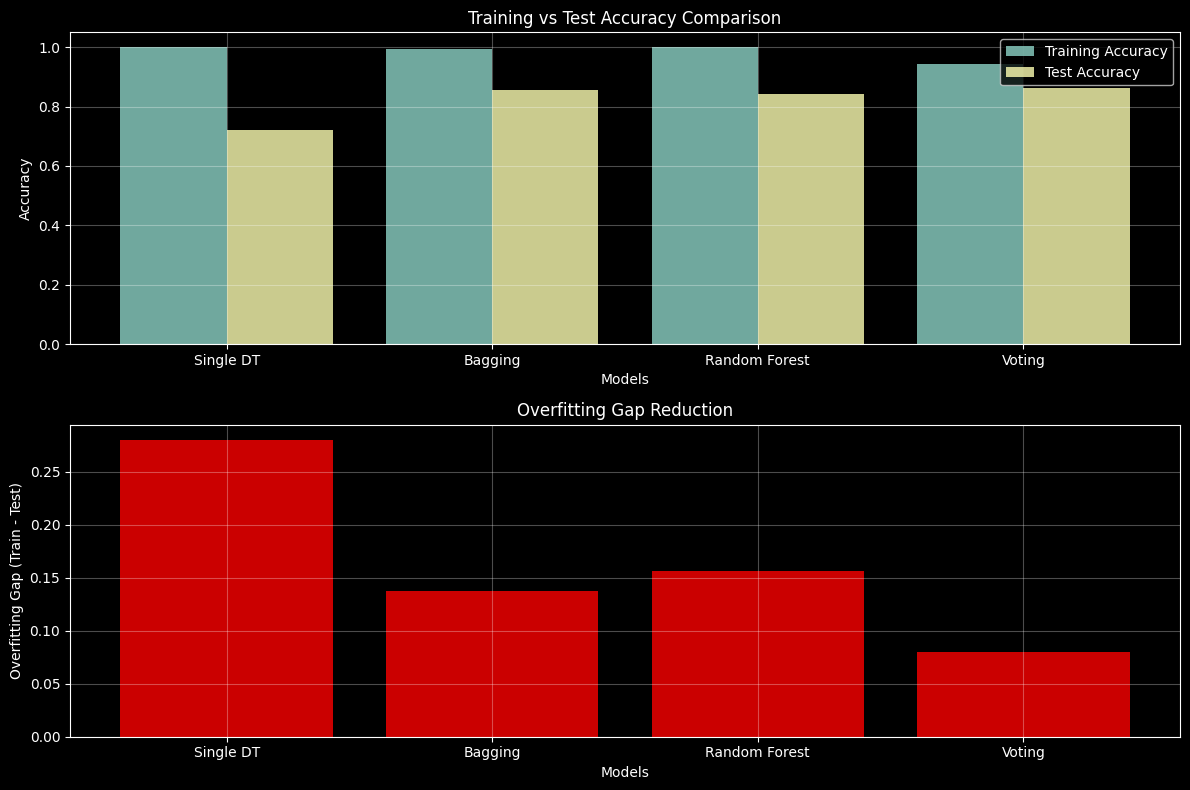


Plotting learning curves...


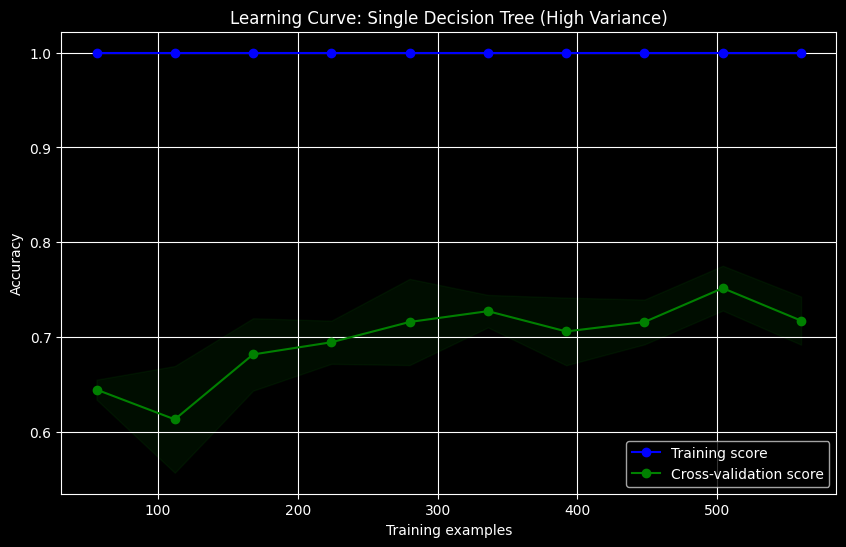

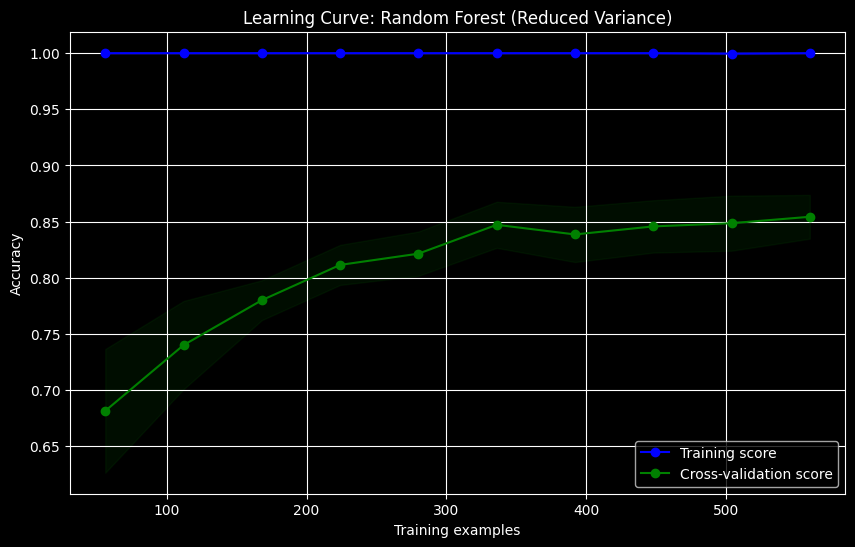

In [29]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Create a complex dataset that will showcase overfitting
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, 
                          n_redundant=5, n_clusters_per_class=2, 
                          flip_y=0.1, random_state=42)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Dataset shape:", X.shape)
print("Training set:", X_train.shape)
print("Test set:", X_test.shape)

# 1. Single Decision Tree (High Variance Problem)
print("\n" + "="*50)
print("1. SINGLE DECISION TREE (HIGH VARIANCE)")
print("="*50)

dt = DecisionTreeClassifier(random_state=42, max_depth=None)
dt.fit(X_train, y_train)

train_acc_dt = accuracy_score(y_train, dt.predict(X_train))
test_acc_dt = accuracy_score(y_test, dt.predict(X_test))

print(f"Training Accuracy: {train_acc_dt:.4f}")
print(f"Test Accuracy: {test_acc_dt:.4f}")
print(f"Overfitting Gap: {train_acc_dt - test_acc_dt:.4f}")

# 2. Bagging with Row Sampling
print("\n" + "="*50)
print("2. BAGGING WITH ROW SAMPLING")
print("="*50)

bagging_dt = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=10, random_state=42),
    n_estimators=50,
    max_samples=0.8,  # Row sampling: 80% of training data
    random_state=42,
    n_jobs=-1
)

bagging_dt.fit(X_train, y_train)

train_acc_bag = accuracy_score(y_train, bagging_dt.predict(X_train))
test_acc_bag = accuracy_score(y_test, bagging_dt.predict(X_test))

print(f"Training Accuracy: {train_acc_bag:.4f}")
print(f"Test Accuracy: {test_acc_bag:.4f}")
print(f"Overfitting Gap: {train_acc_bag - test_acc_bag:.4f}")

# 3. Random Forest (Row + Feature Sampling)
print("\n" + "="*50)
print("3. RANDOM FOREST (ROW + FEATURE SAMPLING)")
print("="*50)

rf = RandomForestClassifier(
    n_estimators=100,
    max_features='sqrt',  # Feature sampling: sqrt(n_features)
    max_samples=0.8,      # Row sampling: 80% of training data
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

train_acc_rf = accuracy_score(y_train, rf.predict(X_train))
test_acc_rf = accuracy_score(y_test, rf.predict(X_test))

print(f"Training Accuracy: {train_acc_rf:.4f}")
print(f"Test Accuracy: {test_acc_rf:.4f}")
print(f"Overfitting Gap: {train_acc_rf - test_acc_rf:.4f}")

# 4. Voting Classifier with Different Base Models
print("\n" + "="*50)
print("4. VOTING CLASSIFIER WITH DIVERSITY")
print("="*50)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Create diverse base estimators
estimators = [
    ('dt', DecisionTreeClassifier(max_depth=5, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=50, random_state=42)),
    ('svm', SVC(probability=True, random_state=42)),
    ('lr', LogisticRegression(random_state=42))
]

voting_clf = VotingClassifier(estimators=estimators, voting='soft')
voting_clf.fit(X_train, y_train)

train_acc_vote = accuracy_score(y_train, voting_clf.predict(X_train))
test_acc_vote = accuracy_score(y_test, voting_clf.predict(X_test))

print(f"Training Accuracy: {train_acc_vote:.4f}")
print(f"Test Accuracy: {test_acc_vote:.4f}")
print(f"Overfitting Gap: {train_acc_vote - test_acc_vote:.4f}")

# Visualization of the results
models = ['Single DT', 'Bagging', 'Random Forest', 'Voting']
train_accs = [train_acc_dt, train_acc_bag, train_acc_rf, train_acc_vote]
test_accs = [test_acc_dt, test_acc_bag, test_acc_rf, test_acc_vote]
gaps = [train_acc_dt - test_acc_dt, train_acc_bag - test_acc_bag, 
        train_acc_rf - test_acc_rf, train_acc_vote - test_acc_vote]

plt.figure(figsize=(12, 8))

# Plot training and test accuracies
plt.subplot(2, 1, 1)
x_pos = np.arange(len(models))
plt.bar(x_pos - 0.2, train_accs, 0.4, label='Training Accuracy', alpha=0.8)
plt.bar(x_pos + 0.2, test_accs, 0.4, label='Test Accuracy', alpha=0.8)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Training vs Test Accuracy Comparison')
plt.xticks(x_pos, models)
plt.legend()
plt.grid(True, alpha=0.3)

# Plot overfitting gap
plt.subplot(2, 1, 2)
plt.bar(models, gaps, alpha=0.8, color='red')
plt.xlabel('Models')
plt.ylabel('Overfitting Gap (Train - Test)')
plt.title('Overfitting Gap Reduction')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Learning curve analysis to show bias-variance tradeoff
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, cv=5):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10)
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
    plt.plot(train_sizes, test_mean, 'o-', color='green', label='Cross-validation score')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='green')
    
    plt.xlabel('Training examples')
    plt.ylabel('Accuracy')
    plt.title(f'Learning Curve: {title}')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Plot learning curves for comparison
print("\nPlotting learning curves...")
plot_learning_curve(dt, "Single Decision Tree (High Variance)", X_train, y_train)
plot_learning_curve(rf, "Random Forest (Reduced Variance)", X_train, y_train)

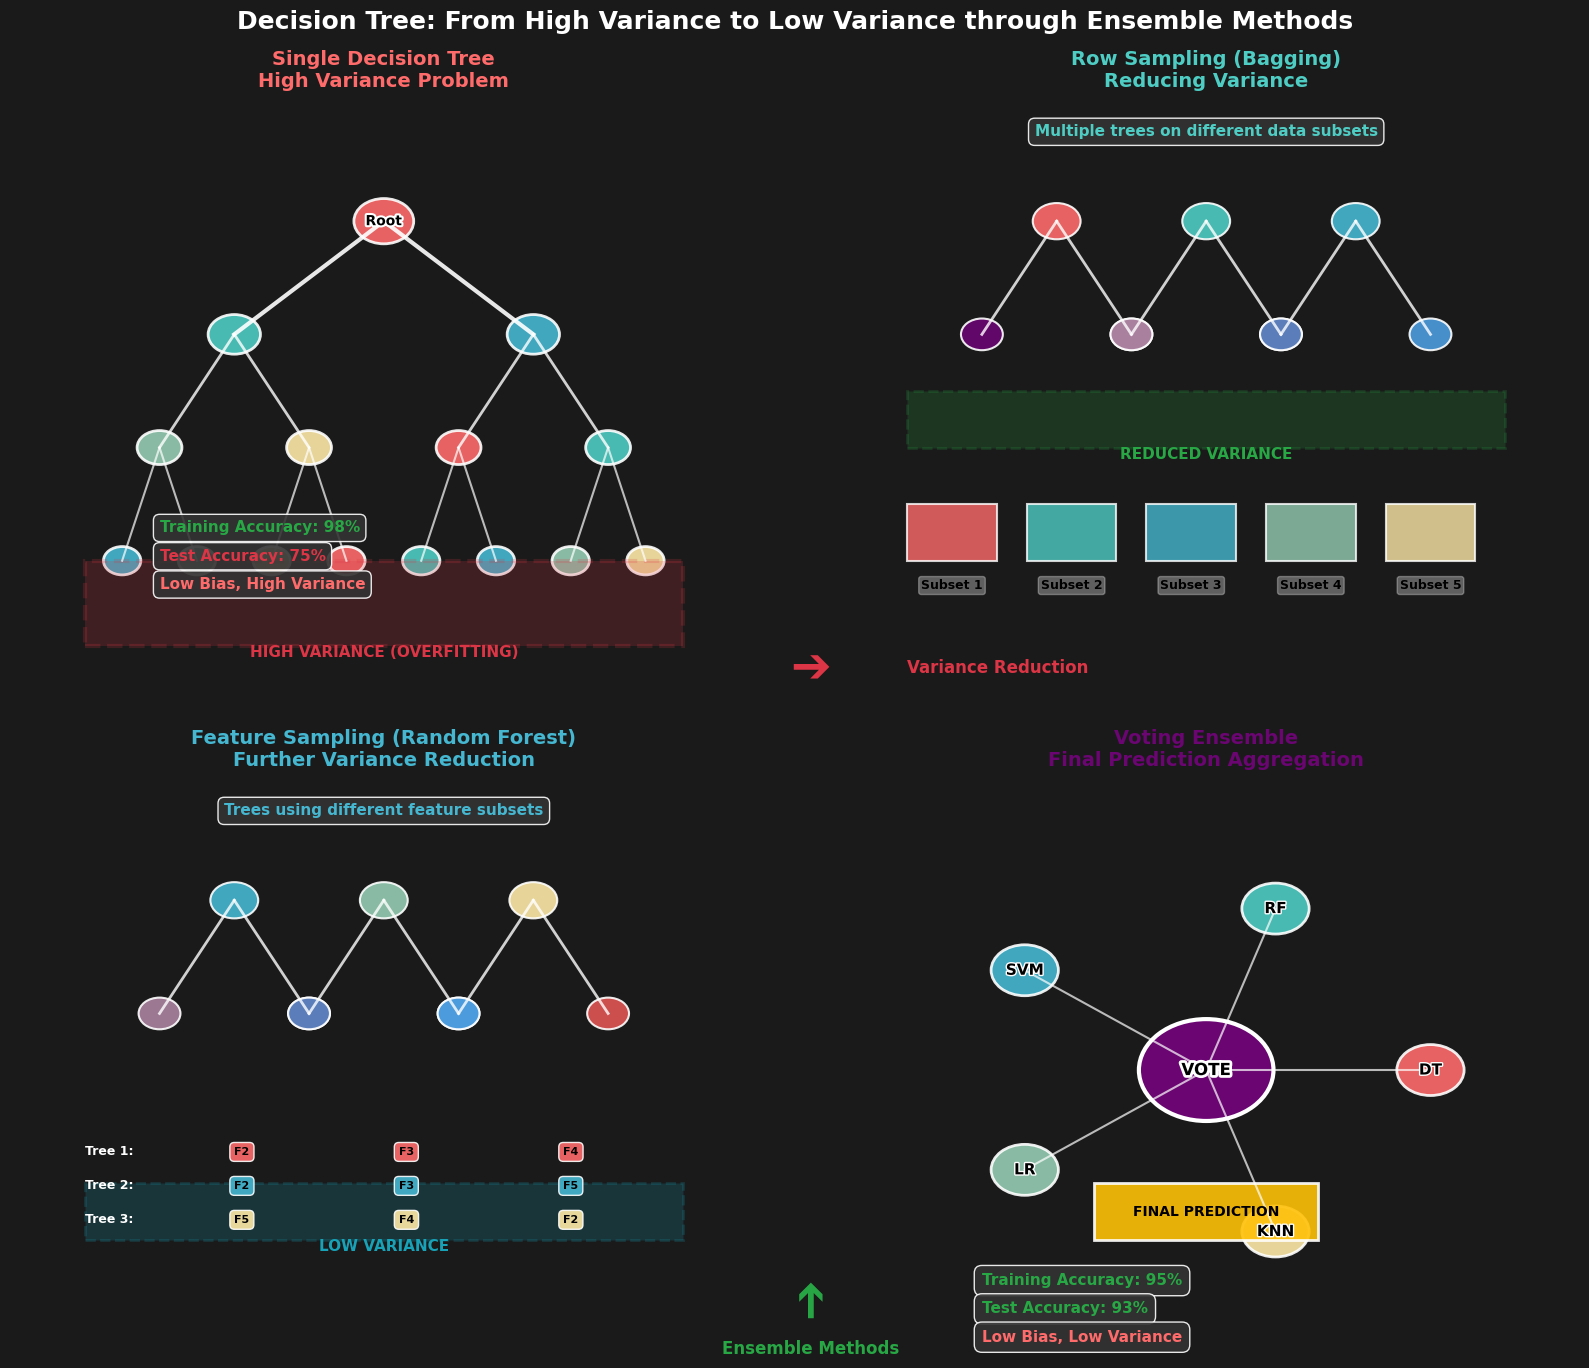

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
import matplotlib.patheffects as path_effects

# Set dark theme
plt.style.use('dark_background')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'

# Create figure with adjusted spacing
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 14))
fig.patch.set_facecolor('#1a1a1a')  # Dark background

# Main title with more spacing
fig.suptitle('Decision Tree: From High Variance to Low Variance through Ensemble Methods', 
             fontsize=18, fontweight='bold', y=0.97, color='#ffffff')

# Dark theme color palette
colors = {
    'primary': ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7'],  # Bright colors for contrast
    'accent': ['#6A0572', '#AB83A1', '#5C80BC', '#4D9DE0', '#E15554'],
    'background': ['#2d2d2d', '#3d3d3d', '#4d4d4d'],  # Dark grays
    'success': '#28A745',
    'warning': '#FFC107',
    'danger': '#DC3545',
    'info': '#17A2B8',
    'text': '#ffffff',
    'grid': '#444444'
}

# Remove axes for all subplots and set dark background
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.axis('off')
    ax.set_facecolor(colors['background'][0])

# 1. Single Decision Tree (High Variance)
ax1.set_title('Single Decision Tree\nHigh Variance Problem', fontsize=14, fontweight='bold', 
              pad=15, color=colors['primary'][0])

# Draw decision tree with bright colors
ax1.plot([5, 3], [8, 6], 'white', lw=3, alpha=0.9)
ax1.plot([5, 7], [8, 6], 'white', lw=3, alpha=0.9)
ax1.plot([3, 2], [6, 4], 'white', lw=2, alpha=0.8)
ax1.plot([3, 4], [6, 4], 'white', lw=2, alpha=0.8)
ax1.plot([7, 6], [6, 4], 'white', lw=2, alpha=0.8)
ax1.plot([7, 8], [6, 4], 'white', lw=2, alpha=0.8)
# Add leaf nodes
ax1.plot([2, 1.5], [4, 2], 'white', lw=1.5, alpha=0.7)
ax1.plot([2, 2.5], [4, 2], 'white', lw=1.5, alpha=0.7)
ax1.plot([4, 3.5], [4, 2], 'white', lw=1.5, alpha=0.7)
ax1.plot([4, 4.5], [4, 2], 'white', lw=1.5, alpha=0.7)
ax1.plot([6, 5.5], [4, 2], 'white', lw=1.5, alpha=0.7)
ax1.plot([6, 6.5], [4, 2], 'white', lw=1.5, alpha=0.7)
ax1.plot([8, 7.5], [4, 2], 'white', lw=1.5, alpha=0.7)
ax1.plot([8, 8.5], [4, 2], 'white', lw=1.5, alpha=0.7)

# Nodes with bright colors (including leaf nodes)
nodes = [
    (5, 8, 0.4), (3, 6, 0.35), (7, 6, 0.35), 
    (2, 4, 0.3), (4, 4, 0.3), (6, 4, 0.3), (8, 4, 0.3),
    (1.5, 2, 0.25), (2.5, 2, 0.25), (3.5, 2, 0.25), (4.5, 2, 0.25),
    (5.5, 2, 0.25), (6.5, 2, 0.25), (7.5, 2, 0.25), (8.5, 2, 0.25)
]
for (x, y, size), color in zip(nodes, colors['primary'] * 3):  # Repeat colors for all nodes
    ax1.add_patch(Circle((x, y), size, fill=True, color=color, ec='white', lw=2, alpha=0.9))

# Bias-Variance visualization
ax1.add_patch(Rectangle((1, 0.5), 8, 1.5, fill=True, ec=colors['danger'], 
                       lw=3, linestyle='--', alpha=0.2, color=colors['danger']))
ax1.text(5, 0.3, 'HIGH VARIANCE (OVERFITTING)', ha='center', fontweight='bold', 
         color=colors['danger'], fontsize=11)

# Text annotations with dark background boxes
ax1.text(5, 8, 'Root', ha='center', va='center', fontweight='bold', color='black', 
         fontsize=10, path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])

text_bg = dict(boxstyle="round,pad=0.4", facecolor='#333333', alpha=0.9, ec='white')
ax1.text(2, 2.5, 'Training Accuracy: 98%', fontsize=11, color=colors['success'], 
         fontweight='bold', bbox=text_bg)
ax1.text(2, 2, 'Test Accuracy: 75%', fontsize=11, color=colors['danger'], 
         fontweight='bold', bbox=text_bg)
ax1.text(2, 1.5, 'Low Bias, High Variance', fontsize=11, color=colors['primary'][0], 
         fontweight='bold', bbox=text_bg)

# 2. Row Sampling (Bagging)
ax2.set_title('Row Sampling (Bagging)\nReducing Variance', fontsize=14, fontweight='bold', 
              pad=15, color=colors['primary'][1])

# Draw multiple trees
for i, offset in enumerate([-2, 0, 2]):
    x_center = 5 + offset
    tree_color = colors['primary'][i]
    
    ax2.plot([x_center, x_center-1], [8, 6], 'white', lw=2, alpha=0.8)
    ax2.plot([x_center, x_center+1], [8, 6], 'white', lw=2, alpha=0.8)
    
    ax2.add_patch(Circle((x_center, 8), 0.32, fill=True, color=tree_color, ec='white', lw=1.5, alpha=0.9))
    ax2.add_patch(Circle((x_center-1, 6), 0.28, fill=True, color=colors['accent'][i], ec='white', lw=1.5, alpha=0.9))
    ax2.add_patch(Circle((x_center+1, 6), 0.28, fill=True, color=colors['accent'][(i+1)%5], ec='white', lw=1.5, alpha=0.9))

# Data subsets visualization
for i in range(5):
    ax2.add_patch(Rectangle((1 + i*1.6, 2), 1.2, 1, fill=True, 
                          color=colors['primary'][i], alpha=0.8, ec='white', lw=1.5))
    ax2.text(1.6 + i*1.6, 1.5, f'Subset {i+1}', ha='center', fontsize=9, 
             fontweight='bold', color='black', bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.3))

# Bias-Variance visualization
ax2.add_patch(Rectangle((1, 4), 8, 1, fill=True, ec=colors['success'], 
                       lw=2, linestyle='--', alpha=0.2, color=colors['success']))
ax2.text(5, 3.8, 'REDUCED VARIANCE', ha='center', fontweight='bold', 
         color=colors['success'], fontsize=11)

ax2.text(5, 9.5, 'Multiple trees on different data subsets', ha='center', fontsize=11, 
         color=colors['primary'][1], fontweight='bold', bbox=text_bg)

# 3. Feature Sampling (Random Forest)
ax3.set_title('Feature Sampling (Random Forest)\nFurther Variance Reduction', fontsize=14, 
              fontweight='bold', pad=15, color=colors['primary'][2])

# Draw trees with different feature sets
for i, offset in enumerate([-2, 0, 2]):
    x_center = 5 + offset
    tree_color = colors['primary'][i+2]
    
    ax3.plot([x_center, x_center-1], [8, 6], 'white', lw=2, alpha=0.8)
    ax3.plot([x_center, x_center+1], [8, 6], 'white', lw=2, alpha=0.8)
    
    ax3.add_patch(Circle((x_center, 8), 0.32, fill=True, color=tree_color, ec='white', lw=1.5, alpha=0.9))
    ax3.add_patch(Circle((x_center-1, 6), 0.28, fill=True, color=colors['accent'][i+1], ec='white', lw=1.5, alpha=0.9))
    ax3.add_patch(Circle((x_center+1, 6), 0.28, fill=True, color=colors['accent'][i+2], ec='white', lw=1.5, alpha=0.9))

# Feature subsets visualization
features = ['F1', 'F2', 'F3', 'F4', 'F5', 'F6']
for i, tree_idx in enumerate([0, 2, 4]):
    y_pos = 3.5 - i*0.6
    ax3.text(1, y_pos, f'Tree {i+1}:', fontsize=9, fontweight='bold', color='white')
    
    selected_features = np.random.choice(features, 3, replace=False)
    for j, feat in enumerate(selected_features):
        ax3.text(3 + j*2.2, y_pos, feat, fontsize=8, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.4", facecolor=colors['primary'][tree_idx], 
                         alpha=0.9, ec='white'), color='black')

# Bias-Variance visualization
ax3.add_patch(Rectangle((1, 2), 8, 1, fill=True, ec=colors['info'], 
                       lw=2, linestyle='--', alpha=0.2, color=colors['info']))
ax3.text(5, 1.8, 'LOW VARIANCE', ha='center', fontweight='bold', 
         color=colors['info'], fontsize=11)

ax3.text(5, 9.5, 'Trees using different feature subsets', ha='center', fontsize=11, 
         color=colors['primary'][2], fontweight='bold', bbox=text_bg)

# 4. Voting Ensemble
ax4.set_title('Voting Ensemble\nFinal Prediction Aggregation', fontsize=14, fontweight='bold', 
              pad=15, color=colors['accent'][0])

# Draw model convergence
models = ['DT', 'RF', 'SVM', 'LR', 'KNN']
model_colors = colors['primary']

for i, (model, color) in enumerate(zip(models, model_colors)):
    angle = 2 * np.pi * i / len(models)
    x = 5 + 3 * np.cos(angle)
    y = 5 + 3 * np.sin(angle)
    
    ax4.add_patch(Circle((x, y), 0.45, fill=True, color=color, ec='white', lw=2, alpha=0.9))
    ax4.text(x, y, model, ha='center', va='center', fontweight='bold', color='black',
            fontsize=11, path_effects=[path_effects.withStroke(linewidth=2, foreground='white')])
    
    # Connection lines
    ax4.plot([x, 5], [y, 5], 'white', alpha=0.7, lw=1.5)

# Center voting mechanism
ax4.add_patch(Circle((5, 5), 0.9, fill=True, color=colors['accent'][0], ec='white', lw=3))
ax4.text(5, 5, 'VOTE', ha='center', va='center', fontweight='bold', color='black',
        fontsize=12, path_effects=[path_effects.withStroke(linewidth=4, foreground='white')])

# Final prediction
ax4.add_patch(Rectangle((3.5, 2), 3, 1, fill=True, color=colors['warning'], 
                       ec='white', lw=2, alpha=0.9))
ax4.text(5, 2.5, 'FINAL PREDICTION', ha='center', va='center', fontweight='bold',
         color='black', fontsize=10)

# Performance metrics
metrics_bg = dict(boxstyle="round,pad=0.5", facecolor='#333333', alpha=0.9, ec='white')
ax4.text(2, 1.2, 'Training Accuracy: 95%', fontsize=11, color=colors['success'], 
         fontweight='bold', bbox=metrics_bg)
ax4.text(2, 0.7, 'Test Accuracy: 93%', fontsize=11, color=colors['success'], 
         fontweight='bold', bbox=metrics_bg)
ax4.text(2, 0.2, 'Low Bias, Low Variance', fontsize=11, color=colors['primary'][0], 
         fontweight='bold', bbox=metrics_bg)

# Add arrows showing progression with labels
arrow_props = dict(fontsize=35, ha='center', va='center', fontweight='bold')
fig.text(0.51, 0.5, '➔', color=colors['danger'], **arrow_props)
fig.text(0.51, 0.05, '➔', color=colors['success'], rotation=90, **arrow_props)

# Add arrow labels
fig.text(0.57, 0.5, 'Variance Reduction', fontsize=12, fontweight='bold', 
         color=colors['danger'], ha='left', va='center')
fig.text(0.51, 0.02, 'Ensemble Methods', fontsize=12, fontweight='bold', 
         color=colors['success'], ha='center', va='top')

# Add subtle grid
for ax in [ax1, ax2, ax3, ax4]:
    ax.grid(True, alpha=0.1, color=colors['grid'], linestyle='-')


plt.tight_layout()
plt.subplots_adjust(top=0.90, wspace=0.1, hspace=0.2)  # Adjusted spacing
plt.show()

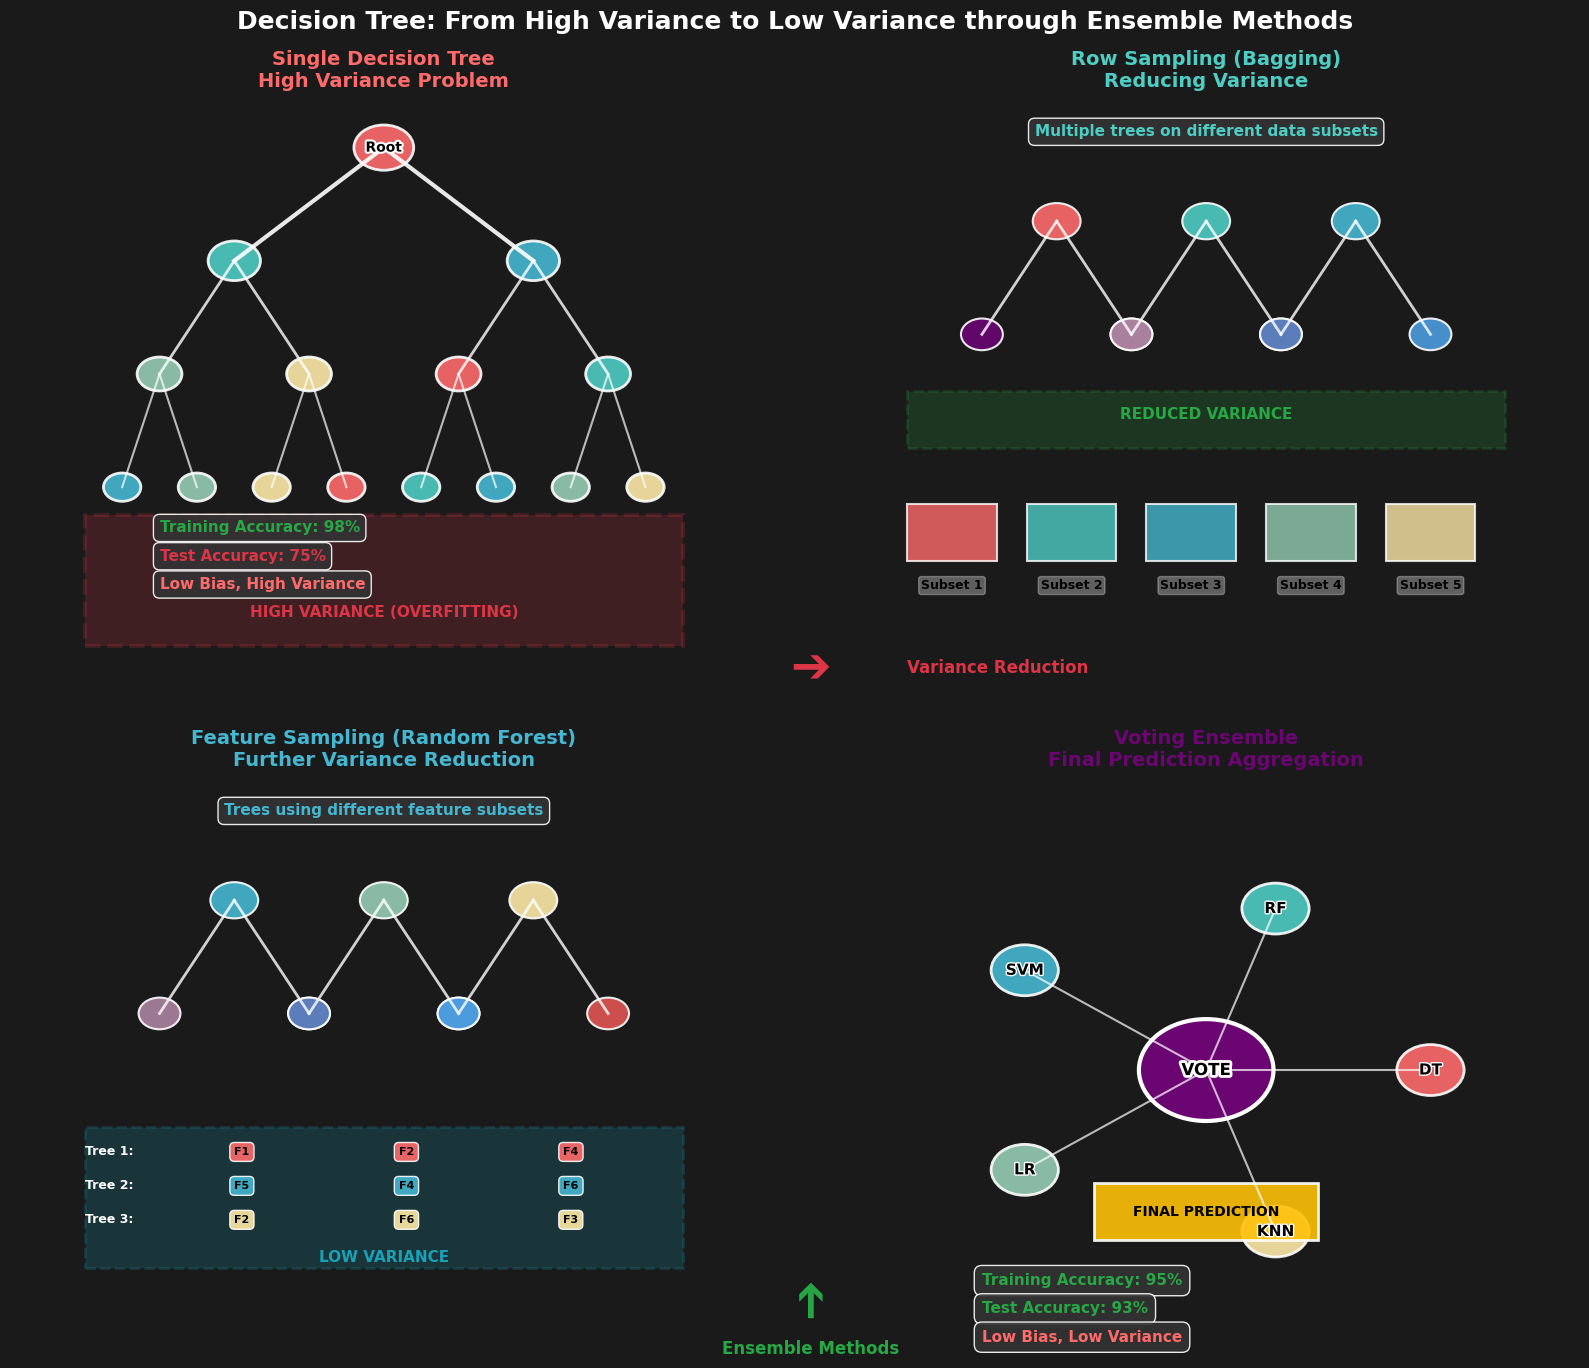

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
import matplotlib.patheffects as path_effects

# Set dark theme
plt.style.use('dark_background')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'

# Create figure with adjusted spacing
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 14))
fig.patch.set_facecolor('#1a1a1a')  # Dark background

# Main title with more spacing
fig.suptitle('Decision Tree: From High Variance to Low Variance through Ensemble Methods', 
             fontsize=18, fontweight='bold', y=0.97, color='#ffffff')

# Dark theme color palette
colors = {
    'primary': ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7'],  # Bright colors for contrast
    'accent': ['#6A0572', '#AB83A1', '#5C80BC', '#4D9DE0', '#E15554'],
    'background': ['#2d2d2d', '3d3d3d', '4d4d4d'],  # Dark grays
    'success': '#28A745',
    'warning': '#FFC107',
    'danger': '#DC3545',
    'info': '#17A2B8',
    'text': '#ffffff',
    'grid': '#444444'
}

# Remove axes for all subplots and set dark background
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.axis('off')
    ax.set_facecolor(colors['background'][0])

# 1. Single Decision Tree (High Variance)
ax1.set_title('Single Decision Tree\nHigh Variance Problem', fontsize=14, fontweight='bold', 
              pad=15, color=colors['primary'][0])

# Draw decision tree with bright colors - moved up by 1 unit
tree_offset = 1.3  # Added offset to move the entire tree up
ax1.plot([5, 3], [8+tree_offset, 6+tree_offset], 'white', lw=3, alpha=0.9)
ax1.plot([5, 7], [8+tree_offset, 6+tree_offset], 'white', lw=3, alpha=0.9)
ax1.plot([3, 2], [6+tree_offset, 4+tree_offset], 'white', lw=2, alpha=0.8)
ax1.plot([3, 4], [6+tree_offset, 4+tree_offset], 'white', lw=2, alpha=0.8)
ax1.plot([7, 6], [6+tree_offset, 4+tree_offset], 'white', lw=2, alpha=0.8)
ax1.plot([7, 8], [6+tree_offset, 4+tree_offset], 'white', lw=2, alpha=0.8)
# Add leaf nodes
ax1.plot([2, 1.5], [4+tree_offset, 2+tree_offset], 'white', lw=1.5, alpha=0.7)
ax1.plot([2, 2.5], [4+tree_offset, 2+tree_offset], 'white', lw=1.5, alpha=0.7)
ax1.plot([4, 3.5], [4+tree_offset, 2+tree_offset], 'white', lw=1.5, alpha=0.7)
ax1.plot([4, 4.5], [4+tree_offset, 2+tree_offset], 'white', lw=1.5, alpha=0.7)
ax1.plot([6, 5.5], [4+tree_offset, 2+tree_offset], 'white', lw=1.5, alpha=0.7)
ax1.plot([6, 6.5], [4+tree_offset, 2+tree_offset], 'white', lw=1.5, alpha=0.7)
ax1.plot([8, 7.5], [4+tree_offset, 2+tree_offset], 'white', lw=1.5, alpha=0.7)
ax1.plot([8, 8.5], [4+tree_offset, 2+tree_offset], 'white', lw=1.5, alpha=0.7)

# Nodes with bright colors (including leaf nodes) - moved up
nodes = [
    (5, 8+tree_offset, 0.4), (3, 6+tree_offset, 0.35), (7, 6+tree_offset, 0.35), 
    (2, 4+tree_offset, 0.3), (4, 4+tree_offset, 0.3), (6, 4+tree_offset, 0.3), (8, 4+tree_offset, 0.3),
    (1.5, 2+tree_offset, 0.25), (2.5, 2+tree_offset, 0.25), (3.5, 2+tree_offset, 0.25), (4.5, 2+tree_offset, 0.25),
    (5.5, 2+tree_offset, 0.25), (6.5, 2+tree_offset, 0.25), (7.5, 2+tree_offset, 0.25), (8.5, 2+tree_offset, 0.25)
]
for (x, y, size), color in zip(nodes, colors['primary'] * 3):  # Repeat colors for all nodes
    ax1.add_patch(Circle((x, y), size, fill=True, color=color, ec='white', lw=2, alpha=0.9))

# Bias-Variance visualization
new_offset=0.7
ax1.add_patch(Rectangle((1, 0.5), 8, 2.3, fill=True, ec=colors['danger'], 
                       lw=3, linestyle='--', alpha=0.2, color=colors['danger']))
ax1.text(5, 0.3+new_offset, 'HIGH VARIANCE (OVERFITTING)', ha='center', fontweight='bold', 
         color=colors['danger'], fontsize=11)

# Text annotations with dark background boxes - moved down to avoid overlap
text_bg = dict(boxstyle="round,pad=0.4", facecolor='#333333', alpha=0.9, ec='white')
ax1.text(2, 2.5, 'Training Accuracy: 98%', fontsize=11, color=colors['success'], 
         fontweight='bold', bbox=text_bg)
ax1.text(2, 2, 'Test Accuracy: 75%', fontsize=11, color=colors['danger'], 
         fontweight='bold', bbox=text_bg)
ax1.text(2, 1.5, 'Low Bias, High Variance', fontsize=11, color=colors['primary'][0], 
         fontweight='bold', bbox=text_bg)

# Root node label - moved up with the tree
ax1.text(5, 8+tree_offset, 'Root', ha='center', va='center', fontweight='bold', color='black', 
         fontsize=10, path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])

# 2. Row Sampling (Bagging)
ax2.set_title('Row Sampling (Bagging)\nReducing Variance', fontsize=14, fontweight='bold', 
              pad=15, color=colors['primary'][1])

# Draw multiple trees
for i, offset in enumerate([-2, 0, 2]):
    x_center = 5 + offset
    tree_color = colors['primary'][i]
    
    ax2.plot([x_center, x_center-1], [8, 6], 'white', lw=2, alpha=0.8)
    ax2.plot([x_center, x_center+1], [8, 6], 'white', lw=2, alpha=0.8)
    
    ax2.add_patch(Circle((x_center, 8), 0.32, fill=True, color=tree_color, ec='white', lw=1.5, alpha=0.9))
    ax2.add_patch(Circle((x_center-1, 6), 0.28, fill=True, color=colors['accent'][i], ec='white', lw=1.5, alpha=0.9))
    ax2.add_patch(Circle((x_center+1, 6), 0.28, fill=True, color=colors['accent'][(i+1)%5], ec='white', lw=1.5, alpha=0.9))

# Data subsets visualization
for i in range(5):
    ax2.add_patch(Rectangle((1 + i*1.6, 2), 1.2, 1, fill=True, 
                          color=colors['primary'][i], alpha=0.8, ec='white', lw=1.5))
    ax2.text(1.6 + i*1.6, 1.5, f'Subset {i+1}', ha='center', fontsize=9, 
             fontweight='bold', color='black', bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.3))

# Bias-Variance visualization
tee_offset=0.7
ax2.add_patch(Rectangle((1, 4), 8, 1, fill=True, ec=colors['success'], 
                       lw=2, linestyle='--', alpha=0.2, color=colors['success']))
ax2.text(5, 3.8+tee_offset, 'REDUCED VARIANCE', ha='center', fontweight='bold', 
         color=colors['success'], fontsize=11)

ax2.text(5, 9.5, 'Multiple trees on different data subsets', ha='center', fontsize=11, 
         color=colors['primary'][1], fontweight='bold', bbox=text_bg)

# 3. Feature Sampling (Random Forest)
ax3.set_title('Feature Sampling (Random Forest)\nFurther Variance Reduction', fontsize=14, 
              fontweight='bold', pad=15, color=colors['primary'][2])

# Draw trees with different feature sets
for i, offset in enumerate([-2, 0, 2]):
    x_center = 5 + offset
    tree_color = colors['primary'][i+2]
    
    ax3.plot([x_center, x_center-1], [8, 6], 'white', lw=2, alpha=0.8)
    ax3.plot([x_center, x_center+1], [8, 6], 'white', lw=2, alpha=0.8)
    
    ax3.add_patch(Circle((x_center, 8), 0.32, fill=True, color=tree_color, ec='white', lw=1.5, alpha=0.9))
    ax3.add_patch(Circle((x_center-1, 6), 0.28, fill=True, color=colors['accent'][i+1], ec='white', lw=1.5, alpha=0.9))
    ax3.add_patch(Circle((x_center+1, 6), 0.28, fill=True, color=colors['accent'][i+2], ec='white', lw=1.5, alpha=0.9))

# Feature subsets visualization
features = ['F1', 'F2', 'F3', 'F4', 'F5', 'F6']
for i, tree_idx in enumerate([0, 2, 4]):
    y_pos = 3.5 - i*0.6
    ax3.text(1, y_pos, f'Tree {i+1}:', fontsize=9, fontweight='bold', color='white')
    
    selected_features = np.random.choice(features, 3, replace=False)
    for j, feat in enumerate(selected_features):
        ax3.text(3 + j*2.2, y_pos, feat, fontsize=8, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.4", facecolor=colors['primary'][tree_idx], 
                         alpha=0.9, ec='white'), color='black')

# Bias-Variance visualization
ax3.add_patch(Rectangle((1, 1.5), 8, 2.5, fill=True, ec=colors['info'], 
                       lw=2, linestyle='--', alpha=0.2, color=colors['info']))
ax3.text(5, 1.6, 'LOW VARIANCE', ha='center', fontweight='bold', 
         color=colors['info'], fontsize=11)

ax3.text(5, 9.5, 'Trees using different feature subsets', ha='center', fontsize=11, 
         color=colors['primary'][2], fontweight='bold', bbox=text_bg)

# 4. Voting Ensemble
ax4.set_title('Voting Ensemble\nFinal Prediction Aggregation', fontsize=14, fontweight='bold', 
              pad=15, color=colors['accent'][0])

# Draw model convergence
models = ['DT', 'RF', 'SVM', 'LR', 'KNN']
model_colors = colors['primary']

for i, (model, color) in enumerate(zip(models, model_colors)):
    angle = 2 * np.pi * i / len(models)
    x = 5 + 3 * np.cos(angle)
    y = 5 + 3 * np.sin(angle)
    
    ax4.add_patch(Circle((x, y), 0.45, fill=True, color=color, ec='white', lw=2, alpha=0.9))
    ax4.text(x, y, model, ha='center', va='center', fontweight='bold', color='black',
            fontsize=11, path_effects=[path_effects.withStroke(linewidth=2, foreground='white')])
    
    # Connection lines
    ax4.plot([x, 5], [y, 5], 'white', alpha=0.7, lw=1.5)

# Center voting mechanism
ax4.add_patch(Circle((5, 5), 0.9, fill=True, color=colors['accent'][0], ec='white', lw=3))
ax4.text(5, 5, 'VOTE', ha='center', va='center', fontweight='bold', color='black',
        fontsize=12, path_effects=[path_effects.withStroke(linewidth=4, foreground='white')])

# Final prediction
ax4.add_patch(Rectangle((3.5, 2), 3, 1, fill=True, color=colors['warning'], 
                       ec='white', lw=2, alpha=0.9))
ax4.text(5, 2.5, 'FINAL PREDICTION', ha='center', va='center', fontweight='bold',
         color='black', fontsize=10)

# Performance metrics
metrics_bg = dict(boxstyle="round,pad=0.5", facecolor='#333333', alpha=0.9, ec='white')
ax4.text(2, 1.2, 'Training Accuracy: 95%', fontsize=11, color=colors['success'], 
         fontweight='bold', bbox=metrics_bg)
ax4.text(2, 0.7, 'Test Accuracy: 93%', fontsize=11, color=colors['success'], 
         fontweight='bold', bbox=metrics_bg)
ax4.text(2, 0.2, 'Low Bias, Low Variance', fontsize=11, color=colors['primary'][0], 
         fontweight='bold', bbox=metrics_bg)

# Add arrows showing progression with labels
arrow_props = dict(fontsize=35, ha='center', va='center', fontweight='bold')
fig.text(0.51, 0.5, '➔', color=colors['danger'], **arrow_props)
fig.text(0.51, 0.05, '➔', color=colors['success'], rotation=90, **arrow_props)

# Add arrow labels
fig.text(0.57, 0.5, 'Variance Reduction', fontsize=12, fontweight='bold', 
         color=colors['danger'], ha='left', va='center')
fig.text(0.51, 0.02, 'Ensemble Methods', fontsize=12, fontweight='bold', 
         color=colors['success'], ha='center', va='top')

# Add subtle grid
for ax in [ax1, ax2, ax3, ax4]:
    ax.grid(True, alpha=0.1, color=colors['grid'], linestyle='-')


plt.tight_layout()
plt.subplots_adjust(top=0.90, wspace=0.1, hspace=0.2)  # Adjusted spacing
plt.show()

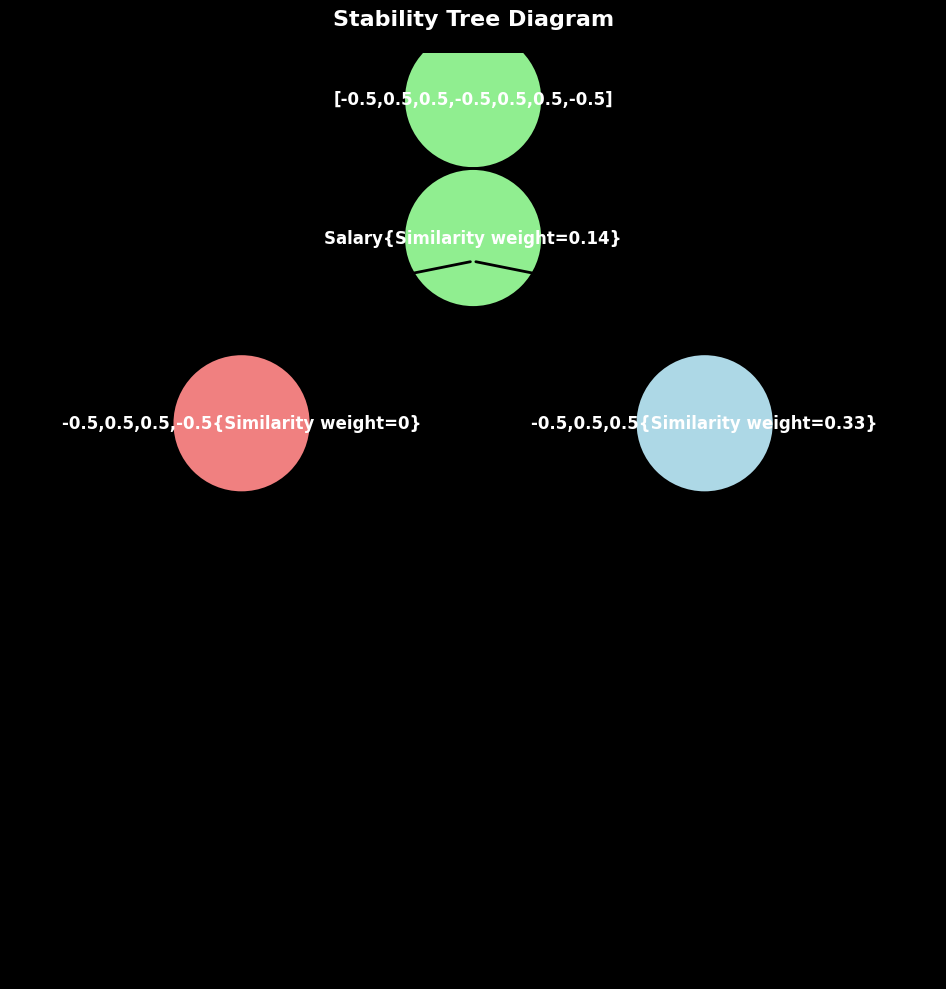

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.path import Path

# Set up the figure
fig, ax = plt.subplots(figsize=(12, 10))
ax.set_xlim(-1, 1)
ax.set_ylim(-0.5, 1.5)
ax.set_aspect('equal')
ax.axis('off')

plt.style.use('dark_background')

# Title
plt.title('Stability Tree Diagram', fontsize=16, fontweight='bold', pad=20)

# Draw the main nodes
def draw_node(x, y, text, color='lightblue', size=0.15):
    circle = patches.Circle((x, y), size, facecolor=color, edgecolor='black', linewidth=2)
    ax.add_patch(circle)
    ax.text(x, y, text, ha='center', va='center', fontsize=12, fontweight='bold')
    return circle

# Draw connection arrows
def draw_arrow(x1, y1, x2, y2, text=None, text_offset=0):
    ax.annotate('', xy=(x2, y2), xytext=(x1, y1),
                arrowprops=dict(arrowstyle='->', lw=2, color='black'))
    if text:
        ax.text((x1+x2)/2, (y1+y2)/2 + text_offset, text, 
                ha='center', va='center', fontsize=11, 
                bbox=dict(boxstyle="round,pad=0.2", facecolor="white", edgecolor="none", alpha=0.7))

root = draw_node(0, 1.5, "[-0.5,0.5,0.5,-0.5,0.5,0.5,-0.5]", color='lightgreen')
# Draw the tree structure
# Root node
root = draw_node(0, 1.2, "Salary{Similarity weight=0.14}", color='lightgreen')

# First level
node1 = draw_node(-0.5, 0.8, "-0.5,0.5,0.5,-0.5{Similarity weight=0}", color='lightcoral')
node2 = draw_node(0.5, 0.8, "-0.5,0.5,0.5{Similarity weight=0.33}", color='lightblue')

# Connect root to first level
draw_arrow(0, 1.05, -0.5, 0.95)
draw_arrow(0, 1.05, 0.5, 0.95)

# Add a subtle background grid
ax.grid(True, alpha=0.1, linestyle='--')

plt.tight_layout()
plt.show()

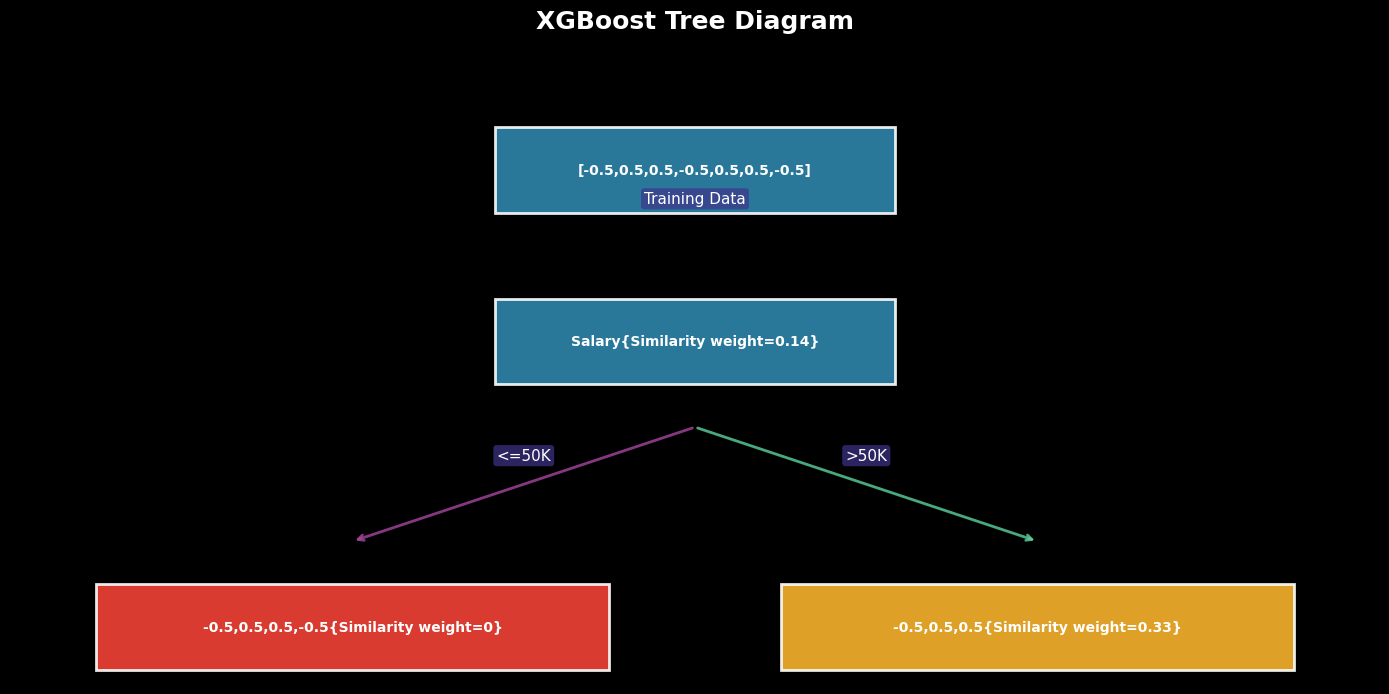

In [28]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Set up the figure with dark background
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(14, 8))  # Reduced height from 12 to 8
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(0.9, 2.0)  # Reduced bottom limit from -0.5 to 0.5 to cut unused space
ax.set_aspect('equal')
ax.axis('off')

# Title
plt.title('XGBoost Tree Diagram', fontsize=18, fontweight='bold', pad=20, color='white')

# Draw rectangular nodes
def draw_rect_node(x, y, text, color='#2E86AB', width=0.7, height=0.15):
    rect = patches.Rectangle((x-width/2, y-height/2), width, height, 
                            facecolor=color, edgecolor='white', linewidth=2, alpha=0.9)
    ax.add_patch(rect)
    ax.text(x, y, text, ha='center', va='center', fontsize=10, fontweight='bold', color='white')
    return rect

# Draw connection arrows with visible colors
def draw_arrow(x1, y1, x2, y2, text=None, text_offset=0, color='#F24236'):
    ax.annotate('', xy=(x2, y2), xytext=(x1, y1),
                arrowprops=dict(arrowstyle='->', lw=2, color=color, alpha=0.8))
    if text:
        ax.text((x1+x2)/2, (y1+y2)/2 + text_offset, text, 
                ha='center', va='center', fontsize=11, color='white',
                bbox=dict(boxstyle="round,pad=0.2", facecolor="#3D348B", edgecolor="none", alpha=0.7))

def draw_rec_node(x, y, text, color='#2E86AB', width=0.9, height=0.15):
    rect = patches.Rectangle((x-width/2, y-height/2), width, height, 
                            facecolor=color, edgecolor='white', linewidth=2, alpha=0.9)
    ax.add_patch(rect)
    ax.text(x, y, text, ha='center', va='center', fontsize=10, fontweight='bold', color='white')
    return rect

# Keep the root1 node at the top
root1 = draw_rect_node(0, 1.8, "[-0.5,0.5,0.5,-0.5,0.5,0.5,-0.5]", color='#2E86AB')

# Shift the entire tree downward to prevent overlapping
# Root node
root = draw_rect_node(0, 1.5, "Salary{Similarity weight=0.14}", color='#2E86AB')

# First level
node1 = draw_rec_node(-0.6, 1.0, "-0.5,0.5,0.5,-0.5{Similarity weight=0}", color='#F24236')
node2 = draw_rec_node(0.6, 1.0, "-0.5,0.5,0.5{Similarity weight=0.33}", color='#F7B32B')

# Connect root to first level
draw_arrow(0, 1.35, -0.6, 1.15, "<=50K", 0.05, color='#A846A0')
draw_arrow(0, 1.35, 0.6, 1.15, ">50K", 0.05, color='#5DD39E')

# Add arrow from root1 to root
draw_arrow(0, 1.65, 0, 1.65, "Training Data", 0.1, color='#FF6B6B')

# Add a subtle background grid
ax.grid(True, alpha=0.05, linestyle='--', color='white')

plt.tight_layout()
plt.show()

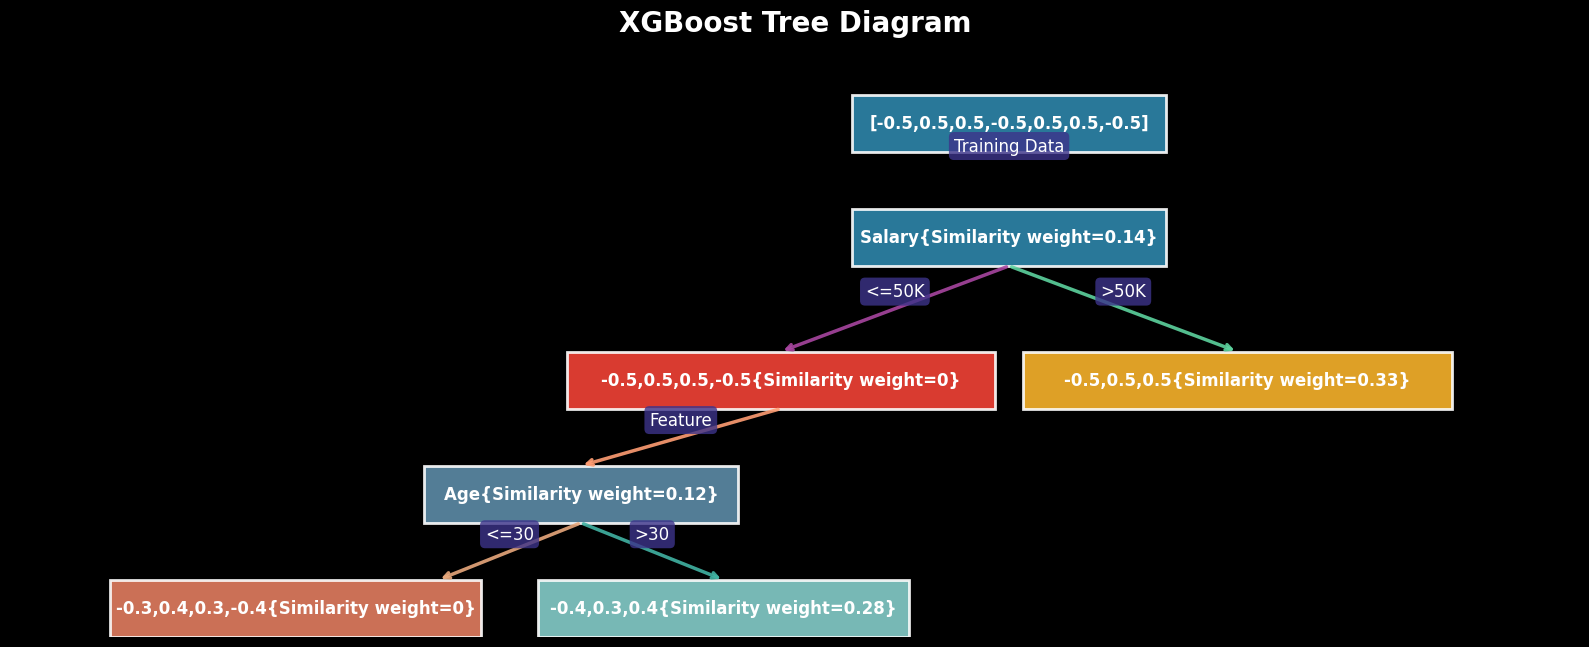

In [72]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Set up the figure with dark background
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(16, 12))  # Increased size for better visibility
ax.set_xlim(-3.5, 2)  # Extended x-limit
ax.set_ylim(0.2, 2.2)  # Extended y-limit
ax.set_aspect('equal')
ax.axis('off')

# Title
plt.title('XGBoost Tree Diagram', fontsize=20, fontweight='bold', pad=25, color='white')

# Draw rectangular nodes with increased size
def draw_rect_node(x, y, text, color='#2E86AB', width=1.1, height=0.2):
    rect = patches.Rectangle((x-width/2, y-height/2), width, height, 
                            facecolor=color, edgecolor='white', linewidth=2, alpha=0.9)
    ax.add_patch(rect)
    ax.text(x, y, text, ha='center', va='center', fontsize=12, fontweight='bold', color='white')
    return rect

# Draw connection arrows with visible colors
def draw_arrow(x1, y1, x2, y2, text=None, text_offset=0, color='#F24236'):
    ax.annotate('', xy=(x2, y2), xytext=(x1, y1),
                arrowprops=dict(arrowstyle='->', lw=2.5, color=color, alpha=0.9))
    if text:
        ax.text((x1+x2)/2, (y1+y2)/2 + text_offset, text, 
                ha='center', va='center', fontsize=12, color='white',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="#3D348B", edgecolor="none", alpha=0.8))

def draw_rec_node(x, y, text, color='#2E86AB', width=1.5, height=0.2):
    rect = patches.Rectangle((x-width/2, y-height/2), width, height, 
                            facecolor=color, edgecolor='white', linewidth=2, alpha=0.9)
    ax.add_patch(rect)
    ax.text(x, y, text, ha='center', va='center', fontsize=12, fontweight='bold', color='white')
    return rect

def draw_recs_node(x, y, text, color='#2E86AB', width=1.3, height=0.2):
    rect = patches.Rectangle((x-width/2, y-height/2), width, height, 
                            facecolor=color, edgecolor='white', linewidth=2, alpha=0.9)
    ax.add_patch(rect)
    ax.text(x, y, text, ha='center', va='center', fontsize=12, fontweight='bold', color='white')
    return rect

# Keep the root1 node at the top
root1 = draw_rect_node(0, 2.0, "[-0.5,0.5,0.5,-0.5,0.5,0.5,-0.5]", color='#2E86AB')

# Main tree
root = draw_rect_node(0, 1.6, "Salary{Similarity weight=0.14}", color='#2E86AB')

# First level
node1 = draw_rec_node(-0.8, 1.1, "-0.5,0.5,0.5,-0.5{Similarity weight=0}", color='#F24236')
node2 = draw_rec_node(0.8, 1.1, "-0.5,0.5,0.5{Similarity weight=0.33}", color='#F7B32B')

# Connect root to first level
draw_arrow(0, 1.5, -0.8, 1.2, "<=50K", 0.06, color='#A846A0')
draw_arrow(0, 1.5, 0.8, 1.2, ">50K", 0.06, color='#5DD39E')

# Add arrow from root1 to root
draw_arrow(0, 1.8, 0, 1.8, "Training Data", 0.12, color='#FF6B6B')

# Create subtree below node1 (replicating the main tree structure)
sub_root = draw_rect_node(-1.5, 0.7, "Age{Similarity weight=0.12}", color='#5D8CA8')
draw_arrow(-0.8, 1.0, -1.5, 0.8, "Feature", 0.06, color='#FF9D73')

# Subtree first level
sub_node1 = draw_recs_node(-2.5, 0.3, "-0.3,0.4,0.3,-0.4{Similarity weight=0}", color='#E27D60')
sub_node2 = draw_recs_node(-1.0, 0.3, "-0.4,0.3,0.4{Similarity weight=0.28}", color='#85CDCA')

# Connect sub_root to sub_nodes
draw_arrow(-1.5, 0.6, -2.0, 0.4, "<=30", 0.06, color='#E8A87C')
draw_arrow(-1.5, 0.6, -1.0, 0.4, ">30", 0.06, color='#41B3A3')

# Add a subtle background grid
ax.grid(True, alpha=0.05, linestyle='--', color='white')

plt.tight_layout()
plt.show()

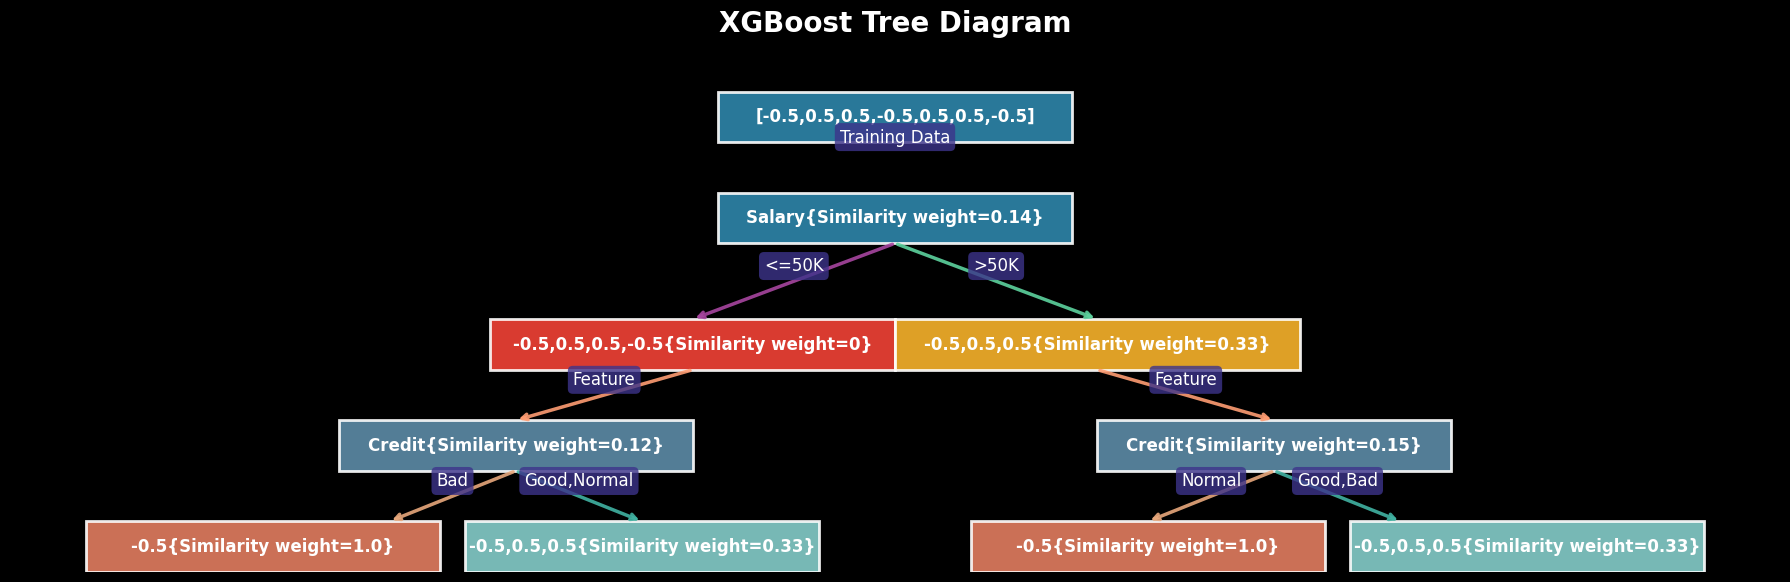

In [77]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Set up the figure with dark background
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(18, 12))  # Increased width to accommodate both subtrees
ax.set_xlim(-3.5, 3.5)  # Extended x-limit to accommodate both subtrees
ax.set_ylim(0.2, 2.2)
ax.set_aspect('equal')
ax.axis('off')

# Title
plt.title('XGBoost Tree Diagram', fontsize=20, fontweight='bold', pad=25, color='white')

# Draw rectangular nodes with increased size
def draw_rect_node(x, y, text, color='#2E86AB', width=1.4, height=0.2):
    rect = patches.Rectangle((x-width/2, y-height/2), width, height, 
                            facecolor=color, edgecolor='white', linewidth=2, alpha=0.9)
    ax.add_patch(rect)
    ax.text(x, y, text, ha='center', va='center', fontsize=12, fontweight='bold', color='white')
    return rect

# Draw connection arrows with visible colors
def draw_arrow(x1, y1, x2, y2, text=None, text_offset=0, color='#F24236'):
    ax.annotate('', xy=(x2, y2), xytext=(x1, y1),
                arrowprops=dict(arrowstyle='->', lw=2.5, color=color, alpha=0.9))
    if text:
        ax.text((x1+x2)/2, (y1+y2)/2 + text_offset, text, 
                ha='center', va='center', fontsize=12, color='white',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="#3D348B", edgecolor="none", alpha=0.8))

def draw_rec_node(x, y, text, color='#2E86AB', width=1.6, height=0.2):
    rect = patches.Rectangle((x-width/2, y-height/2), width, height, 
                            facecolor=color, edgecolor='white', linewidth=2, alpha=0.9)
    ax.add_patch(rect)
    ax.text(x, y, text, ha='center', va='center', fontsize=12, fontweight='bold', color='white')
    return rect

def draw_recs_node(x, y, text, color='#2E86AB', width=1.4, height=0.2):
    rect = patches.Rectangle((x-width/2, y-height/2), width, height, 
                            facecolor=color, edgecolor='white', linewidth=2, alpha=0.9)
    ax.add_patch(rect)
    ax.text(x, y, text, ha='center', va='center', fontsize=12, fontweight='bold', color='white')
    return rect

# Keep the root1 node at the top
root1 = draw_rect_node(0, 2.0, "[-0.5,0.5,0.5,-0.5,0.5,0.5,-0.5]", color='#2E86AB')

# Main tree
root = draw_rect_node(0, 1.6, "Salary{Similarity weight=0.14}", color='#2E86AB')

# First level
node1 = draw_rec_node(-0.8, 1.1, "-0.5,0.5,0.5,-0.5{Similarity weight=0}", color='#F24236')
node2 = draw_rec_node(0.8, 1.1, "-0.5,0.5,0.5{Similarity weight=0.33}", color='#F7B32B')

# Connect root to first level
draw_arrow(0, 1.5, -0.8, 1.2, "<=50K", 0.06, color='#A846A0')
draw_arrow(0, 1.5, 0.8, 1.2, ">50K", 0.06, color='#5DD39E')

# Add arrow from root1 to root
draw_arrow(0, 1.8, 0, 1.8, "Training Data", 0.12, color='#FF6B6B')

# Create left subtree below node1
left_sub_root = draw_rect_node(-1.5, 0.7, "Credit{Similarity weight=0.12}", color='#5D8CA8')
draw_arrow(-0.8, 1.0, -1.5, 0.8, "Feature", 0.06, color='#FF9D73')

# Left subtree first level
left_sub_node1 = draw_recs_node(-2.5, 0.3, "-0.5{Similarity weight=1.0}", color='#E27D60')
left_sub_node2 = draw_recs_node(-1.0, 0.3, "-0.5,0.5,0.5{Similarity weight=0.33}", color='#85CDCA')

# Connect left sub_root to sub_nodes
draw_arrow(-1.5, 0.6, -2.0, 0.4, "Bad", 0.06, color='#E8A87C')
draw_arrow(-1.5, 0.6, -1.0, 0.4, "Good,Normal", 0.06, color='#41B3A3')

# Create right subtree below node2
right_sub_root = draw_rect_node(1.5, 0.7, "Credit{Similarity weight=0.15}", color='#5D8CA8')
draw_arrow(0.8, 1.0, 1.5, 0.8, "Feature", 0.06, color='#FF9D73')

# Right subtree first level
right_sub_node1 = draw_recs_node(1.0, 0.3, "-0.5{Similarity weight=1.0}", color='#E27D60')
right_sub_node2 = draw_recs_node(2.5, 0.3, "-0.5,0.5,0.5{Similarity weight=0.33}", color='#85CDCA')

# Connect right sub_root to sub_nodes
draw_arrow(1.5, 0.6, 1.0, 0.4, "Normal", 0.06, color='#E8A87C')
draw_arrow(1.5, 0.6, 2.0, 0.4, "Good,Bad", 0.06, color='#41B3A3')

# Add a subtle background grid
ax.grid(True, alpha=0.05, linestyle='--', color='white')

plt.tight_layout()
plt.show()

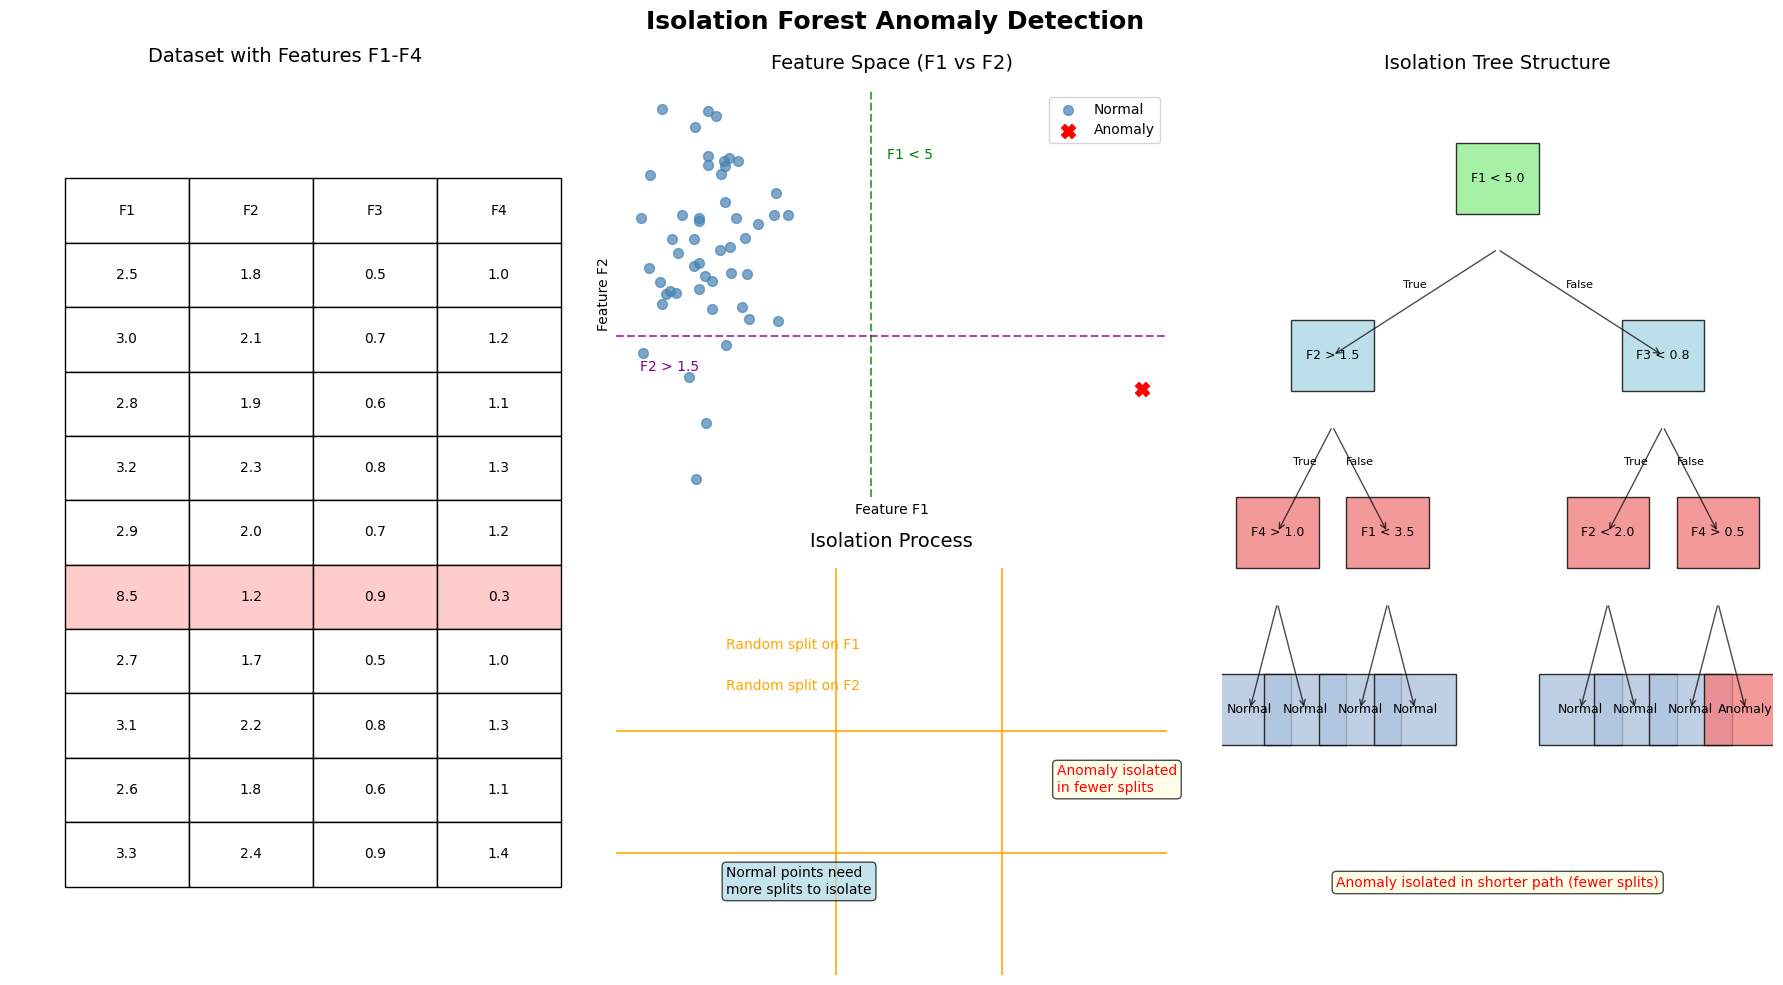

In [79]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from matplotlib.table import Table
import pandas as pd

# Set up the figure
plt.style.use('default')
fig = plt.figure(figsize=(18, 10))

# Create a grid for the layout
gs = fig.add_gridspec(2, 3, width_ratios=[1, 1, 1], height_ratios=[1, 1])

# Left side: Dataset and feature space
ax1 = fig.add_subplot(gs[:, 0])  # Dataset table
ax2 = fig.add_subplot(gs[0, 1])  # Feature space plot
ax3 = fig.add_subplot(gs[1, 1])  # Isolation process
ax4 = fig.add_subplot(gs[:, 2])  # Decision tree

# Remove axes for all subplots
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

# Title for the entire figure
fig.suptitle('Isolation Forest Anomaly Detection', fontsize=18, fontweight='bold')

# 1. Dataset table
data = {
    'F1': [2.5, 3.0, 2.8, 3.2, 2.9, 8.5, 2.7, 3.1, 2.6, 3.3],
    'F2': [1.8, 2.1, 1.9, 2.3, 2.0, 1.2, 1.7, 2.2, 1.8, 2.4],
    'F3': [0.5, 0.7, 0.6, 0.8, 0.7, 0.9, 0.5, 0.8, 0.6, 0.9],
    'F4': [1.0, 1.2, 1.1, 1.3, 1.2, 0.3, 1.0, 1.3, 1.1, 1.4]
}
df = pd.DataFrame(data)

ax1.set_title('Dataset with Features F1-F4', fontsize=14, pad=20)
table = ax1.table(cellText=df.values, 
                 colLabels=df.columns, 
                 cellLoc='center', 
                 loc='center',
                 bbox=[0.1, 0.1, 0.9, 0.8])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

# Highlight the anomaly row (index 5)
table[(6, 0)].set_facecolor('#ffcccc')
table[(6, 1)].set_facecolor('#ffcccc')
table[(6, 2)].set_facecolor('#ffcccc')
table[(6, 3)].set_facecolor('#ffcccc')

# 2. Feature space plot
np.random.seed(42)
# Generate normal points
x_normal = np.random.normal(3, 0.5, 50)
y_normal = np.random.normal(2, 0.5, 50)

# Generate anomaly points
x_anomaly = [8.5]
y_anomaly = [1.2]

ax2.set_title('Feature Space (F1 vs F2)', fontsize=14, pad=15)
ax2.scatter(x_normal, y_normal, c='steelblue', alpha=0.7, s=50, label='Normal')
ax2.scatter(x_anomaly, y_anomaly, c='red', s=100, label='Anomaly', marker='X')
ax2.set_xlabel('Feature F1')
ax2.set_ylabel('Feature F2')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Draw isolation lines
ax2.axvline(x=5, color='green', linestyle='--', alpha=0.7, label='Isolation Split')
ax2.axhline(y=1.5, color='purple', linestyle='--', alpha=0.7, label='Isolation Split')
ax2.text(5.2, 2.5, 'F1 < 5', fontsize=10, color='green')
ax2.text(2, 1.3, 'F2 > 1.5', fontsize=10, color='purple')

# 3. Isolation process visualization
ax3.set_title('Isolation Process', fontsize=14, pad=15)
ax3.set_xlim(0, 10)
ax3.set_ylim(0, 10)

# Draw random splits
ax3.axvline(x=4, color='orange', linestyle='-', alpha=0.8)
ax3.axvline(x=7, color='orange', linestyle='-', alpha=0.8)
ax3.axhline(y=3, color='orange', linestyle='-', alpha=0.8)
ax3.axhline(y=6, color='orange', linestyle='-', alpha=0.8)

# Add text labels
ax3.text(2, 8, 'Random split on F1', fontsize=10, color='orange')
ax3.text(2, 7, 'Random split on F2', fontsize=10, color='orange')
ax3.text(8, 4.5, 'Anomaly isolated\nin fewer splits', fontsize=10, color='red', 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.7))
ax3.text(2, 2, 'Normal points need\nmore splits to isolate', fontsize=10, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))

# 4. Decision tree visualization
ax4.set_title('Isolation Tree Structure', fontsize=14, pad=15)

# Draw tree nodes
def draw_tree_node(ax, x, y, text, width=0.15, height=0.08, color='lightblue'):
    rect = patches.Rectangle((x-width/2, y-height/2), width, height, 
                            facecolor=color, edgecolor='black', linewidth=1, alpha=0.8)
    ax.add_patch(rect)
    ax.text(x, y, text, ha='center', va='center', fontsize=9)

# Draw tree structure
# Root node
draw_tree_node(ax4, 0.5, 0.9, "F1 < 5.0", color='lightgreen')

# Level 1
draw_tree_node(ax4, 0.2, 0.7, "F2 > 1.5", color='lightblue')
draw_tree_node(ax4, 0.8, 0.7, "F3 < 0.8", color='lightblue')

# Level 2 - Left branch
draw_tree_node(ax4, 0.1, 0.5, "F4 > 1.0", color='lightcoral')
draw_tree_node(ax4, 0.3, 0.5, "F1 < 3.5", color='lightcoral')

# Level 2 - Right branch
draw_tree_node(ax4, 0.7, 0.5, "F2 < 2.0", color='lightcoral')
draw_tree_node(ax4, 0.9, 0.5, "F4 > 0.5", color='lightcoral')

# Leaves
draw_tree_node(ax4, 0.05, 0.3, "Normal", color='lightsteelblue')
draw_tree_node(ax4, 0.15, 0.3, "Normal", color='lightsteelblue')
draw_tree_node(ax4, 0.25, 0.3, "Normal", color='lightsteelblue')
draw_tree_node(ax4, 0.35, 0.3, "Normal", color='lightsteelblue')
draw_tree_node(ax4, 0.65, 0.3, "Normal", color='lightsteelblue')
draw_tree_node(ax4, 0.75, 0.3, "Normal", color='lightsteelblue')
draw_tree_node(ax4, 0.85, 0.3, "Normal", color='lightsteelblue')
draw_tree_node(ax4, 0.95, 0.3, "Anomaly", color='lightcoral')

# Draw connections
def draw_connection(ax, x1, y1, x2, y2, label=None):
    ax.annotate('', xy=(x2, y2-0.04), xytext=(x1, y1-0.04),
                arrowprops=dict(arrowstyle='->', lw=1, color='black', alpha=0.7))
    if label:
        ax.text((x1+x2)/2, (y1+y2)/2-0.02, label, ha='center', va='center', fontsize=8)

# Root to level 1
draw_connection(ax4, 0.5, 0.86, 0.2, 0.74, "True")
draw_connection(ax4, 0.5, 0.86, 0.8, 0.74, "False")

# Level 1 to level 2 - Left branch
draw_connection(ax4, 0.2, 0.66, 0.1, 0.54, "True")
draw_connection(ax4, 0.2, 0.66, 0.3, 0.54, "False")

# Level 1 to level 2 - Right branch
draw_connection(ax4, 0.8, 0.66, 0.7, 0.54, "True")
draw_connection(ax4, 0.8, 0.66, 0.9, 0.54, "False")

# Level 2 to leaves
draw_connection(ax4, 0.1, 0.46, 0.05, 0.34)
draw_connection(ax4, 0.1, 0.46, 0.15, 0.34)
draw_connection(ax4, 0.3, 0.46, 0.25, 0.34)
draw_connection(ax4, 0.3, 0.46, 0.35, 0.34)
draw_connection(ax4, 0.7, 0.46, 0.65, 0.34)
draw_connection(ax4, 0.7, 0.46, 0.75, 0.34)
draw_connection(ax4, 0.9, 0.46, 0.85, 0.34)
draw_connection(ax4, 0.9, 0.46, 0.95, 0.34)

# Add text explaining the anomaly
ax4.text(0.5, 0.1, "Anomaly isolated in shorter path (fewer splits)", 
         fontsize=10, ha='center', color='red',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.7))

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

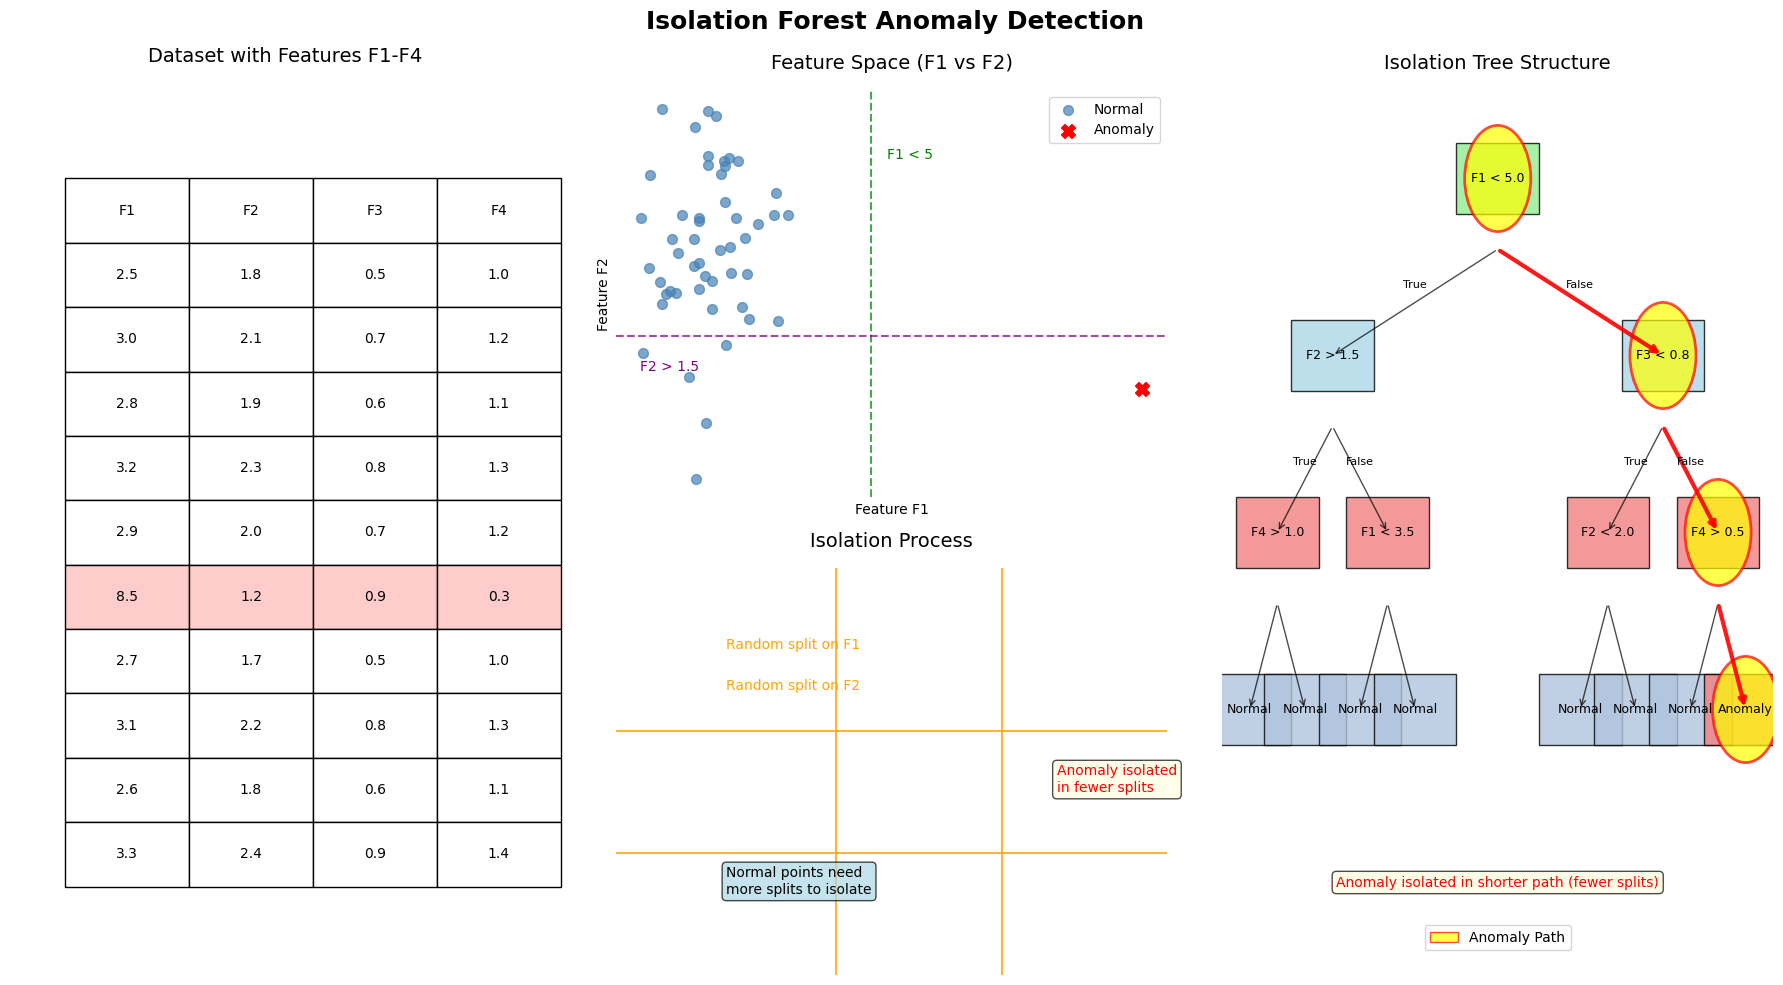

In [80]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from matplotlib.table import Table
import pandas as pd

# Set up the figure
plt.style.use('default')
fig = plt.figure(figsize=(18, 10))

# Create a grid for the layout
gs = fig.add_gridspec(2, 3, width_ratios=[1, 1, 1], height_ratios=[1, 1])

# Left side: Dataset and feature space
ax1 = fig.add_subplot(gs[:, 0])  # Dataset table
ax2 = fig.add_subplot(gs[0, 1])  # Feature space plot
ax3 = fig.add_subplot(gs[1, 1])  # Isolation process
ax4 = fig.add_subplot(gs[:, 2])  # Decision tree

# Remove axes for all subplots
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

# Title for the entire figure
fig.suptitle('Isolation Forest Anomaly Detection', fontsize=18, fontweight='bold')

# 1. Dataset table
data = {
    'F1': [2.5, 3.0, 2.8, 3.2, 2.9, 8.5, 2.7, 3.1, 2.6, 3.3],
    'F2': [1.8, 2.1, 1.9, 2.3, 2.0, 1.2, 1.7, 2.2, 1.8, 2.4],
    'F3': [0.5, 0.7, 0.6, 0.8, 0.7, 0.9, 0.5, 0.8, 0.6, 0.9],
    'F4': [1.0, 1.2, 1.1, 1.3, 1.2, 0.3, 1.0, 1.3, 1.1, 1.4]
}
df = pd.DataFrame(data)

ax1.set_title('Dataset with Features F1-F4', fontsize=14, pad=20)
table = ax1.table(cellText=df.values, 
                 colLabels=df.columns, 
                 cellLoc='center', 
                 loc='center',
                 bbox=[0.1, 0.1, 0.9, 0.8])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

# Highlight the anomaly row (index 5)
table[(6, 0)].set_facecolor('#ffcccc')
table[(6, 1)].set_facecolor('#ffcccc')
table[(6, 2)].set_facecolor('#ffcccc')
table[(6, 3)].set_facecolor('#ffcccc')

# 2. Feature space plot
np.random.seed(42)
# Generate normal points
x_normal = np.random.normal(3, 0.5, 50)
y_normal = np.random.normal(2, 0.5, 50)

# Generate anomaly points
x_anomaly = [8.5]
y_anomaly = [1.2]

ax2.set_title('Feature Space (F1 vs F2)', fontsize=14, pad=15)
ax2.scatter(x_normal, y_normal, c='steelblue', alpha=0.7, s=50, label='Normal')
ax2.scatter(x_anomaly, y_anomaly, c='red', s=100, label='Anomaly', marker='X')
ax2.set_xlabel('Feature F1')
ax2.set_ylabel('Feature F2')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Draw isolation lines
ax2.axvline(x=5, color='green', linestyle='--', alpha=0.7, label='Isolation Split')
ax2.axhline(y=1.5, color='purple', linestyle='--', alpha=0.7, label='Isolation Split')
ax2.text(5.2, 2.5, 'F1 < 5', fontsize=10, color='green')
ax2.text(2, 1.3, 'F2 > 1.5', fontsize=10, color='purple')

# 3. Isolation process visualization
ax3.set_title('Isolation Process', fontsize=14, pad=15)
ax3.set_xlim(0, 10)
ax3.set_ylim(0, 10)

# Draw random splits
ax3.axvline(x=4, color='orange', linestyle='-', alpha=0.8)
ax3.axvline(x=7, color='orange', linestyle='-', alpha=0.8)
ax3.axhline(y=3, color='orange', linestyle='-', alpha=0.8)
ax3.axhline(y=6, color='orange', linestyle='-', alpha=0.8)

# Add text labels
ax3.text(2, 8, 'Random split on F1', fontsize=10, color='orange')
ax3.text(2, 7, 'Random split on F2', fontsize=10, color='orange')
ax3.text(8, 4.5, 'Anomaly isolated\nin fewer splits', fontsize=10, color='red', 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.7))
ax3.text(2, 2, 'Normal points need\nmore splits to isolate', fontsize=10, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))

# 4. Decision tree visualization
ax4.set_title('Isolation Tree Structure', fontsize=14, pad=15)
ax4.set_xlim(0, 1)
ax4.set_ylim(0, 1)

# Draw tree nodes
def draw_tree_node(ax, x, y, text, width=0.15, height=0.08, color='lightblue', path_highlight=False):
    rect = patches.Rectangle((x-width/2, y-height/2), width, height, 
                            facecolor=color, edgecolor='black', linewidth=1, alpha=0.8)
    ax.add_patch(rect)
    ax.text(x, y, text, ha='center', va='center', fontsize=9)
    
    # Highlight the path for anomaly
    if path_highlight:
        circle = patches.Circle((x, y), radius=0.06, facecolor='yellow', edgecolor='red', linewidth=2, alpha=0.7)
        ax.add_patch(circle)

# Draw tree structure
# Root node
draw_tree_node(ax4, 0.5, 0.9, "F1 < 5.0", color='lightgreen', path_highlight=True)

# Level 1
draw_tree_node(ax4, 0.2, 0.7, "F2 > 1.5", color='lightblue')
draw_tree_node(ax4, 0.8, 0.7, "F3 < 0.8", color='lightblue', path_highlight=True)

# Level 2 - Left branch
draw_tree_node(ax4, 0.1, 0.5, "F4 > 1.0", color='lightcoral')
draw_tree_node(ax4, 0.3, 0.5, "F1 < 3.5", color='lightcoral')

# Level 2 - Right branch
draw_tree_node(ax4, 0.7, 0.5, "F2 < 2.0", color='lightcoral')
draw_tree_node(ax4, 0.9, 0.5, "F4 > 0.5", color='lightcoral', path_highlight=True)

# Leaves
draw_tree_node(ax4, 0.05, 0.3, "Normal", color='lightsteelblue')
draw_tree_node(ax4, 0.15, 0.3, "Normal", color='lightsteelblue')
draw_tree_node(ax4, 0.25, 0.3, "Normal", color='lightsteelblue')
draw_tree_node(ax4, 0.35, 0.3, "Normal", color='lightsteelblue')
draw_tree_node(ax4, 0.65, 0.3, "Normal", color='lightsteelblue')
draw_tree_node(ax4, 0.75, 0.3, "Normal", color='lightsteelblue')
draw_tree_node(ax4, 0.85, 0.3, "Normal", color='lightsteelblue')
draw_tree_node(ax4, 0.95, 0.3, "Anomaly", color='lightcoral', path_highlight=True)

# Draw connections
def draw_connection(ax, x1, y1, x2, y2, label=None, highlight=False):
    if highlight:
        ax.annotate('', xy=(x2, y2-0.04), xytext=(x1, y1-0.04),
                    arrowprops=dict(arrowstyle='->', lw=3, color='red', alpha=0.9))
    else:
        ax.annotate('', xy=(x2, y2-0.04), xytext=(x1, y1-0.04),
                    arrowprops=dict(arrowstyle='->', lw=1, color='black', alpha=0.7))
    if label:
        ax.text((x1+x2)/2, (y1+y2)/2-0.02, label, ha='center', va='center', fontsize=8)

# Root to level 1
draw_connection(ax4, 0.5, 0.86, 0.2, 0.74, "True")
draw_connection(ax4, 0.5, 0.86, 0.8, 0.74, "False", highlight=True)

# Level 1 to level 2 - Left branch
draw_connection(ax4, 0.2, 0.66, 0.1, 0.54, "True")
draw_connection(ax4, 0.2, 0.66, 0.3, 0.54, "False")

# Level 1 to level 2 - Right branch
draw_connection(ax4, 0.8, 0.66, 0.7, 0.54, "True")
draw_connection(ax4, 0.8, 0.66, 0.9, 0.54, "False", highlight=True)

# Level 2 to leaves
draw_connection(ax4, 0.1, 0.46, 0.05, 0.34)
draw_connection(ax4, 0.1, 0.46, 0.15, 0.34)
draw_connection(ax4, 0.3, 0.46, 0.25, 0.34)
draw_connection(ax4, 0.3, 0.46, 0.35, 0.34)
draw_connection(ax4, 0.7, 0.46, 0.65, 0.34)
draw_connection(ax4, 0.7, 0.46, 0.75, 0.34)
draw_connection(ax4, 0.9, 0.46, 0.85, 0.34)
draw_connection(ax4, 0.9, 0.46, 0.95, 0.34, highlight=True)

# Add text explaining the anomaly path
ax4.text(0.5, 0.1, "Anomaly isolated in shorter path (fewer splits)", 
         fontsize=10, ha='center', color='red',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.7))

# Add a legend for the highlighted path
highlight_patch = patches.Patch(facecolor='yellow', edgecolor='red', 
                               label='Anomaly Path', alpha=0.7)
ax4.legend(handles=[highlight_patch], loc='lower center', bbox_to_anchor=(0.5, 0.02))

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

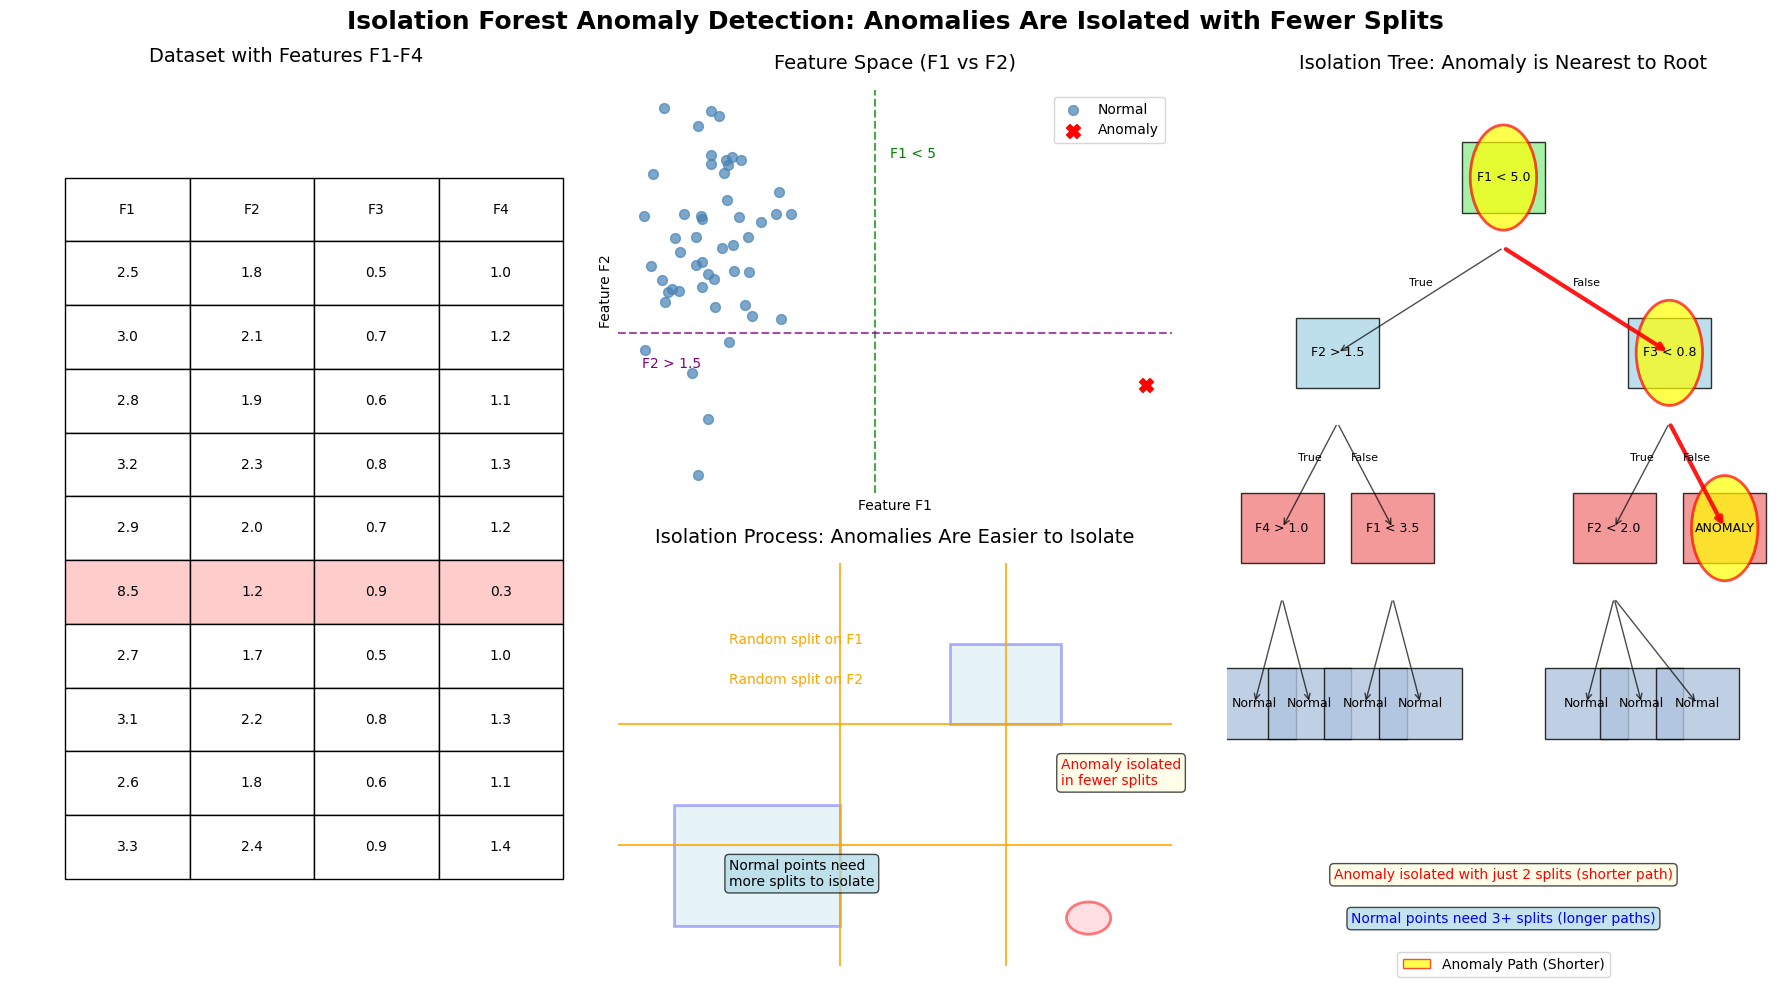

In [81]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from matplotlib.table import Table
import pandas as pd

# Set up the figure
plt.style.use('default')
fig = plt.figure(figsize=(18, 10))

# Create a grid for the layout
gs = fig.add_gridspec(2, 3, width_ratios=[1, 1, 1], height_ratios=[1, 1])

# Left side: Dataset and feature space
ax1 = fig.add_subplot(gs[:, 0])  # Dataset table
ax2 = fig.add_subplot(gs[0, 1])  # Feature space plot
ax3 = fig.add_subplot(gs[1, 1])  # Isolation process
ax4 = fig.add_subplot(gs[:, 2])  # Decision tree

# Remove axes for all subplots
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

# Title for the entire figure
fig.suptitle('Isolation Forest Anomaly Detection: Anomalies Are Isolated with Fewer Splits', 
             fontsize=18, fontweight='bold')

# 1. Dataset table
data = {
    'F1': [2.5, 3.0, 2.8, 3.2, 2.9, 8.5, 2.7, 3.1, 2.6, 3.3],
    'F2': [1.8, 2.1, 1.9, 2.3, 2.0, 1.2, 1.7, 2.2, 1.8, 2.4],
    'F3': [0.5, 0.7, 0.6, 0.8, 0.7, 0.9, 0.5, 0.8, 0.6, 0.9],
    'F4': [1.0, 1.2, 1.1, 1.3, 1.2, 0.3, 1.0, 1.3, 1.1, 1.4]
}
df = pd.DataFrame(data)

ax1.set_title('Dataset with Features F1-F4', fontsize=14, pad=20)
table = ax1.table(cellText=df.values, 
                 colLabels=df.columns, 
                 cellLoc='center', 
                 loc='center',
                 bbox=[0.1, 0.1, 0.9, 0.8])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

# Highlight the anomaly row (index 5)
table[(6, 0)].set_facecolor('#ffcccc')
table[(6, 1)].set_facecolor('#ffcccc')
table[(6, 2)].set_facecolor('#ffcccc')
table[(6, 3)].set_facecolor('#ffcccc')

# 2. Feature space plot
np.random.seed(42)
# Generate normal points
x_normal = np.random.normal(3, 0.5, 50)
y_normal = np.random.normal(2, 0.5, 50)

# Generate anomaly points
x_anomaly = [8.5]
y_anomaly = [1.2]

ax2.set_title('Feature Space (F1 vs F2)', fontsize=14, pad=15)
ax2.scatter(x_normal, y_normal, c='steelblue', alpha=0.7, s=50, label='Normal')
ax2.scatter(x_anomaly, y_anomaly, c='red', s=100, label='Anomaly', marker='X')
ax2.set_xlabel('Feature F1')
ax2.set_ylabel('Feature F2')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Draw isolation lines
ax2.axvline(x=5, color='green', linestyle='--', alpha=0.7, label='Isolation Split')
ax2.axhline(y=1.5, color='purple', linestyle='--', alpha=0.7, label='Isolation Split')
ax2.text(5.2, 2.5, 'F1 < 5', fontsize=10, color='green')
ax2.text(2, 1.3, 'F2 > 1.5', fontsize=10, color='purple')

# 3. Isolation process visualization
ax3.set_title('Isolation Process: Anomalies Are Easier to Isolate', fontsize=14, pad=15)
ax3.set_xlim(0, 10)
ax3.set_ylim(0, 10)

# Draw random splits
ax3.axvline(x=4, color='orange', linestyle='-', alpha=0.8)
ax3.axvline(x=7, color='orange', linestyle='-', alpha=0.8)
ax3.axhline(y=3, color='orange', linestyle='-', alpha=0.8)
ax3.axhline(y=6, color='orange', linestyle='-', alpha=0.8)

# Add text labels
ax3.text(2, 8, 'Random split on F1', fontsize=10, color='orange')
ax3.text(2, 7, 'Random split on F2', fontsize=10, color='orange')
ax3.text(8, 4.5, 'Anomaly isolated\nin fewer splits', fontsize=10, color='red', 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.7))
ax3.text(2, 2, 'Normal points need\nmore splits to isolate', fontsize=10, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))

# Draw clusters
cluster1 = patches.Rectangle((1, 1), 3, 3, linewidth=2, edgecolor='blue', 
                            facecolor='lightblue', alpha=0.3)
cluster2 = patches.Rectangle((6, 6), 2, 2, linewidth=2, edgecolor='blue', 
                            facecolor='lightblue', alpha=0.3)
ax3.add_patch(cluster1)
ax3.add_patch(cluster2)

# Draw isolated anomaly
anomaly_circle = patches.Circle((8.5, 1.2), radius=0.4, linewidth=2, edgecolor='red', 
                               facecolor='pink', alpha=0.5)
ax3.add_patch(anomaly_circle)

# 4. Decision tree visualization
ax4.set_title('Isolation Tree: Anomaly is Nearest to Root', fontsize=14, pad=15)
ax4.set_xlim(0, 1)
ax4.set_ylim(0, 1)

# Draw tree nodes with modified positions to show anomaly is closer
def draw_tree_node(ax, x, y, text, width=0.15, height=0.08, color='lightblue', path_highlight=False):
    rect = patches.Rectangle((x-width/2, y-height/2), width, height, 
                            facecolor=color, edgecolor='black', linewidth=1, alpha=0.8)
    ax.add_patch(rect)
    ax.text(x, y, text, ha='center', va='center', fontsize=9)
    
    # Highlight the path for anomaly
    if path_highlight:
        circle = patches.Circle((x, y), radius=0.06, facecolor='yellow', edgecolor='red', linewidth=2, alpha=0.7)
        ax.add_patch(circle)

# Draw tree structure with anomaly leaf placed closer to root
# Root node
draw_tree_node(ax4, 0.5, 0.9, "F1 < 5.0", color='lightgreen', path_highlight=True)

# Level 1 - Place anomaly branch closer to root
draw_tree_node(ax4, 0.2, 0.7, "F2 > 1.5", color='lightblue')
draw_tree_node(ax4, 0.8, 0.7, "F3 < 0.8", color='lightblue', path_highlight=True)

# Level 2 - Left branch (normal points, deeper)
draw_tree_node(ax4, 0.1, 0.5, "F4 > 1.0", color='lightcoral')
draw_tree_node(ax4, 0.3, 0.5, "F1 < 3.5", color='lightcoral')

# Level 2 - Right branch (anomaly path, shallower)
draw_tree_node(ax4, 0.7, 0.5, "F2 < 2.0", color='lightcoral')
# Anomaly leaf is placed at this level instead of deeper
draw_tree_node(ax4, 0.9, 0.5, "ANOMALY", color='lightcoral', path_highlight=True)

# Leaves for normal points (deeper in the tree)
draw_tree_node(ax4, 0.05, 0.3, "Normal", color='lightsteelblue')
draw_tree_node(ax4, 0.15, 0.3, "Normal", color='lightsteelblue')
draw_tree_node(ax4, 0.25, 0.3, "Normal", color='lightsteelblue')
draw_tree_node(ax4, 0.35, 0.3, "Normal", color='lightsteelblue')
draw_tree_node(ax4, 0.65, 0.3, "Normal", color='lightsteelblue')
draw_tree_node(ax4, 0.75, 0.3, "Normal", color='lightsteelblue')
draw_tree_node(ax4, 0.85, 0.3, "Normal", color='lightsteelblue')

# Draw connections
def draw_connection(ax, x1, y1, x2, y2, label=None, highlight=False):
    if highlight:
        ax.annotate('', xy=(x2, y2-0.04), xytext=(x1, y1-0.04),
                    arrowprops=dict(arrowstyle='->', lw=3, color='red', alpha=0.9))
    else:
        ax.annotate('', xy=(x2, y2-0.04), xytext=(x1, y1-0.04),
                    arrowprops=dict(arrowstyle='->', lw=1, color='black', alpha=0.7))
    if label:
        ax.text((x1+x2)/2, (y1+y2)/2-0.02, label, ha='center', va='center', fontsize=8)

# Root to level 1
draw_connection(ax4, 0.5, 0.86, 0.2, 0.74, "True")
draw_connection(ax4, 0.5, 0.86, 0.8, 0.74, "False", highlight=True)

# Level 1 to level 2 - Left branch (normal points)
draw_connection(ax4, 0.2, 0.66, 0.1, 0.54, "True")
draw_connection(ax4, 0.2, 0.66, 0.3, 0.54, "False")

# Level 1 to level 2 - Right branch (anomaly path)
draw_connection(ax4, 0.8, 0.66, 0.7, 0.54, "True")
draw_connection(ax4, 0.8, 0.66, 0.9, 0.54, "False", highlight=True)

# Level 2 to leaves (normal points, deeper)
draw_connection(ax4, 0.1, 0.46, 0.05, 0.34)
draw_connection(ax4, 0.1, 0.46, 0.15, 0.34)
draw_connection(ax4, 0.3, 0.46, 0.25, 0.34)
draw_connection(ax4, 0.3, 0.46, 0.35, 0.34)
draw_connection(ax4, 0.7, 0.46, 0.65, 0.34)
draw_connection(ax4, 0.7, 0.46, 0.75, 0.34)
draw_connection(ax4, 0.7, 0.46, 0.85, 0.34)

# Add text explaining the anomaly path
ax4.text(0.5, 0.1, "Anomaly isolated with just 2 splits (shorter path)", 
         fontsize=10, ha='center', color='red',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.7))
ax4.text(0.5, 0.05, "Normal points need 3+ splits (longer paths)", 
         fontsize=10, ha='center', color='blue',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))

# Add a legend for the highlighted path
highlight_patch = patches.Patch(facecolor='yellow', edgecolor='red', 
                               label='Anomaly Path (Shorter)', alpha=0.7)
ax4.legend(handles=[highlight_patch], loc='lower center', bbox_to_anchor=(0.5, -0.02))

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

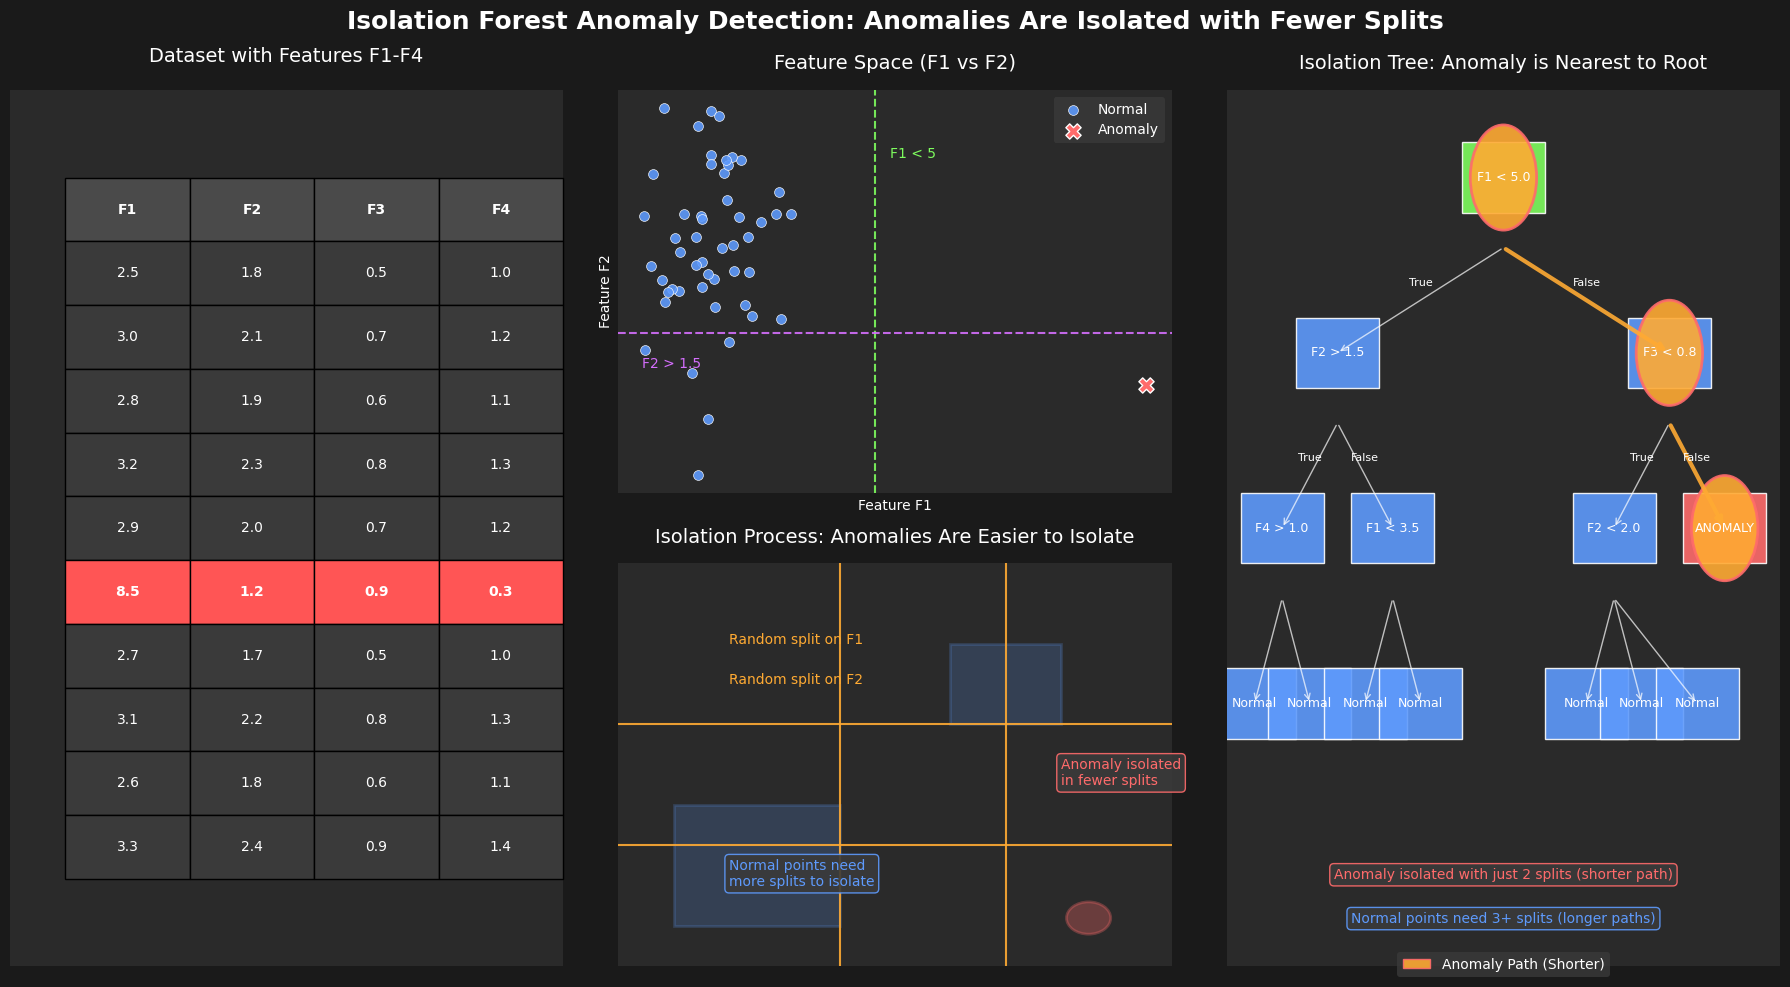

In [82]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from matplotlib.table import Table
import pandas as pd

# Set dark theme
plt.style.use('dark_background')
fig = plt.figure(figsize=(18, 10), facecolor='#1a1a1a')

# Create a grid for the layout
gs = fig.add_gridspec(2, 3, width_ratios=[1, 1, 1], height_ratios=[1, 1])

# Left side: Dataset and feature space
ax1 = fig.add_subplot(gs[:, 0])  # Dataset table
ax2 = fig.add_subplot(gs[0, 1])  # Feature space plot
ax3 = fig.add_subplot(gs[1, 1])  # Isolation process
ax4 = fig.add_subplot(gs[:, 2])  # Decision tree

# Set dark background for all subplots
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_facecolor('#2a2a2a')
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

# Title for the entire figure
fig.suptitle('Isolation Forest Anomaly Detection: Anomalies Are Isolated with Fewer Splits', 
             fontsize=18, fontweight='bold', color='white')

# 1. Dataset table
data = {
    'F1': [2.5, 3.0, 2.8, 3.2, 2.9, 8.5, 2.7, 3.1, 2.6, 3.3],
    'F2': [1.8, 2.1, 1.9, 2.3, 2.0, 1.2, 1.7, 2.2, 1.8, 2.4],
    'F3': [0.5, 0.7, 0.6, 0.8, 0.7, 0.9, 0.5, 0.8, 0.6, 0.9],
    'F4': [1.0, 1.2, 1.1, 1.3, 1.2, 0.3, 1.0, 1.3, 1.1, 1.4]
}
df = pd.DataFrame(data)

ax1.set_title('Dataset with Features F1-F4', fontsize=14, pad=20, color='white')
table = ax1.table(cellText=df.values, 
                 colLabels=df.columns, 
                 cellLoc='center', 
                 loc='center',
                 bbox=[0.1, 0.1, 0.9, 0.8])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

# Update table colors for dark theme
for cell in table._cells:
    table._cells[cell].set_text_props(color='white')
    table._cells[cell].set_facecolor('#3a3a3a')
    
# Set header row color
for i in range(4):
    table[(0, i)].set_facecolor('#4a4a4a')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Highlight the anomaly row (index 5)
table[(6, 0)].set_facecolor('#ff5555')
table[(6, 1)].set_facecolor('#ff5555')
table[(6, 2)].set_facecolor('#ff5555')
table[(6, 3)].set_facecolor('#ff5555')
for i in range(4):
    table[(6, i)].set_text_props(color='white', weight='bold')

# 2. Feature space plot
np.random.seed(42)
# Generate normal points
x_normal = np.random.normal(3, 0.5, 50)
y_normal = np.random.normal(2, 0.5, 50)

# Generate anomaly points
x_anomaly = [8.5]
y_anomaly = [1.2]

ax2.set_title('Feature Space (F1 vs F2)', fontsize=14, pad=15, color='white')
ax2.scatter(x_normal, y_normal, c='#5e9afc', alpha=0.9, s=50, label='Normal', edgecolors='white', linewidth=0.5)
ax2.scatter(x_anomaly, y_anomaly, c='#ff6b6b', s=120, label='Anomaly', marker='X', edgecolors='white', linewidth=1)
ax2.set_xlabel('Feature F1', color='white')
ax2.set_ylabel('Feature F2', color='white')
ax2.legend(facecolor='#3a3a3a', edgecolor='none', labelcolor='white')
ax2.grid(True, alpha=0.2, color='#555555')
ax2.tick_params(colors='white')

# Draw isolation lines
ax2.axvline(x=5, color='#7efc5e', linestyle='--', alpha=0.9, label='Isolation Split')
ax2.axhline(y=1.5, color='#d46efc', linestyle='--', alpha=0.9, label='Isolation Split')
ax2.text(5.2, 2.5, 'F1 < 5', fontsize=10, color='#7efc5e')
ax2.text(2, 1.3, 'F2 > 1.5', fontsize=10, color='#d46efc')

# 3. Isolation process visualization
ax3.set_title('Isolation Process: Anomalies Are Easier to Isolate', fontsize=14, pad=15, color='white')
ax3.set_xlim(0, 10)
ax3.set_ylim(0, 10)

# Draw random splits
ax3.axvline(x=4, color='#ffaa33', linestyle='-', alpha=0.9)
ax3.axvline(x=7, color='#ffaa33', linestyle='-', alpha=0.9)
ax3.axhline(y=3, color='#ffaa33', linestyle='-', alpha=0.9)
ax3.axhline(y=6, color='#ffaa33', linestyle='-', alpha=0.9)

# Add text labels
ax3.text(2, 8, 'Random split on F1', fontsize=10, color='#ffaa33')
ax3.text(2, 7, 'Random split on F2', fontsize=10, color='#ffaa33')
ax3.text(8, 4.5, 'Anomaly isolated\nin fewer splits', fontsize=10, color='#ff6b6b', 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="#3a3a3a", edgecolor='#ff6b6b', alpha=0.9))
ax3.text(2, 2, 'Normal points need\nmore splits to isolate', fontsize=10, color='#5e9afc',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="#3a3a3a", edgecolor='#5e9afc', alpha=0.9))

# Draw clusters
cluster1 = patches.Rectangle((1, 1), 3, 3, linewidth=2, edgecolor='#5e9afc', 
                            facecolor='#5e9afc', alpha=0.2)
cluster2 = patches.Rectangle((6, 6), 2, 2, linewidth=2, edgecolor='#5e9afc', 
                            facecolor='#5e9afc', alpha=0.2)
ax3.add_patch(cluster1)
ax3.add_patch(cluster2)

# Draw isolated anomaly
anomaly_circle = patches.Circle((8.5, 1.2), radius=0.4, linewidth=2, edgecolor='#ff6b6b', 
                               facecolor='#ff6b6b', alpha=0.3)
ax3.add_patch(anomaly_circle)

# 4. Decision tree visualization
ax4.set_title('Isolation Tree: Anomaly is Nearest to Root', fontsize=14, pad=15, color='white')
ax4.set_xlim(0, 1)
ax4.set_ylim(0, 1)

# Draw tree nodes with modified positions to show anomaly is closer
def draw_tree_node(ax, x, y, text, width=0.15, height=0.08, color='#5e9afc', path_highlight=False):
    rect = patches.Rectangle((x-width/2, y-height/2), width, height, 
                            facecolor=color, edgecolor='white', linewidth=1, alpha=0.9)
    ax.add_patch(rect)
    ax.text(x, y, text, ha='center', va='center', fontsize=9, color='white')
    
    # Highlight the path for anomaly
    if path_highlight:
        circle = patches.Circle((x, y), radius=0.06, facecolor='#ffaa33', edgecolor='#ff6b6b', linewidth=2, alpha=0.9)
        ax.add_patch(circle)

# Draw tree structure with anomaly leaf placed closer to root
# Root node
draw_tree_node(ax4, 0.5, 0.9, "F1 < 5.0", color='#7efc5e', path_highlight=True)

# Level 1 - Place anomaly branch closer to root
draw_tree_node(ax4, 0.2, 0.7, "F2 > 1.5", color='#5e9afc')
draw_tree_node(ax4, 0.8, 0.7, "F3 < 0.8", color='#5e9afc', path_highlight=True)

# Level 2 - Left branch (normal points, deeper)
draw_tree_node(ax4, 0.1, 0.5, "F4 > 1.0", color='#5e9afc')
draw_tree_node(ax4, 0.3, 0.5, "F1 < 3.5", color='#5e9afc')

# Level 2 - Right branch (anomaly path, shallower)
draw_tree_node(ax4, 0.7, 0.5, "F2 < 2.0", color='#5e9afc')
# Anomaly leaf is placed at this level instead of deeper
draw_tree_node(ax4, 0.9, 0.5, "ANOMALY", color='#ff6b6b', path_highlight=True)

# Leaves for normal points (deeper in the tree)
draw_tree_node(ax4, 0.05, 0.3, "Normal", color='#5e9afc')
draw_tree_node(ax4, 0.15, 0.3, "Normal", color='#5e9afc')
draw_tree_node(ax4, 0.25, 0.3, "Normal", color='#5e9afc')
draw_tree_node(ax4, 0.35, 0.3, "Normal", color='#5e9afc')
draw_tree_node(ax4, 0.65, 0.3, "Normal", color='#5e9afc')
draw_tree_node(ax4, 0.75, 0.3, "Normal", color='#5e9afc')
draw_tree_node(ax4, 0.85, 0.3, "Normal", color='#5e9afc')

# Draw connections
def draw_connection(ax, x1, y1, x2, y2, label=None, highlight=False):
    if highlight:
        ax.annotate('', xy=(x2, y2-0.04), xytext=(x1, y1-0.04),
                    arrowprops=dict(arrowstyle='->', lw=3, color='#ffaa33', alpha=0.9))
    else:
        ax.annotate('', xy=(x2, y2-0.04), xytext=(x1, y1-0.04),
                    arrowprops=dict(arrowstyle='->', lw=1, color='white', alpha=0.7))
    if label:
        ax.text((x1+x2)/2, (y1+y2)/2-0.02, label, ha='center', va='center', fontsize=8, color='white')

# Root to level 1
draw_connection(ax4, 0.5, 0.86, 0.2, 0.74, "True")
draw_connection(ax4, 0.5, 0.86, 0.8, 0.74, "False", highlight=True)

# Level 1 to level 2 - Left branch (normal points)
draw_connection(ax4, 0.2, 0.66, 0.1, 0.54, "True")
draw_connection(ax4, 0.2, 0.66, 0.3, 0.54, "False")

# Level 1 to level 2 - Right branch (anomaly path)
draw_connection(ax4, 0.8, 0.66, 0.7, 0.54, "True")
draw_connection(ax4, 0.8, 0.66, 0.9, 0.54, "False", highlight=True)

# Level 2 to leaves (normal points, deeper)
draw_connection(ax4, 0.1, 0.46, 0.05, 0.34)
draw_connection(ax4, 0.1, 0.46, 0.15, 0.34)
draw_connection(ax4, 0.3, 0.46, 0.25, 0.34)
draw_connection(ax4, 0.3, 0.46, 0.35, 0.34)
draw_connection(ax4, 0.7, 0.46, 0.65, 0.34)
draw_connection(ax4, 0.7, 0.46, 0.75, 0.34)
draw_connection(ax4, 0.7, 0.46, 0.85, 0.34)

# Add text explaining the anomaly path
ax4.text(0.5, 0.1, "Anomaly isolated with just 2 splits (shorter path)", 
         fontsize=10, ha='center', color='#ff6b6b',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="#3a3a3a", edgecolor='#ff6b6b', alpha=0.9))
ax4.text(0.5, 0.05, "Normal points need 3+ splits (longer paths)", 
         fontsize=10, ha='center', color='#5e9afc',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="#3a3a3a", edgecolor='#5e9afc', alpha=0.9))

# Add a legend for the highlighted path
highlight_patch = patches.Patch(facecolor='#ffaa33', edgecolor='#ff6b6b', 
                               label='Anomaly Path (Shorter)', alpha=0.9)
ax4.legend(handles=[highlight_patch], loc='lower center', bbox_to_anchor=(0.5, -0.02),
           facecolor='#3a3a3a', edgecolor='none', labelcolor='white')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

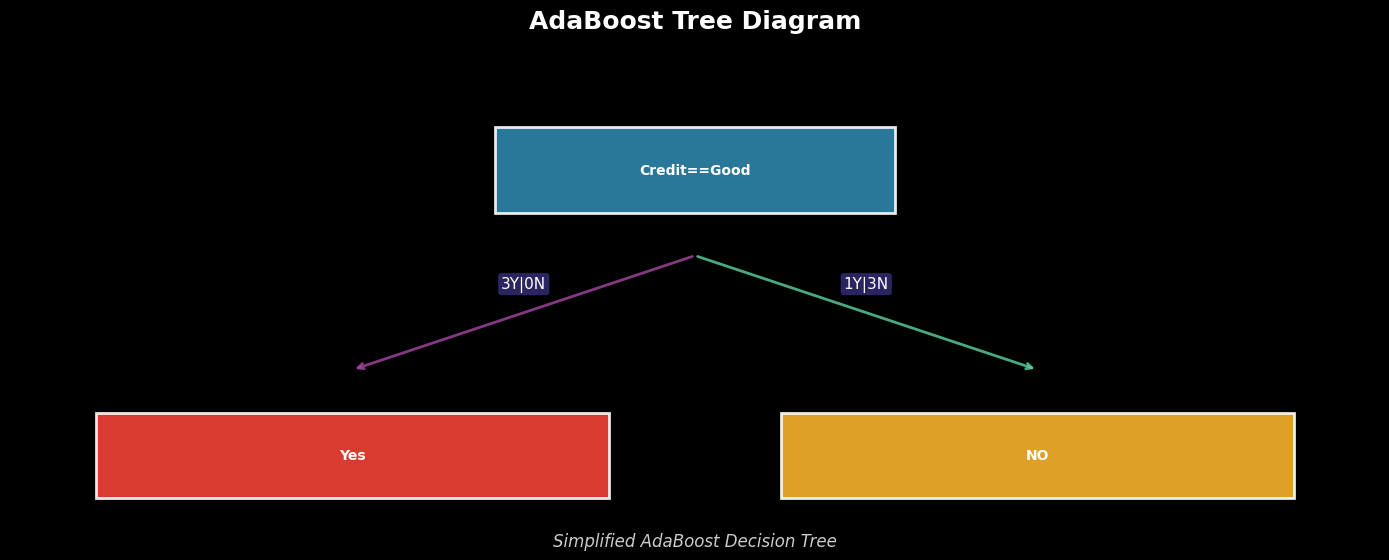

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Set up the figure with dark background
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(14, 8))
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(1.2, 2.0)  # Shifted the view upward to position the tree at the top
ax.set_aspect('equal')
ax.axis('off')

# Title
plt.title('AdaBoost Tree Diagram', fontsize=18, fontweight='bold', pad=20, color='white')

# Draw rectangular nodes
def draw_rect_node(x, y, text, color='#2E86AB', width=0.7, height=0.15):
    rect = patches.Rectangle((x-width/2, y-height/2), width, height, 
                            facecolor=color, edgecolor='white', linewidth=2, alpha=0.9)
    ax.add_patch(rect)
    ax.text(x, y, text, ha='center', va='center', fontsize=10, fontweight='bold', color='white')
    return rect

# Draw connection arrows with visible colors
def draw_arrow(x1, y1, x2, y2, text=None, text_offset=0, color='#F24236'):
    ax.annotate('', xy=(x2, y2), xytext=(x1, y1),
                arrowprops=dict(arrowstyle='->', lw=2, color=color, alpha=0.8))
    if text:
        ax.text((x1+x2)/2, (y1+y2)/2 + text_offset, text, 
                ha='center', va='center', fontsize=11, color='white',
                bbox=dict(boxstyle="round,pad=0.2", facecolor="#3D348B", edgecolor="none", alpha=0.7))

def draw_rec_node(x, y, text, color='#2E86AB', width=0.9, height=0.15):
    rect = patches.Rectangle((x-width/2, y-height/2), width, height, 
                            facecolor=color, edgecolor='white', linewidth=2, alpha=0.9)
    ax.add_patch(rect)
    ax.text(x, y, text, ha='center', va='center', fontsize=10, fontweight='bold', color='white')
    return rect

# Position the tree at the top
# Root node - positioned higher
root = draw_rect_node(0, 1.8, "Credit==Good", color='#2E86AB')

# First level - positioned higher
node1 = draw_rec_node(-0.6, 1.3, "Yes", color='#F24236')
node2 = draw_rec_node(0.6, 1.3, "NO", color='#F7B32B')

# Connect root to first level
draw_arrow(0, 1.65, -0.6, 1.45, "3Y|0N", 0.05, color='#A846A0')
draw_arrow(0, 1.65, 0.6, 1.45, "1Y|3N", 0.05, color='#5DD39E')

# Add a subtle background grid
ax.grid(True, alpha=0.05, linestyle='--', color='white')

# Add some space at the bottom for potential additional elements
ax.text(0, 1.15, "Simplified AdaBoost Decision Tree", 
        ha='center', va='center', fontsize=12, color='#CCCCCC',
        style='italic')

plt.tight_layout()
plt.show()